# Retinal OCT Imaging
<hr style="border:2px solid pink">

## Introduction

#### Background

Retinal optical coherence tomography (OCT) is a noninvasive imaging technique that essentially takes pictures of your retinas by measuring how much light reflects off the retina and optic nerve. It can be used to help diagnose and manage diseases like diabetes-related retinopathy, age-related macular degeneration (AMD), and glaucoma, amongst others. Millions of OCT scans are performed each year, and the analysis and interpretation of the images can take up a tremendous amount of time.

#### Business Problem

In order to save time and resources in analyzing and interpreting OCT scans, the problem at hand is to create a model that can predict whether a patient's retinal scan is normal or shows signs of CNV, DME, or DRUSEN diseases. Given that these diseases can lead to vision loss, the primary objective is to provide a more efficient method for medical professionals, particularly ophthalmologists, in their interpretation and analysis of retinal scans. 

#### Data Understanding

The data for this project comes from Kaggle: https://www.kaggle.com/datasets/paultimothymooney/kermany2018/data. It
contains 84,495 images, and 4 categories to predict (NORMAL, CNV, DME, or DRUSEN). 

The data is split into separate train, test, and validation folders. Within each of these, there are labeled sub-folders for each category, with each individual image labeled as such: (disease)-(randomized patient ID)-(image number by
this patient).

The images were selected from adult patients from the Shiley Eye Institute of the University of California San Diego, the California Retinal Research Foundation, Medical Center Ophthalmology Associates, the Shanghai First People’s Hospital, and Beijing Tongren Eye Center between July 1, 2013 and March 1, 2017. 

A meticulous tiered grading system was then applied to each image. The first tier involved undergraduate and medical students who had completed an OCT interpretation course, ensuring basic quality control. The second tier included four ophthalmologists who independently labeled each image passing the initial review, recording the presence or absence of pathologies. Finally, the third tier comprised of two senior independent retinal specialists, each with over 20 years of clinical retina experience, who verified the true labels for each image. 

These labels are our ground truth. 

#### Definitions

According to the National Library of Medicine, the following terms are defined as follows: 

1. CNV: (Choroidal Neovascularization): a condition where abnormal blood vessels grow beneath the retina in the choroid area. These abnormal blood vessels can leak fluid or blood into the retina, which can cause vision loss. Commonly associated with age-related macular degeneration (AMD), which is a leading cause of vision loss in older adults.

2. DME (Diabetic Macular Edema): a complication of diabetic retinopathy, which is an eye condition that can develop in people with diabetes. DME occurs when fluid builds in the macula, the central part of the retina responsible for our central vision, leading to to vision impairment and distortion.

3. Drusen: small yellow or white deposits that accumulate in the retina. They can be found in the macula or the peripheral retina. Drusen are a hallmark sign of age-related macular degeneration (AMD). 

Treatment options for CNV, DME, and AMD may include medications, laser therapy, or in some cases, surgical interventions, depending on the specific condition and its stage.

#### Please Note
1. There are several working copies saved in the code folder on the GitHub repo. 
2. There are 3 working versions of multi-class models, and 1 working version of binary models. 
3. This notebook explores a binary classification model where normal is class 0 (normal) and CNV, DME, and Drusen are all class 1 (abnormal). 
4. All notebooks assume you have the data downloaded and saved in a folder called Data. Please refer to the train path, test path, and val path for the exact way to save it. 
4. Due to the random nature of neural networks, results are not guaranteed to be exactly the same each time you run any given model. 

# General Exploration
<hr style="border:2px solid pink">

Before we start the modeling process, let's get an idea of the data we're working with. To get started, let's import the necessary libraries.

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.image import imread
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, array_to_img, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_validate

from sklearn.metrics import confusion_matrix, classification_report, make_scorer, RocCurveDisplay, roc_curve,\
recall_score,accuracy_score, precision_score, f1_score, roc_auc_score, ConfusionMatrixDisplay

from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision, Recall, TruePositives, TrueNegatives, FalseNegatives, FalsePositives

import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import warnings
warnings.filterwarnings('ignore')

Let's load in the data next. We need to create directories to where the data is saved, so let's start with that. 

In [2]:
# create directory paths for each folder (train, test, and val)
train_path = 'Data/OCT2017/train'
test_path = 'Data/OCT2017/test'
val_path = 'Data/OCT2017/val'

To investigate the raw data, I'll load it in normally, i.e., no scaling or augmentations done, using ImageDataGenerator() from tensorflow Keras. I'll set smaller batch sizes to help with efficiency, and I'll set the seed to 42 to help with reproducibility. 

In [3]:
original_train = ImageDataGenerator().flow_from_directory(train_path, batch_size=200, seed=42)
original_test = ImageDataGenerator().flow_from_directory(test_path, batch_size=100, seed=42)
original_val = ImageDataGenerator().flow_from_directory(val_path, batch_size=5, seed=42)

original_train_images, original_train_labels = next(original_train)
original_test_images, original_test_labels = next(original_test)
original_val_images, original_val_labels = next(original_val)

Found 83484 images belonging to 4 classes.
Found 968 images belonging to 4 classes.
Found 32 images belonging to 4 classes.


Notice that there are 4 classes: This represents normal, CNV, DME, or Drusen. Before visualizing the distribution, let's find out the original size of the images. First, I will look at the shape of each dataset to get a general idea. Then, to make sure each image is the same size, I will loop through every image in the images dataset, take its size, add it to a list, and take the unique values of that list. 

In [4]:
# look at the shapes
print(f"Train Images Shape: {original_train_images.shape}")
print(f"Train Labels Shape: {original_train_labels.shape}")
print(f"Test Images Shape: {original_test_images.shape}")
print(f"Test Labels Shape: {original_test_labels.shape}")
print(f"Val Images Shape: {original_val_images.shape}")
print(f"Val Labels Shape: {original_val_labels.shape}")

Train Images Shape: (200, 256, 256, 3)
Train Labels Shape: (200, 4)
Test Images Shape: (100, 256, 256, 3)
Test Labels Shape: (100, 4)
Val Images Shape: (5, 256, 256, 3)
Val Labels Shape: (5, 4)


It looks like each image is 256x256, but let's confirm this with the loop.

In [5]:
# loop through each images in the array and add the size to an empty list
train_sizes = []
test_sizes = []
val_sizes = []

for img in original_train_images:
    size = np.array(array_to_img(img).size)
    train_sizes.append(size)
    
for img in original_test_images:
    size = np.array(array_to_img(img).size)
    test_sizes.append(size)
    
for img in original_val_images:
    size = np.array(array_to_img(img).size)
    val_sizes.append(size)

In [6]:
# how many unique sizes are in each list? theoretically should be the same for each pic
# change the list of np arrays into a list of tuples, then take the "set" to get unique values

unique_train_sizes = list(set([tuple(size) for size in train_sizes]))
unique_test_sizes = list(set([tuple(size) for size in test_sizes]))
unique_val_sizes = list(set([tuple(size) for size in val_sizes]))

print(f"Original Train Image Size: {unique_train_sizes}")
print(f"Original Test Image Size: {unique_test_sizes}")
print(f"Original Val Image Size: {unique_val_sizes}")

Original Train Image Size: [(256, 256)]
Original Test Image Size: [(256, 256)]
Original Val Image Size: [(256, 256)]


Great! So the original images were indeed all 256x256. Since I noticed when loading in the data that there are 4 classes, let's now take a look at the distribution of the images in our dataset. 

In [7]:
# first, create paths to each individual folder
normal_train_path = 'Data/OCT2017/train/NORMAL'
cnv_train_path = 'Data/OCT2017/train/CNV'
dme_train_path = 'Data/OCT2017/train/DME'
drusen_train_path = 'Data/OCT2017/train/DRUSEN'

# then, take the "length" of each folder to get the total number of images per category
normal_count = len(os.listdir(normal_train_path))
cnv_count = len(os.listdir(cnv_train_path))
dme_count = len(os.listdir(dme_train_path))
drusen_count = len(os.listdir(drusen_train_path))

# print the results
print(f'Normal Count: {normal_count}')
print(f'CNV Count: {cnv_count}')
print(f'DME Count: {dme_count}')
print(f'Drusen Count: {drusen_count}')

Normal Count: 26315
CNV Count: 37205
DME Count: 11348
Drusen Count: 8616


So, there are 26,315 normal images, 37,205 CNV images, 11,348 DME images, and 8,616 Drusen images. This is imbalanced - there are many more CNV and normal images than there are DME and Drusen. Let's visualize the distribution. 

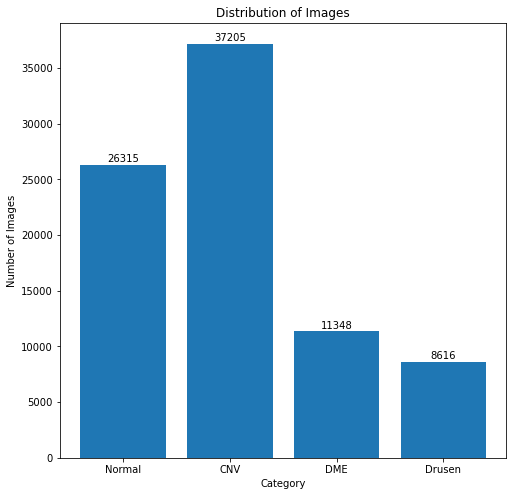

In [8]:
# create the categories for X (categories) and Y (counts)
categories = ['Normal', 'CNV', 'DME', 'Drusen']
counts = [normal_count, cnv_count, dme_count, drusen_count]

# plot it
fig, ax = plt.subplots(figsize=(8,8))
plt.bar(categories, counts)
plt.xlabel('Category')
plt.ylabel('Number of Images')
plt.title('Distribution of Images')

# add counts to the top of the bars
for rect in ax.patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2
    space = 1
    label = "{:.0f}".format(y_value)
    ax.annotate(label, (x_value, y_value), xytext=(0, space), textcoords="offset points", ha='center', va='bottom')

plt.show();

This makes the distributions a little more clear! There's the most CNV images and the least Drusen images. Another thing to note is that since our dataset it imbalanced, it may be beneficial to try data augmentation when modeling to help produce more samples of each class. 

Let's look at a few images and labels, so we can get an idea of what we're dealing with. 

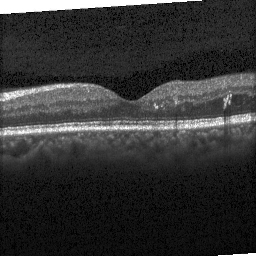

In [9]:
# look at the image
array_to_img(original_train_images[16])

In [10]:
# look at the labels
original_train_labels[16]

array([0., 1., 0., 0.], dtype=float32)

In [11]:
# look at the class indices, i.e., is it a 0, 1, 2, or 3
original_train.class_indices

{'CNV': 0, 'DME': 1, 'DRUSEN': 2, 'NORMAL': 3}

Ok, so here, I see that each category corresponds to a class. CNV is class 0, DME is class 1, DRUSEN is class 2, and NORMAL is class 3. 

You would interpret the array [0., 1., 0., 0.] as follows: the first class (index 0, corresponds to CNV) has a probability of 0. The second class (index 1, corresponds to DME) has a probability of 1. The third class (index 2, corresponds to Drusen) and the fourth class (index 3, corresponds to normal) have probabilities of 0. This means that the image is DME. 

Let's plot a few images from each class, with their corresponding labels titling the plot.

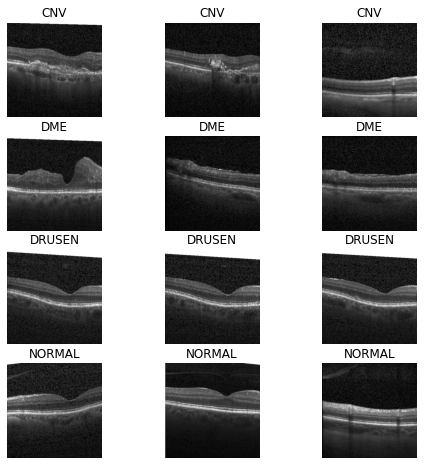

In [12]:
# we have paths to each subfolder, so create a list paths that has them all
# create a list categories with each of the subfolders for labeling purposes
paths = [cnv_train_path, dme_train_path, drusen_train_path, normal_train_path]
categories = ['CNV', 'DME', 'DRUSEN', 'NORMAL']
fig, axes = plt.subplots(nrows=len(categories), ncols=3, figsize=(8, 8))

# iterate through paths to get the image path
for index, path in enumerate(paths):
    image_files = [file for file in os.listdir(path) if file.endswith('.jpeg')]
    
    # Limit the number of images to fit the layout
    total_images_per_cat = min(len(image_files), 3)
    
    for i in range(total_images_per_cat): 
        image_file = image_files[i]
        image_path = os.path.join(path, image_file)
        image = imread(image_path)
        image = image[:400, :400]
            
        # Display the image in a subplot
        ax = axes[index, i]
        ax.imshow(image, cmap='gray')
        ax.set_title(categories[index])
        ax.axis('off')

plt.show()

Great! So we have a little better understanding of what each image might look like. Let's start preprocessing so we can start modeling. 

# Preprocessing
<hr style="border:2px solid pink">

To preprocess the data for a convolutional neural network, I will start the following: 
1. Scale the data: CNNs are sensitive to the scale of input features. Scaling the data will ensure numerical stability during training. For images, pixel values are usually in the range [0,255], so to rescale them to the range [0,1], I will divide each pixel by 255.
2. Resize the images: Smaller images can be less computationally intensive, leading to faster training times. This will also help ensure all inputs have the same shape. I will start with decreasing the size to 64x64.
3. Set the seed: To help with reproducibility, I will set the seed equal to 42. 
4. Set the color mode: Since these images are originally in black and white, I will set the color_mode to grayscale to capture this. 
5. Set data augmentation filters: I'll add filters such as flipping, shifting, rotating, and adjusting the brightness/zoom/shearness of the images. This will randomly apply these transformations to the images in order to add more data to the training set only, adding variety into my model and increasing the size of the training set. This should help with generalization. 
6. Set to binary: for this notebook, I will be predicting if the image is normal, or abnormal, where abnormal is any CNV, DME, or Drusen image. Therefore, I will set this to binary so the models predict in binary. 

In [13]:
# load in and preprocess the data in smaller batches
# Scale and transform the images, reshape to be 64x64, set the seed, and set the color to grayscale

target_size = (64,64)
train_generator = ImageDataGenerator(rescale=1.0/255.0, 
                                     horizontal_flip=True,
                                     height_shift_range=0.2,
                                     width_shift_range=0.2,
                                     rotation_range=45,
                                     brightness_range=[0.4,1],
                                     zoom_range=0.2, 
                                     shear_range=0.2
                                     ).flow_from_directory(train_path, 
                                                           target_size=target_size, 
                                                           batch_size=500, 
                                                           seed=42, 
                                                           color_mode='grayscale', 
                                                           class_mode='binary') 

test_generator = ImageDataGenerator(rescale=1.0/255.0).flow_from_directory(test_path, 
                                                                         target_size=target_size, 
                                                                         batch_size=100, 
                                                                         seed=42, 
                                                                         color_mode='grayscale', 
                                                                         class_mode='binary')

val_generator = ImageDataGenerator(rescale=1.0/255.0).flow_from_directory(val_path, 
                                                                        target_size=target_size, 
                                                                        batch_size=5, 
                                                                        seed=42, 
                                                                        color_mode='grayscale', 
                                                                        class_mode='binary')

# next fetches the next batch of data and labels from the generator
# returns a batch of images and their labels
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

Found 83484 images belonging to 4 classes.
Found 968 images belonging to 4 classes.
Found 32 images belonging to 4 classes.


Great! Let's check out the following to make sure everything was properly loaded. 
1. Check out the shapes - everything should be rescaled to 64x64. 
2. Check out the images - everything should be in black and white and smaller in size. 

In [14]:
print(f"Train Images Shape: {train_images.shape}")
print(f"Train Labels Shape: {train_labels.shape}")
print(f"Test Images Shape: {test_images.shape}")
print(f"Test Labels Shape: {test_labels.shape}")
print(f"Val Images Shape: {val_images.shape}")
print(f"Val Labels Shape: {val_labels.shape}")

Train Images Shape: (500, 64, 64, 1)
Train Labels Shape: (500,)
Test Images Shape: (100, 64, 64, 1)
Test Labels Shape: (100,)
Val Images Shape: (5, 64, 64, 1)
Val Labels Shape: (5,)


The shapes all look good! We can see that they are indeed 64x64 for the images, with the color channel as 1, indicating it is grayscale. Next, let's check out a few images. 

In [15]:
train_generator.class_indices

{'CNV': 0, 'DME': 1, 'DRUSEN': 2, 'NORMAL': 3}

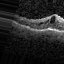

In [16]:
# look at an image
array_to_img(train_images[0])

In [17]:
# label returning 1, meaning the corresponding image is labeled as DME (index 1)
print(train_labels[0])

1.0


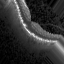

In [18]:
# look at an image
array_to_img(train_images[3])

In [19]:
# label returning 3, meaning the corresponding image is labeled as normal (index 3)
print(train_labels[3])

3.0


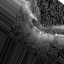

In [20]:
# look at an image
array_to_img(train_images[6])

In [21]:
# label returning 0, meaning the corresponding image is labeled as CNV (index 0)
print(train_labels[6])

0.0


The images look good, they are in black and white, and scaled down to 64x64. 

Here, I'd like to point out that again this was originally a multiclass classification task. There are several notebooks exploring building mutliclass models, please refer to them for more details on multiclass. You can find them in the code folder. 

For this notebook, I will explore a binary classification: are the images normal, or are they abnormal (where abnormal is any CNV, DME, or Drusen images). 

# Creating Binary Labels
<hr style="border:2px solid pink">

Here, I'd like to change the labels from multiclass (4 classes) to binary class (2 classes). This approach has both limitations and advantages; we lose the individuality between the different diseases, but we gain increased accuracy at identifying diseased vs normal images.  

I will group any image that is CNV, DME, and Drusen under "abnormal", and any image that is normal under "normal". Since the model will always try to predict class 1, it's important to consider the business problem and the overall goal of the model before assigning classes. 

My goal here is to catch abnormalities. It is better to flag an image as abnormal and have the patient come in for another scan than to flag an image as normal when there was actually a disease present. So, it would make sense to have abnormalities as class 1 and normal as class 0. 

I will also prioritize recall - high recall in medical diagnostics means the model is effectively identifying most of the actual abnormalities, which reduces false negatives. This is vital in reducing the number of missed diagnoses. 

First, let's check out the distribution of normal vs abnormal images. 

In [22]:
# check the distribution
abnormal_count = cnv_count + dme_count + drusen_count
print(f'Abnormal Count: {abnormal_count}')
print(f'Abnormal Distribution: {round((abnormal_count/(abnormal_count + normal_count)*100))}%')
print('------------------------')
print(f'Normal Count: {normal_count}')
print(f'Normal Distribution: {round((normal_count/(abnormal_count + normal_count)*100))}%')

Abnormal Count: 57169
Abnormal Distribution: 68%
------------------------
Normal Count: 26315
Normal Distribution: 32%


I see here that 68% of the data is abnormal, and 32% of the data is normal. This means my model might try and predict the majority class every time, and be 68% accurate at it. I will, in some of the later models, adjust the class weights to counter this. In the meantime, I will be cautious of high accuracy scores. 

Now, let's change the labels. First, let me remind myself what the current classes are so I can make sure I correctly change them. 

In [23]:
train_generator.class_indices

{'CNV': 0, 'DME': 1, 'DRUSEN': 2, 'NORMAL': 3}

Great. To change the labels, I will simply replace any value with index 3 (corresponding to normal) with a 0 (to correspond to class 0), and anything else with a 1 (so CNV, DME, and Drusen, or the abnormalities, will be class 1). 

In [24]:
# change for train, test, and val
# np.where changes the values so that anything index 3 is turned into 0 and everything else is a 1
binary_train_labels = np.where(train_labels == 3, 0, 1)
binary_test_labels = np.where(test_labels == 3, 0, 1)
binary_val_labels = np.where(val_labels == 3, 0, 1)

To confirm it worked, I will look at a few images and their new vs old labels to make sure they line up. 

Let's look at a normal image first. The old label should have index 3 marked, and the new labels should be class 0. 

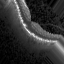

In [25]:
# look at an image
array_to_img(train_images[3])

In [26]:
# original label
# returning 3, so this is normal. should be class 0 in binary
print(train_labels[3])

3.0


In [27]:
# binary label
print(binary_train_labels[3])

0


Great! Let's do the same for DME. Should be class 1 in binary. 

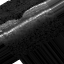

In [28]:
# look at an image
array_to_img(train_images[16])

In [29]:
# original label
# returning 1, so this is dme. should be class 1 in binary
print(train_labels[16])

1.0


In [30]:
# binary label
print(binary_train_labels[16])

1


Great! Next up is CNV, should be class 1 in binary. 

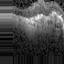

In [31]:
# look at an image
array_to_img(train_images[1])

In [32]:
# original label
# returning 0, so this is cnv. should be class 1 in binary
print(train_labels[1])

0.0


In [33]:
# binary label
print(binary_train_labels[1])

1


Finally, let's look at Drusen, should also be class 1 in binary. 

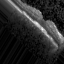

In [34]:
# look at an image
array_to_img(train_images[87])

In [35]:
# original label
# returning 2, so this is drusen. should be class 1 in binary
print(train_labels[88])

2.0


In [36]:
# binary label
print(binary_train_labels[88])

1


Great! It looks like the labels are correctly updated. I'll use these moving forward. 

Next, let's build some helper functions to help with the modeling process. 

# Creating Helper Functions
<hr style="border:2px solid pink">

I will build the following helper functions to help speed up viewing the results of each model. 
1. A function that evaluates the model's train and test performance. 
2. A function to plot the loss and accuracy. 
3. A function to plot the ROC_AUC curve for each model.  
4. A function to plot the confusion matrix for each model. 

Let's start with the evaluate function. We'll print out the loss, accuracy, precision, and recall for both the train and test sets. 

In [37]:
# 1. a function that evaluates the train and test performance of the model
def evaluate_model(model):
    train_results = model.evaluate(train_images, binary_train_labels)
    test_results = model.evaluate(test_images, binary_test_labels)
    
    print(f'Training Loss: {train_results[0]:.3}')
    print(f'Training Accuracy: {train_results[1]:.3}')
    print(f'Training Precision: {train_results[2]:.3}')
    print(f'Training Recall: {train_results[3]:.3}')
          
    print('---------------------------')
    print(f'Testing Loss: {test_results[0]:.3}')
    print(f'Testing Accuracy: {test_results[1]:.3}')
    print(f'Testing Precision: {test_results[2]:.3}')
    print(f'Testing Recall: {test_results[3]:.3}')

Next, I'll create a function to plot the loss and accuracy for each model. 

In [38]:
# 2. a function to plot the loss and accuracy
def plot_metrics(results):
    train_loss = results.history['loss']
    train_accuracy = results.history['accuracy']

    val_loss = results.history['val_loss']
    val_accuracy = results.history['val_accuracy']

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
    sns.lineplot(x=results.epoch, y=train_accuracy, ax=ax2, label='train_accuracy')

    sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
    sns.lineplot(x=results.epoch, y=val_accuracy, ax=ax2, label='val_accuracy')
    
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')

    plt.tight_layout()
    plt.show();

Next, a function to plot the ROC-AUC curve for the test set.  

In [39]:
# A function to plot the ROC_AUC curve for each model
def plot_roc(model, model_name):
    model_preds = model.predict(test_images)
    fpr, tpr, _ = roc_curve(binary_test_labels, model_preds)
    roc_auc = roc_auc_score(binary_test_labels, model_preds)
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=model_name)
    roc_display.plot();

Finally, a function to plot the models confusion matrix. I will note that these confusion matrices represent 1 batch from the test set, not the entire set. 

In [40]:
# A function to plot the confusion matrix for each model
def plot_cm(model):
    threshold = 0.5
    model_preds = model.predict(test_images)
    binary_preds = (np.array(model_preds) > threshold).astype(int)

    cm = confusion_matrix(binary_test_labels, binary_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Abnormal'])
    disp.plot(cmap='plasma')

Please note: the confusion matrix will only show the results per batch as was loaded in using image data generator. There is a way to use the entire test generator instead, but I couldn't get it to work once I changed the model to binary (still a work in progress).

Please interpret the confusion matrix as follows: this represents a sample of what the entire dataset looks like, it is an indication of what direction the model is heading towards. 

# Baseline model
<hr style="border:2px solid pink">

For my baseline model, I will use the class distribution. Let's compare abnormal (CNV, DRUSEN, DME) and normal.

In [41]:
abnormal_count = cnv_count + dme_count + drusen_count
print(f'Abnormal Count: {abnormal_count}')
print(f'Abnormal Distribution: {round((abnormal_count/(abnormal_count + normal_count)*100))}%')
print('------------------------')
print(f'Normal Count: {normal_count}')
print(f'Normal Distribution: {round((normal_count/(abnormal_count + normal_count)*100))}%')

Abnormal Count: 57169
Abnormal Distribution: 68%
------------------------
Normal Count: 26315
Normal Distribution: 32%


So 68% abnormal, 32% normal. This means that, if you were to predict just the majority class every time (which in this case is having an abnormality), the model would be accurate 68% of the time. This is the accuracy that we need to beat!

Let's get started with the modeling!

# First Simple Model
<hr style="border:2px solid pink">

For my first simple model, I will use a simple convolutional neural network with no hidden convolutional layers. I will begin with a dense input layer, expecting grayscale images of size 64x64x1. The input layer will have 64 units and use the ReLU activation function to introduce non-linearity and capture complex features. Next, I will add a flatten layer to transform the output from the previous layer into a 1D vector, preparing it for the final output layer. The output layer will consist of a dense layer with 1 unit to represent the binary classes, and it will use the sigmoid activation function, which is a common choice for binary classification tasks.

In [42]:
# set the variable input_shape to save time/avoid typos throughout modeling
input_shape = (64, 64, 1)

In [43]:
# build the model
model_1 = Sequential()
model_1.add(Dense(64, activation='relu', input_shape=input_shape))
model_1.add(Flatten())
model_1.add(Dense(1, activation='sigmoid'))

Let's view the architecture of the model. 

In [44]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64, 64, 64)        128       
_________________________________________________________________
flatten (Flatten)            (None, 262144)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 262145    
Total params: 262,273
Trainable params: 262,273
Non-trainable params: 0
_________________________________________________________________


So we can see that there are a 262,273 parameters. Let's compile the model using the adam optimizer (Adam is a good starting choice because Adam is an adaptive learning rate optimization algorithm. It should help with a more efficient convergence), binary crossentropy as the loss (this is an appropriate choice for a binary classsification task), and accuracy, precision, and recall as the metrics. 

In [45]:
# set variables for precision and recall
precision = Precision()
recall = Recall()

In [46]:
# compile the model
model_1.compile(optimizer='adam',
                loss='binary_crossentropy', 
                metrics=['accuracy', precision, recall])

Finally, let's fit the model on the train set. I will use the following parameters: 
- Smaller batches of 100, meaning my model will process 100 training samples at a time before adjusting the weights. 
- 25 epochs: epochs specifies how many times the model will iterate over the entire dataset. 
- Validation split of 25%, so 25% of the training data will be set aside to test the model.

In [47]:
# set validation split = 25% of data, this is the holdout test set
model_1_results = model_1.fit(train_images, 
                              binary_train_labels, 
                              validation_split=0.25, 
                              batch_size=100,
                              epochs=25)

Epoch 1/25
12/12 [==============================] - 1s 69ms/step - loss: 0.6316 - accuracy: 0.6907 - precision: 0.7347 - recall: 0.9097 - val_loss: 0.6368 - val_accuracy: 0.6480 - val_precision: 0.6446 - val_recall: 0.9873
Epoch 2/25
12/12 [==============================] - 0s 28ms/step - loss: 0.5885 - accuracy: 0.7173 - precision: 0.7478 - recall: 0.9314 - val_loss: 0.6601 - val_accuracy: 0.6640 - val_precision: 0.6581 - val_recall: 0.9747
Epoch 3/25
12/12 [==============================] - 0s 34ms/step - loss: 0.5403 - accuracy: 0.7520 - precision: 0.7527 - recall: 0.9892 - val_loss: 0.6253 - val_accuracy: 0.6480 - val_precision: 0.6423 - val_recall: 1.0000
Epoch 4/25
12/12 [==============================] - 0s 37ms/step - loss: 0.5228 - accuracy: 0.7600 - precision: 0.7590 - recall: 0.9892 - val_loss: 0.7083 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 5/25
12/12 [==============================] - 0s 36ms/step - loss: 0.5135 - accuracy: 0.7573 - precisi

Great! Let's evaluate the scores. 

In [48]:
evaluate_model(model_1)

4/4 [==============================] - 0s 10ms/step - loss: 0.8523 - accuracy: 0.6900 - precision: 0.7500 - recall: 0.8630
Training Loss: 0.318
Training Accuracy: 0.892
Training Precision: 0.877
Training Recall: 0.986
---------------------------
Testing Loss: 0.852
Testing Accuracy: 0.69
Testing Precision: 0.75
Testing Recall: 0.863


This is pretty overfit! We have a train accuracy of 89% and a test accuracy of 69%. Train precision is 88% and train recall is 99%, suggesting the model is doing a decent job at predicting abnormalities, and being correct at it. Testing precision and recall follow the same pattern, with respective scores of 75% and 86%. 

Let's visualize the loss and accuracy. 

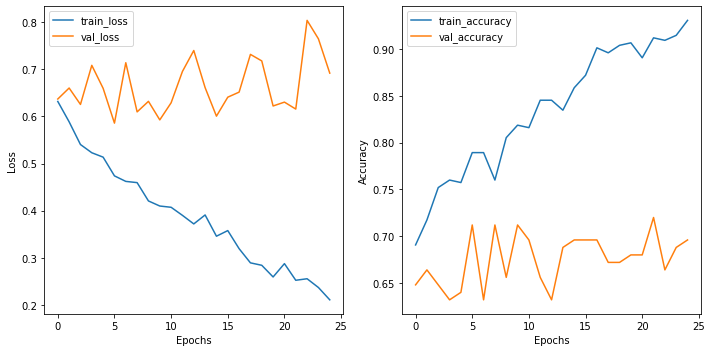

In [49]:
plot_metrics(model_1_results)

Here, we can see that the train loss is decreasing relatively steadily, but validation loss is jumping all over the place, suggesting unstable convergence. Both train and validation accuracy are fluctuating as well. I will try and smooth out those plots with upcoming models.

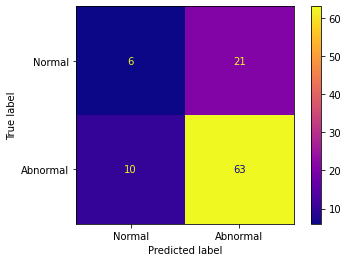

In [50]:
plot_cm(model_1)

The confusion matrix indicates that the model has a tendency to predict the majority class (abnormal) every time, with 6 true negatives, 10 false negatives, 21 false positives, and 63 true positives. Let's look at the AUC curve.

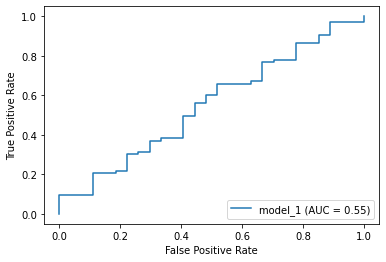

In [51]:
plot_roc(model_1, 'model_1')

We have an AUC score of 0.55, which suggests the model is not performing all that well. 

# Model #2
<hr style="border:2px solid pink">

My first simple model was very overfit. I know I will need to add regularization to address that, but first, let's try making it more complex and adding some hidden layers. I will start with adding convolutional and max pooling. 

In [52]:
model_2 = Sequential()

model_2.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=input_shape))
model_2.add(MaxPooling2D(pool_size=(2,2)))

model_2.add(Conv2D(64, (3, 3), activation='relu'))
model_2.add(MaxPooling2D(pool_size=(2,2)))

model_2.add(Flatten())
model_2.add(Dense(1, activation='sigmoid'))

model_2.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy', precision, recall])

model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 12544)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 12545     
Total params: 31,361
Trainable params: 31,361
Non-trainable params: 0
__________________________________________________

Here we have only 31,361 parameters, which is significantly fewer than the first model. Let's see how it does. 

In [53]:
model_2_results = model_2.fit(train_images, 
                              binary_train_labels, 
                              validation_split=0.25,
                              batch_size=100, 
                              epochs=25)

Epoch 1/25
4/4 [==============================] - 1s 286ms/step - loss: 0.6257 - accuracy: 0.7440 - precision: 0.7506 - recall: 0.9543 - val_loss: 0.7186 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 2/25
4/4 [==============================] - 1s 171ms/step - loss: 0.5939 - accuracy: 0.7387 - precision: 0.7387 - recall: 1.0000 - val_loss: 0.6679 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 3/25
4/4 [==============================] - 1s 188ms/step - loss: 0.5797 - accuracy: 0.7387 - precision: 0.7387 - recall: 1.0000 - val_loss: 0.6540 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 4/25
4/4 [==============================] - 1s 203ms/step - loss: 0.5818 - accuracy: 0.7387 - precision: 0.7387 - recall: 1.0000 - val_loss: 0.6565 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 5/25
4/4 [==============================] - 1s 194ms/step - loss: 0.5690 - accuracy: 0.7387 - precision: 0

In [54]:
evaluate_model(model_2)

4/4 [==============================] - 0s 20ms/step - loss: 0.4519 - accuracy: 0.8200 - precision: 0.8022 - recall: 1.0000
Training Loss: 0.456
Training Accuracy: 0.78
Training Precision: 0.767
Training Recall: 0.992
---------------------------
Testing Loss: 0.452
Testing Accuracy: 0.82
Testing Precision: 0.802
Testing Recall: 1.0


It appears my effort to make the model more complex backfired - train scores are much lower! Accuracy is at 78%, precision at 77%, and recall at 99%. Testing scores look okay, with accuracy at 82%, precision at 80%, and recall at 1%. Let's visualize the loss and accuracy functions. 

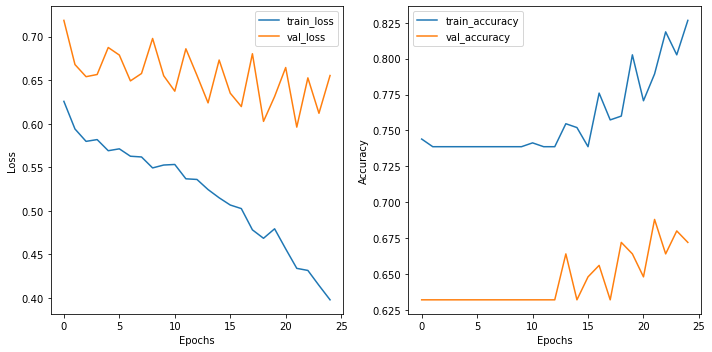

In [55]:
plot_metrics(model_2_results)

Not that great, train loss is still looking good, but validation loss and both train and validation accuracys are fluctutating quite a lot. Let's look at the confusion matrix and AUC score. 

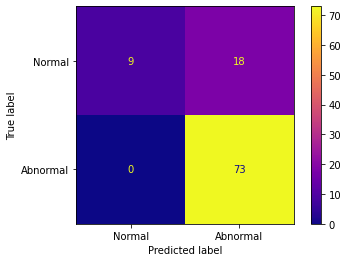

In [56]:
plot_cm(model_2)

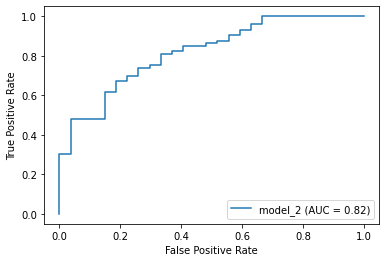

In [57]:
plot_roc(model_2, 'model_2')

This looks a little bit better actually! There are 9 true negatives, 0 false negatives, 18 false positives, and 73 true positives. Since our goal is to minimize false negatives, this seems to be successful. However, there are still quite a number of false positives, so the model could still be improved. 

The AUC score is 0.82, which is an improvement over the last model. 

# Model #3
<hr style="border:2px solid pink">

Let's try adding more complexity and see how it imapcts performance. I'll add some more convolutional and maxpooling layers, in addition to hidden dense layers after the flattening layer. My goal is to increase the number of parameters. 

In [58]:
model_3 = Sequential()

model_3.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=input_shape))
model_3.add(MaxPooling2D(pool_size=(2,2)))

model_3.add(Conv2D(64, (3, 3), activation='relu'))
model_3.add(MaxPooling2D(pool_size=(2,2)))

model_3.add(Conv2D(32, (3, 3), activation='relu'))
model_3.add(MaxPooling2D(pool_size=(2,2)))

model_3.add(Flatten())
model_3.add(Dense(32, activation='relu'))
model_3.add(Dense(16, activation='relu'))
model_3.add(Dense(1, activation='sigmoid'))

model_3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision, recall])

model_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 62, 62, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 12, 12, 32)        18464     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1152)             

This increased the parameters a little bit! We're up to 74,721. Let's see how it does. 

In [59]:
model_3_results = model_3.fit(train_images, 
                              binary_train_labels, 
                              validation_split=0.25,
                              batch_size=100, 
                              epochs=25)

Epoch 1/25
4/4 [==============================] - 2s 388ms/step - loss: 0.6658 - accuracy: 0.7387 - precision: 0.7511 - recall: 1.0000 - val_loss: 0.6596 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 2/25
4/4 [==============================] - 1s 191ms/step - loss: 0.6001 - accuracy: 0.7387 - precision: 0.7387 - recall: 1.0000 - val_loss: 0.6924 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 3/25
4/4 [==============================] - 1s 261ms/step - loss: 0.5898 - accuracy: 0.7387 - precision: 0.7387 - recall: 1.0000 - val_loss: 0.6566 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 4/25
4/4 [==============================] - 1s 247ms/step - loss: 0.5878 - accuracy: 0.7387 - precision: 0.7387 - recall: 1.0000 - val_loss: 0.6649 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 5/25
4/4 [==============================] - 1s 245ms/step - loss: 0.5858 - accuracy: 0.7387 - precision: 0

In [60]:
evaluate_model(model_3)

4/4 [==============================] - 0s 17ms/step - loss: 0.6002 - accuracy: 0.7300 - precision: 0.7300 - recall: 1.0000
Training Loss: 0.527
Training Accuracy: 0.712
Training Precision: 0.712
Training Recall: 1.0
---------------------------
Testing Loss: 0.6
Testing Accuracy: 0.73
Testing Precision: 0.73
Testing Recall: 1.0


That made the results worse all around! Training accuracy and precision dropped to 71%, and recall is at 100%, which seems a little too good to be true. Similarly, testing accuracy and precision dropped to 73% and recall is again at 100%. It's not overfit, but low 70s is not a great score. Let's visualize the loss and accuracy. 

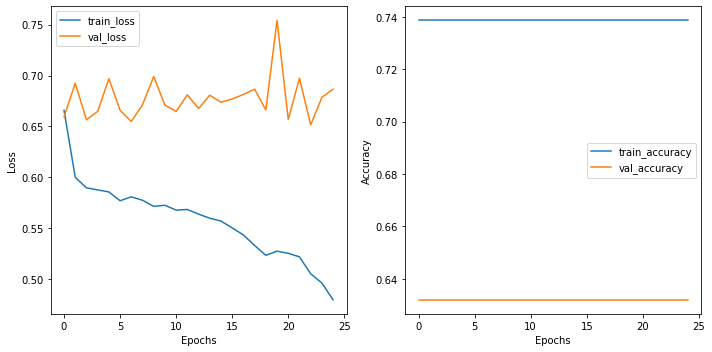

In [61]:
plot_metrics(model_3_results)

Both train and validation accuracy are stalled, not a great sign. Loss is jumping all over the place still. Let's look at the confusion matrix and ROC curve. 

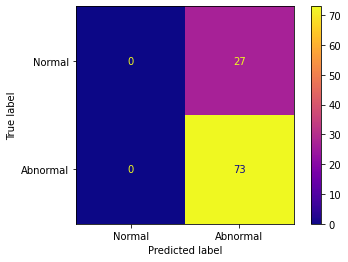

In [62]:
plot_cm(model_3)

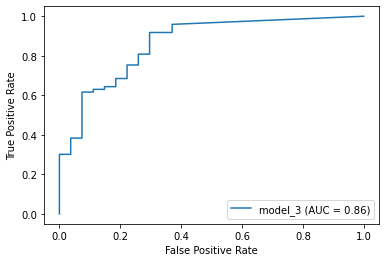

In [63]:
plot_roc(model_3, 'model_3')

It looks like the model is just predicting the majority class every time; there are 27 false positives, 73 true positives, and 0 true or false negatives. The AUC score of 0.86 is deceptively high. 

Let's try adding more complexity into the model by increasing all the input units. I'll keep the model the same as the previous one otherwise. 

# Model #4
<hr style="border:2px solid pink">

In [64]:
model_4 = Sequential()

model_4.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=input_shape))
model_4.add(MaxPooling2D(pool_size=(2,2)))

model_4.add(Conv2D(128, (3, 3), activation='relu')) # increased from 64 to 128
model_4.add(MaxPooling2D(pool_size=(2,2)))

model_4.add(Conv2D(64, (3, 3), activation='relu')) # increased from 32 to 64
model_4.add(MaxPooling2D(pool_size=(2,2)))

model_4.add(Flatten())
model_4.add(Dense(64, activation='relu')) # increased from 32 to 64
model_4.add(Dense(32, activation='relu')) # increased from 16 to 32
model_4.add(Dense(1, activation='sigmoid'))

model_4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision, recall])

model_4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 62, 62, 32)        320       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 29, 29, 128)       36992     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 12, 12, 64)        73792     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 2304)             

That successfully increased the parameters, so maybe this will help improve scores after all. Let's check it out. 

In [65]:
model_4_results = model_4.fit(train_images, 
                              binary_train_labels, 
                              validation_split=0.25,
                              batch_size=100, 
                              epochs=25)

Epoch 1/25
4/4 [==============================] - 1s 333ms/step - loss: 0.6501 - accuracy: 0.6160 - precision: 0.7349 - recall: 0.8000 - val_loss: 0.7038 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 2/25
4/4 [==============================] - 1s 237ms/step - loss: 0.5955 - accuracy: 0.7387 - precision: 0.7387 - recall: 1.0000 - val_loss: 0.6577 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 3/25
4/4 [==============================] - 1s 243ms/step - loss: 0.5901 - accuracy: 0.7387 - precision: 0.7387 - recall: 1.0000 - val_loss: 0.6569 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 4/25
4/4 [==============================] - 1s 235ms/step - loss: 0.5759 - accuracy: 0.7387 - precision: 0.7387 - recall: 1.0000 - val_loss: 0.6954 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 5/25
4/4 [==============================] - 1s 244ms/step - loss: 0.5830 - accuracy: 0.7387 - precision: 0

In [66]:
evaluate_model(model_4)

4/4 [==============================] - 0s 31ms/step - loss: 0.5306 - accuracy: 0.7400 - precision: 0.9123 - recall: 0.7123
Training Loss: 0.462
Training Accuracy: 0.802
Training Precision: 0.802
Training Recall: 0.958
---------------------------
Testing Loss: 0.531
Testing Accuracy: 0.74
Testing Precision: 0.912
Testing Recall: 0.712


That helped increase the training scores! Training accuracy and precision are both at 80%, and reacll is at 96%. Testing accuracy is at 74%, precision is at 91%, and recall is at 71%. Let's visualize the loss and accuracy: 

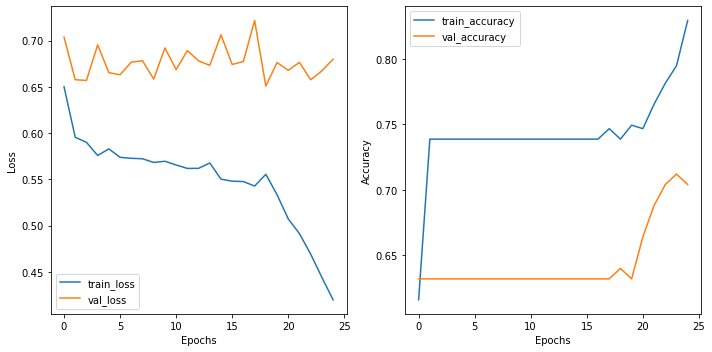

In [67]:
plot_metrics(model_4_results)

There's still a lot of fluctuation going, but not as drastically as some of the earlier models. Let's look at the confusion matrix and roc curve. 

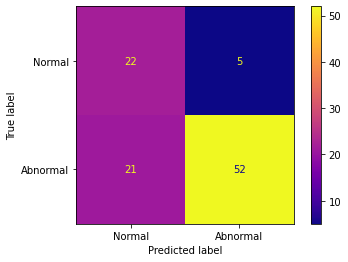

In [68]:
plot_cm(model_4)

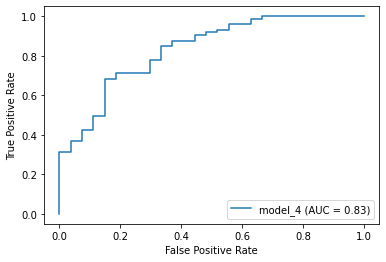

In [69]:
plot_roc(model_4, 'model_4')

This model doesn't seem to be doing a great job at minimizing the false negatives! We have 21 false negatives, 22 true negatives, 5 false positives, and 52 true positives. The AUC score is 0.83, which again, seems a little high. 

Since the last model was so very overfit, let's try adding in some regularization. 

# Model #5
<hr style="border:2px solid pink">

I'll start with just L2 regularization. L2, or Ridge regression, aims to reduce the impact of less important features by driving their coefficients closer to zero, essentially giving them less influence on the model's predictions. This will help prevent the model from memorizing the specific details of the training data, which in turn will help avoid overfitting. Overfitting occurs which  occurs when a model fits the training data too closely, capturing noise rather than the actual patterns. L2 regularization, by penalizing large coefficients, encourages a more generalized model that is better equipped to make accurate predictions on unseen data.

In [70]:
model_5 = Sequential()

model_5.add(Conv2D(filters=32, 
                        kernel_size=(3,3), 
                        activation='relu', 
                        input_shape=input_shape, 
                        kernel_regularizer=l2(0.01)))

model_5.add(MaxPooling2D(pool_size=(2,2)))

model_5.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.01)))
model_5.add(MaxPooling2D(pool_size=(2,2)))

model_5.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01)))
model_5.add(MaxPooling2D(pool_size=(2,2)))

model_5.add(Flatten())
model_5.add(Dense(64, activation='relu'))
model_5.add(Dense(32, activation='relu'))
model_5.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01)))

model_5.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision, recall])

model_5.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 62, 62, 32)        320       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 29, 29, 128)       36992     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 12, 12, 64)        73792     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 2304)             

Note that this did not change the number of parameters of the model. Let's see how it does. 

In [71]:
model_5_results = model_5.fit(train_images, 
                              binary_train_labels, 
                              validation_split=0.25,
                              batch_size=100, 
                              epochs=25)

Epoch 1/25
4/4 [==============================] - 2s 478ms/step - loss: 1.9808 - accuracy: 0.6507 - precision: 0.7703 - recall: 0.7857 - val_loss: 1.8276 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 2/25
4/4 [==============================] - 1s 305ms/step - loss: 1.7020 - accuracy: 0.7387 - precision: 0.7387 - recall: 1.0000 - val_loss: 1.6540 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 3/25
4/4 [==============================] - 1s 330ms/step - loss: 1.4919 - accuracy: 0.7387 - precision: 0.7387 - recall: 1.0000 - val_loss: 1.4520 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 4/25
4/4 [==============================] - 1s 345ms/step - loss: 1.3307 - accuracy: 0.7387 - precision: 0.7387 - recall: 1.0000 - val_loss: 1.3188 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 5/25
4/4 [==============================] - 1s 319ms/step - loss: 1.1952 - accuracy: 0.7387 - precision: 0

In [72]:
evaluate_model(model_5)

4/4 [==============================] - 0s 26ms/step - loss: 0.5927 - accuracy: 0.7300 - precision: 0.7300 - recall: 1.0000
Training Loss: 0.623
Training Accuracy: 0.712
Training Precision: 0.712
Training Recall: 1.0
---------------------------
Testing Loss: 0.593
Testing Accuracy: 0.73
Testing Precision: 0.73
Testing Recall: 1.0


These are just about the same results are the third model. Interesting! Let's look at the loss and accuracy. 

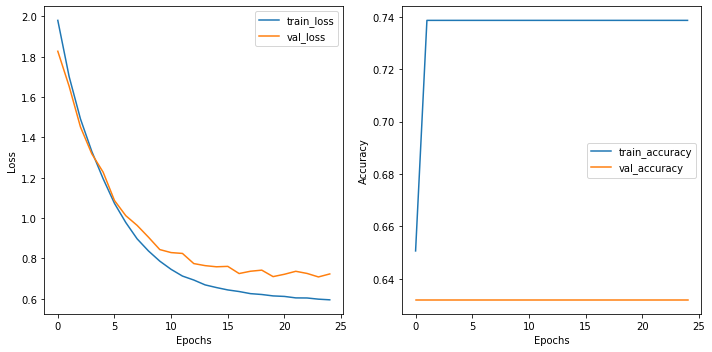

In [73]:
plot_metrics(model_5_results)

It's a shame that the scores aren't that great because look at the loss function!! Accuracy on the other hand is kind of stalled for both train and validation. 

Maybe the strength of the regularizer was too much. Let's look at the confusion matrix and roc curve, then adjust regularization. 

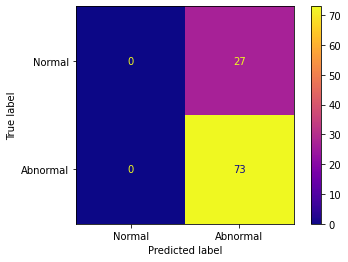

In [74]:
plot_cm(model_5)

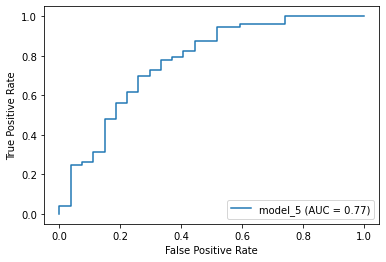

In [75]:
plot_roc(model_5, 'model_5')

Just like the 3rd model, this model seems to be just predicting the majority class every time. Let's try adjusting regularization and see if it improves scores. 

# Model #6
<hr style="border:2px solid pink">

I will remove regularization from the inner layers, and decrease the strength on both the input and output layers.

In [76]:
model_6 = Sequential()

model_6.add(Conv2D(filters=32, 
                        kernel_size=(3,3), 
                        activation='relu', 
                        input_shape=input_shape, 
                        kernel_regularizer=l2(0.0001)))

model_6.add(MaxPooling2D(pool_size=(2,2)))

model_6.add(Conv2D(128, (3, 3), activation='relu'))
model_6.add(MaxPooling2D(pool_size=(2,2)))

model_6.add(Conv2D(64, (3, 3), activation='relu'))
model_6.add(MaxPooling2D(pool_size=(2,2)))

model_6.add(Flatten())
model_6.add(Dense(64, activation='relu'))
model_6.add(Dense(32, activation='relu'))
model_6.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.0001)))

model_6.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision, recall])

model_6.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 62, 62, 32)        320       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 29, 29, 128)       36992     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 12, 12, 64)        73792     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 2304)             

Still the same number of parameters. Let's see how it does. 

In [77]:
model_6_results = model_6.fit(train_images, 
                              binary_train_labels, 
                              validation_split=0.25,
                              batch_size=100, 
                              epochs=25)

Epoch 1/25
4/4 [==============================] - 2s 597ms/step - loss: 0.6312 - accuracy: 0.7387 - precision: 0.7368 - recall: 1.0000 - val_loss: 0.7238 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 2/25
4/4 [==============================] - 2s 421ms/step - loss: 0.5926 - accuracy: 0.7387 - precision: 0.7387 - recall: 1.0000 - val_loss: 0.6593 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 3/25
4/4 [==============================] - 2s 449ms/step - loss: 0.5849 - accuracy: 0.7387 - precision: 0.7387 - recall: 1.0000 - val_loss: 0.6657 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 4/25
4/4 [==============================] - 2s 503ms/step - loss: 0.5813 - accuracy: 0.7387 - precision: 0.7387 - recall: 1.0000 - val_loss: 0.6930 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 5/25
4/4 [==============================] - 2s 415ms/step - loss: 0.5932 - accuracy: 0.7387 - precision: 0

In [78]:
evaluate_model(model_6)

4/4 [==============================] - 0s 25ms/step - loss: 0.4229 - accuracy: 0.8100 - precision: 0.8375 - recall: 0.9178
Training Loss: 0.551
Training Accuracy: 0.764
Training Precision: 0.753
Training Recall: 0.994
---------------------------
Testing Loss: 0.423
Testing Accuracy: 0.81
Testing Precision: 0.837
Testing Recall: 0.918


That helped a little bit! Testing scores look a lot better, but it looks like the model is now slightly underfit. Let's look at the loss and accuracy. 

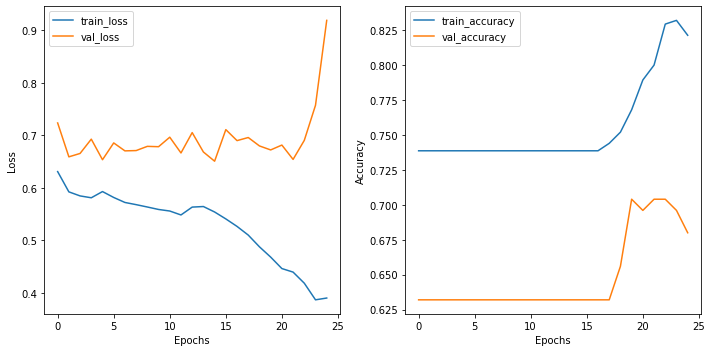

In [79]:
plot_metrics(model_6_results)

Still not much of an improvement. I wonder if adding in batch normalization would help the jumping around. Let's look at the confusion matrix and roc curve, then test it out. 

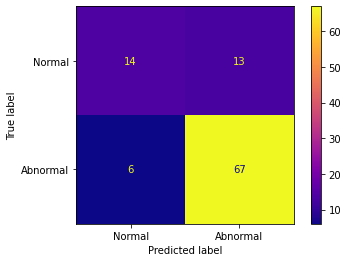

In [80]:
plot_cm(model_6)

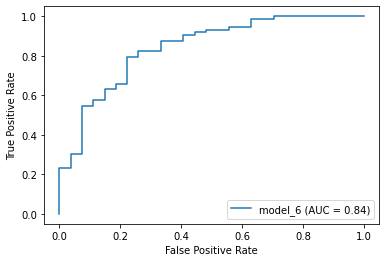

In [81]:
plot_roc(model_6, 'model_6')

This model seems to be doing a little better at minimizing false negatives, which is good! AUC score is 0.84, which seems decent given the other metrics. Let's get started with the next model and testingo out batch normalization. 

# Model #7
<hr style="border:2px solid pink">

Batch Normalization is used to help improve training efficiency and stability. It aims to normalize the inputs of each layer in mini-batches by calculating the mean and standard deviation, then scales and shifts the values using learnable parameters. It's used after the activation function to help improve training stability. 

I'll start with adding it after every activation function. 

In [82]:
model_7 = Sequential()

model_7.add(Conv2D(filters=32, 
                        kernel_size=(3,3), 
                        activation='relu', 
                        input_shape=input_shape, 
                        kernel_regularizer=l2(0.0001)))
model_7.add(BatchNormalization())
model_7.add(MaxPooling2D(pool_size=(2,2)))

model_7.add(Conv2D(128, (3, 3), activation='relu'))
model_7.add(BatchNormalization())
model_7.add(MaxPooling2D(pool_size=(2,2)))

model_7.add(Conv2D(64, (3, 3), activation='relu'))
model_7.add(BatchNormalization())
model_7.add(MaxPooling2D(pool_size=(2,2)))

model_7.add(Flatten())
model_7.add(Dense(64, activation='relu'))
model_7.add(Dense(32, activation='relu'))
model_7.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.0001)))

model_7.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision, recall])

model_7.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 62, 62, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 62, 62, 32)        128       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 29, 29, 128)       36992     
_________________________________________________________________
batch_normalization_1 (Batch (None, 29, 29, 128)       512       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 12, 12, 64)       

That added a few more parameters, we're up to 261,633. Let's see how it does.  

In [83]:
model_7_results = model_7.fit(train_images, 
                              binary_train_labels, 
                              validation_split=0.25,
                              batch_size=100, 
                              epochs=25)

Epoch 1/25
4/4 [==============================] - 2s 621ms/step - loss: 0.8868 - accuracy: 0.6480 - precision: 0.7506 - recall: 0.8514 - val_loss: 0.6930 - val_accuracy: 0.4560 - val_precision: 0.6774 - val_recall: 0.2658
Epoch 2/25
4/4 [==============================] - 2s 591ms/step - loss: 0.5012 - accuracy: 0.7787 - precision: 0.8170 - recall: 0.9025 - val_loss: 0.6925 - val_accuracy: 0.5680 - val_precision: 0.6582 - val_recall: 0.6582
Epoch 3/25
4/4 [==============================] - 2s 587ms/step - loss: 0.4039 - accuracy: 0.7973 - precision: 0.7847 - recall: 1.0000 - val_loss: 0.6782 - val_accuracy: 0.6000 - val_precision: 0.6239 - val_recall: 0.9241
Epoch 4/25
4/4 [==============================] - 3s 696ms/step - loss: 0.3136 - accuracy: 0.8880 - precision: 0.8983 - recall: 0.9567 - val_loss: 0.6648 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 5/25
4/4 [==============================] - 3s 715ms/step - loss: 0.2385 - accuracy: 0.9147 - precision: 0

In [84]:
evaluate_model(model_7)

4/4 [==============================] - 0s 27ms/step - loss: 0.9345 - accuracy: 0.7300 - precision: 0.7300 - recall: 1.0000
Training Loss: 1.09
Training Accuracy: 0.712
Training Precision: 0.712
Training Recall: 1.0
---------------------------
Testing Loss: 0.935
Testing Accuracy: 0.73
Testing Precision: 0.73
Testing Recall: 1.0


These are just about the same results as the 3rd and 5th models. Maybe putting it after every activation function was too intense with such a simple model. Let's try removing 2 of the 3 batch normalizers and see if it helps. But first, let's take a look at the loss and accuracy, confusion matrix, and roc curve. 

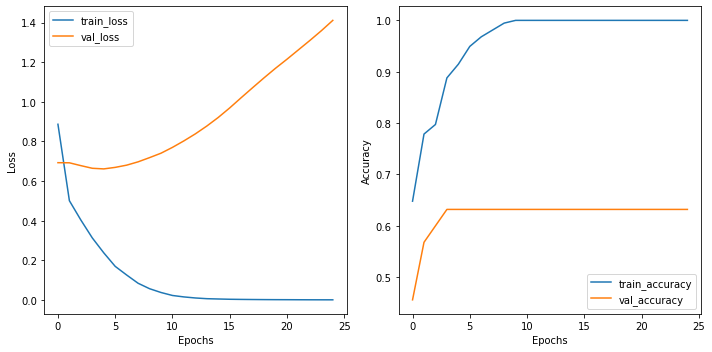

In [85]:
plot_metrics(model_7_results)

Not great! At least they're not jumping all over the place, but the loss function is kind of doing the opposite of what it's meant to do and swooping upwards.

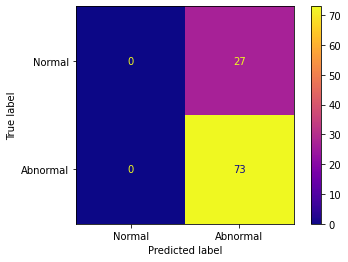

In [86]:
plot_cm(model_7)

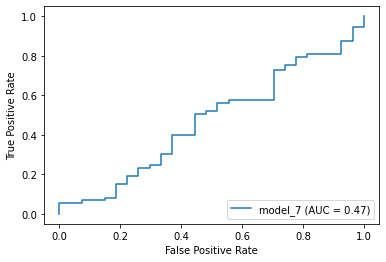

In [87]:
plot_roc(model_7, 'model_7')

Once again, the model is just predicting the majority class. The AUC score of 0.47 is the worst one yet! Let's take some of the batch normalization out and see if it helps. 

# Model #8
<hr style="border:2px solid pink">

Here, I will remove all batch normalization except for the first one.

In [88]:
model_8 = Sequential()

model_8.add(Conv2D(filters=32, 
                        kernel_size=(3,3), 
                        activation='relu', 
                        input_shape=input_shape, 
                        kernel_regularizer=l2(0.0001)))
model_8.add(BatchNormalization())
model_8.add(MaxPooling2D(pool_size=(2,2)))

model_8.add(Conv2D(128, (3, 3), activation='relu'))
model_8.add(MaxPooling2D(pool_size=(2,2)))

model_8.add(Conv2D(64, (3, 3), activation='relu'))
model_8.add(MaxPooling2D(pool_size=(2,2)))

model_8.add(Flatten())
model_8.add(Dense(64, activation='relu'))
model_8.add(Dense(32, activation='relu'))
model_8.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.0001)))

model_8.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision, recall])

model_8.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 62, 62, 32)        320       
_________________________________________________________________
batch_normalization_3 (Batch (None, 62, 62, 32)        128       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 29, 29, 128)       36992     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 12, 12, 64)        73792     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 6, 6, 64)         

This decreased the parameters slightly, from 261,633 to 260,856. Let's see how it does. 

In [89]:
model_8_results = model_8.fit(train_images, 
                              binary_train_labels, 
                              validation_split=0.25,
                              batch_size=100, 
                              epochs=25)

Epoch 1/25
4/4 [==============================] - 2s 493ms/step - loss: 0.6905 - accuracy: 0.5787 - precision: 0.7200 - recall: 0.7714 - val_loss: 0.6838 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 2/25
4/4 [==============================] - 2s 422ms/step - loss: 0.5881 - accuracy: 0.7387 - precision: 0.7387 - recall: 1.0000 - val_loss: 0.6817 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 3/25
4/4 [==============================] - 2s 399ms/step - loss: 0.5768 - accuracy: 0.7387 - precision: 0.7387 - recall: 1.0000 - val_loss: 0.6823 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 4/25
4/4 [==============================] - 2s 384ms/step - loss: 0.5592 - accuracy: 0.7387 - precision: 0.7387 - recall: 1.0000 - val_loss: 0.6828 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 5/25
4/4 [==============================] - 2s 411ms/step - loss: 0.5398 - accuracy: 0.7387 - precision: 0

In [90]:
evaluate_model(model_8)

4/4 [==============================] - 0s 28ms/step - loss: 0.5426 - accuracy: 0.7300 - precision: 0.7300 - recall: 1.0000
Training Loss: 0.562
Training Accuracy: 0.716
Training Precision: 0.715
Training Recall: 1.0
---------------------------
Testing Loss: 0.543
Testing Accuracy: 0.73
Testing Precision: 0.73
Testing Recall: 1.0


Still getting roughly the same scores, intersting. The fact that the training score is only 71% means that there seems to be high bias in the model, so adding in more complexity could help. 

Let's look at the loss, accuracy, confusion matrix, and roc curve first. 

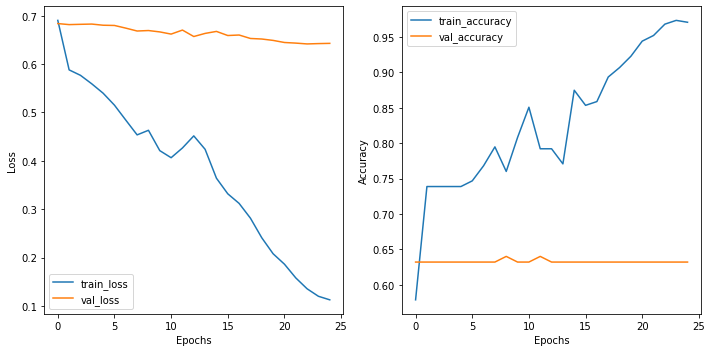

In [91]:
plot_metrics(model_8_results)

Still not great, but both loss and accuracy are jumping around with less intensity. The validation scores are kind of stalled however. I wonder if the changing the activation function would help. 

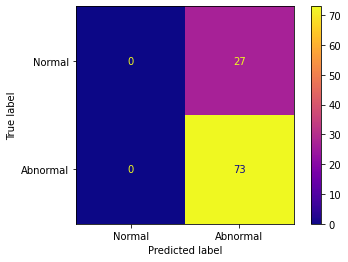

In [92]:
plot_cm(model_8)

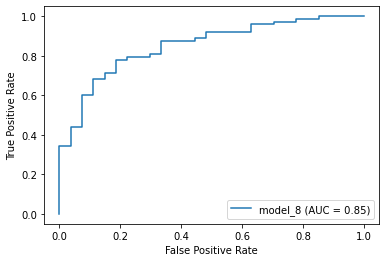

In [93]:
plot_roc(model_8, 'model_8')

Once again, the model is predicting the majority class every time. I have a few more ideas I want to try, then it could be worth it to adjust the class weights. 

# Model #9
<hr style="border:2px solid pink">

Let's play around with the different activation functions. I've been using relu for all previous models, but let's see how tanh and sigmoid do. Let's use the last model as reference. 

In [94]:
model_9 = Sequential()

model_9.add(Conv2D(filters=32, 
                        kernel_size=(3,3), 
                        activation='tanh', 
                        input_shape=input_shape, 
                        kernel_regularizer=l2(0.0001)))
model_9.add(BatchNormalization())
model_9.add(MaxPooling2D(pool_size=(2,2)))

model_9.add(Conv2D(128, (3, 3), activation='tanh'))
model_9.add(MaxPooling2D(pool_size=(2,2)))

model_9.add(Conv2D(64, (3, 3), activation='tanh'))
model_9.add(MaxPooling2D(pool_size=(2,2)))

model_9.add(Flatten())
model_9.add(Dense(64, activation='tanh'))
model_9.add(Dense(32, activation='tanh'))
model_9.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.0001)))

model_9.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision, recall])

model_9.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 62, 62, 32)        320       
_________________________________________________________________
batch_normalization_4 (Batch (None, 62, 62, 32)        128       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 29, 29, 128)       36992     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 12, 12, 64)        73792     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 6, 6, 64)         

In [95]:
model_9_results = model_9.fit(train_images, 
                              binary_train_labels, 
                              validation_split=0.25,
                              batch_size=100, 
                              epochs=25)

Epoch 1/25
4/4 [==============================] - 2s 481ms/step - loss: 0.7210 - accuracy: 0.6853 - precision: 0.7435 - recall: 0.8943 - val_loss: 0.6552 - val_accuracy: 0.6320 - val_precision: 0.6460 - val_recall: 0.9241
Epoch 2/25
4/4 [==============================] - 1s 374ms/step - loss: 0.5872 - accuracy: 0.7227 - precision: 0.7370 - recall: 0.9711 - val_loss: 0.6526 - val_accuracy: 0.6400 - val_precision: 0.6371 - val_recall: 1.0000
Epoch 3/25
4/4 [==============================] - 2s 402ms/step - loss: 0.5593 - accuracy: 0.7387 - precision: 0.7399 - recall: 0.9964 - val_loss: 0.6813 - val_accuracy: 0.5760 - val_precision: 0.6477 - val_recall: 0.7215
Epoch 4/25
4/4 [==============================] - 2s 421ms/step - loss: 0.5420 - accuracy: 0.7440 - precision: 0.7426 - recall: 1.0000 - val_loss: 0.7180 - val_accuracy: 0.4880 - val_precision: 0.6364 - val_recall: 0.4430
Epoch 5/25
4/4 [==============================] - 2s 433ms/step - loss: 0.5346 - accuracy: 0.7440 - precision: 0

In [96]:
evaluate_model(model_9)

4/4 [==============================] - 0s 29ms/step - loss: 0.5511 - accuracy: 0.7400 - precision: 0.8052 - recall: 0.8493
Training Loss: 0.548
Training Accuracy: 0.76
Training Precision: 0.883
Training Recall: 0.764
---------------------------
Testing Loss: 0.551
Testing Accuracy: 0.74
Testing Precision: 0.805
Testing Recall: 0.849


This is slightly better than previous results. The model is not significantly overfit, but scores are just so-so. Training accuracy is 76%, precision is 88%, and recall is 76%, while testing accuracy is 74%, precision is 81%, and recall is 85%. Tanh might be a little more stable than relu for this task. 

Let's take a look at the loss and accuracy, confusion matrix, and roc curve. 

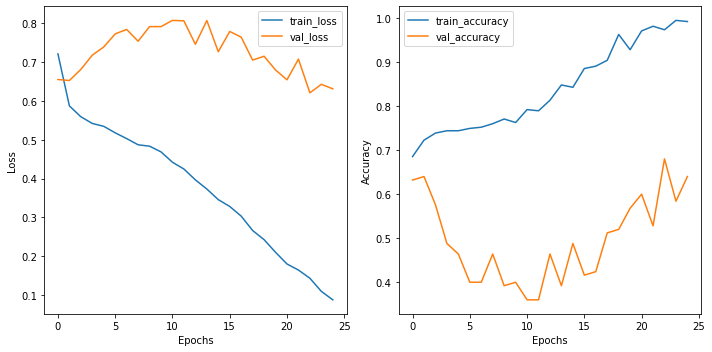

In [97]:
plot_metrics(model_9_results)

Loss and accuracy are still jumping around, but at least they're mostly curving in the general right direction. 

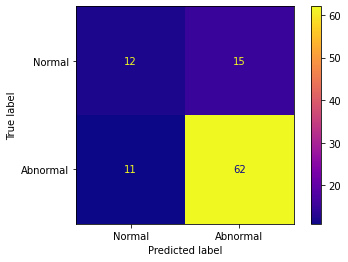

In [98]:
plot_cm(model_9)

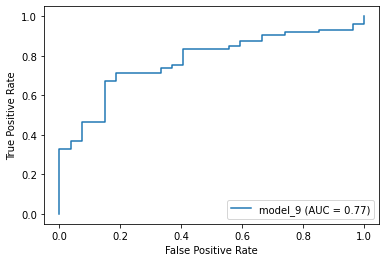

In [99]:
plot_roc(model_9, 'model_9')

We have 12 true negatives, 11 false negatives, 15 false positives, 62 true positives, and an AUC score of 0.77. This suggests that the model is performing averagely. Let's see how sigmoid activation does instead. 

# Model #10
<hr style="border:2px solid pink">

In [100]:
model_10 = Sequential()

model_10.add(Conv2D(filters=32, 
                        kernel_size=(3,3), 
                        activation='sigmoid', 
                        input_shape=input_shape, 
                        kernel_regularizer=l2(0.0001)))
model_10.add(BatchNormalization())
model_10.add(MaxPooling2D(pool_size=(2,2)))

model_10.add(Conv2D(128, (3, 3), activation='sigmoid'))
model_10.add(MaxPooling2D(pool_size=(2,2)))

model_10.add(Conv2D(64, (3, 3), activation='sigmoid'))
model_10.add(MaxPooling2D(pool_size=(2,2)))

model_10.add(Flatten())
model_10.add(Dense(64, activation='sigmoid'))
model_10.add(Dense(32, activation='sigmoid'))
model_10.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.0001)))

model_10.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision, recall])

model_10.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_23 (Conv2D)           (None, 62, 62, 32)        320       
_________________________________________________________________
batch_normalization_5 (Batch (None, 62, 62, 32)        128       
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 29, 29, 128)       36992     
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 12, 12, 64)        73792     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 6, 6, 64)         

In [101]:
model_10_results = model_10.fit(train_images, 
                              binary_train_labels, 
                              validation_split=0.25,
                              batch_size=100, 
                              epochs=25)

Epoch 1/25
4/4 [==============================] - 2s 486ms/step - loss: 0.6007 - accuracy: 0.7387 - precision: 0.7500 - recall: 0.9686 - val_loss: 0.7393 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 2/25
4/4 [==============================] - 2s 384ms/step - loss: 0.5877 - accuracy: 0.7387 - precision: 0.7387 - recall: 1.0000 - val_loss: 0.6892 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 3/25
4/4 [==============================] - 2s 391ms/step - loss: 0.5760 - accuracy: 0.7387 - precision: 0.7387 - recall: 1.0000 - val_loss: 0.6761 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 4/25
4/4 [==============================] - 2s 429ms/step - loss: 0.5763 - accuracy: 0.7387 - precision: 0.7387 - recall: 1.0000 - val_loss: 0.6818 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 5/25
4/4 [==============================] - 2s 431ms/step - loss: 0.5752 - accuracy: 0.7387 - precision: 0

In [102]:
evaluate_model(model_10)

4/4 [==============================] - 0s 31ms/step - loss: 0.5838 - accuracy: 0.7300 - precision: 0.7300 - recall: 1.0000
Training Loss: 0.603
Training Accuracy: 0.712
Training Precision: 0.712
Training Recall: 1.0
---------------------------
Testing Loss: 0.584
Testing Accuracy: 0.73
Testing Precision: 0.73
Testing Recall: 1.0


About the same scores as some of the previous models. So sigmoid is not necessarily better than relu. Let's stick with relu or tanh. 

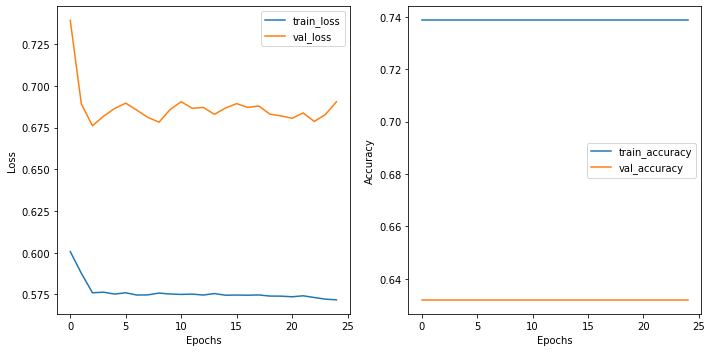

In [103]:
plot_metrics(model_10_results)

Loss and accuracy are both kind of stalled, maybe adding in some complexity and introducing early stopping to help the overfitting would help. First, let's look at the confusion matrix and roc curve.  

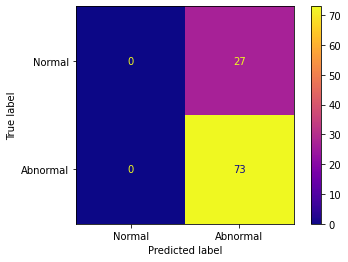

In [104]:
plot_cm(model_10)

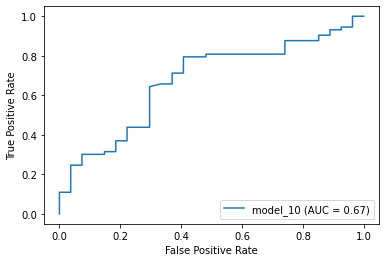

In [105]:
plot_roc(model_10, 'model_10')

Unsurprisingly, the model is just predicting the majority class. Let's move on. 

# Model #11
<hr style="border:2px solid pink">

I'll add complexity by adding an additional hidden dense layer, and increasing the filters in the input layer to 64. 

In some of the earlier iterations, I noticed that the scores for the last few epochs remained constant. To address this, I am going to try using early stopping in my training process. Early stopping is when the model continuously monitors the validation loss (or whatever you would like to monitor), and if there is no improvement over a specified number of consecutive epochs (known as the patience), the training process is stopped. This helps prevent overfitting. 

In [106]:
# we will monitor the validation loss
# when it stops decreasing, wait 3 epochs before stopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=3)

In [107]:
model_11 = Sequential()

model_11.add(Conv2D(filters=64, 
                        kernel_size=(3,3), 
                        activation='relu', 
                        input_shape=input_shape, 
                        kernel_regularizer=l2(0.0001)))

model_11.add(MaxPooling2D(pool_size=(2,2)))

model_11.add(Conv2D(128, (3, 3), activation='relu'))
model_11.add(MaxPooling2D(pool_size=(2,2)))

model_11.add(Conv2D(64, (3, 3), activation='relu'))
model_11.add(MaxPooling2D(pool_size=(2,2)))

model_11.add(Flatten())
model_11.add(Dense(128, activation='relu'))
model_11.add(Dense(64, activation='relu'))
model_11.add(Dense(32, activation='relu'))
model_11.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.0001)))

model_11.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision, recall])

model_11.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 62, 62, 64)        640       
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 29, 29, 128)       73856     
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 12, 12, 64)        73792     
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 2304)            

We've successfully added more parameters! Let's see how this model does with the added complexity and early stopping implemented. 

In [108]:
model_11_results = model_11.fit(train_images, 
                              binary_train_labels, 
                              validation_split=0.25,
                              batch_size=100, 
                              epochs=25,
                              callbacks=early_stop)

Epoch 1/25
4/4 [==============================] - 2s 620ms/step - loss: 0.6837 - accuracy: 0.5947 - precision: 0.7280 - recall: 0.7800 - val_loss: 0.6591 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 2/25
4/4 [==============================] - 2s 488ms/step - loss: 0.6089 - accuracy: 0.7387 - precision: 0.7387 - recall: 1.0000 - val_loss: 0.6902 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 3/25
4/4 [==============================] - 2s 463ms/step - loss: 0.5919 - accuracy: 0.7387 - precision: 0.7387 - recall: 1.0000 - val_loss: 0.6557 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 4/25
4/4 [==============================] - 2s 463ms/step - loss: 0.5860 - accuracy: 0.7387 - precision: 0.7387 - recall: 1.0000 - val_loss: 0.6747 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 5/25
4/4 [==============================] - 2s 429ms/step - loss: 0.5798 - accuracy: 0.7387 - precision: 0

In [109]:
evaluate_model(model_11)

4/4 [==============================] - 0s 38ms/step - loss: 0.5652 - accuracy: 0.7300 - precision: 0.7300 - recall: 1.0000
Training Loss: 0.598
Training Accuracy: 0.712
Training Precision: 0.712
Training Recall: 1.0
---------------------------
Testing Loss: 0.565
Testing Accuracy: 0.73
Testing Precision: 0.73
Testing Recall: 1.0


No changes! How interesting.. Let's look at our plots. 

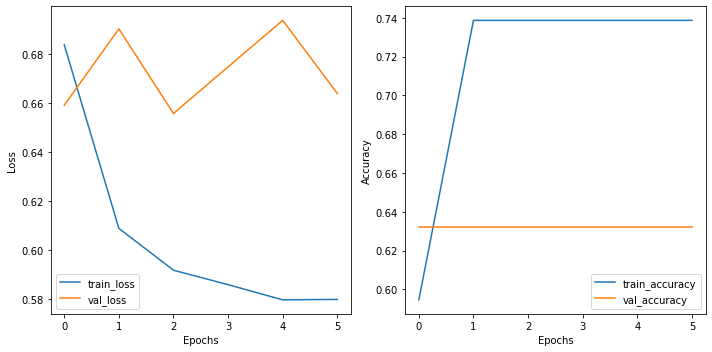

In [110]:
plot_metrics(model_11_results)

The train loss looks great! But everything else, not so much. 

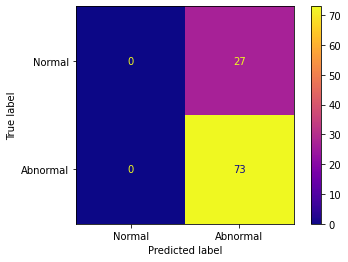

In [111]:
plot_cm(model_11)

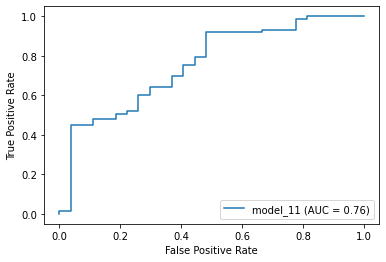

In [112]:
plot_roc(model_11, 'model_11')

The model is predicting the majority class every time, let's try using tanh instead of relu. 

# Model #12
<hr style="border:2px solid pink">

Same model, but let's use tanh instead since we saw slightly different results with it earlier. 

In [113]:
model_12 = Sequential()

model_12.add(Conv2D(filters=64, 
                        kernel_size=(3,3), 
                        activation='tanh', 
                        input_shape=input_shape, 
                        kernel_regularizer=l2(0.0001)))

model_12.add(MaxPooling2D(pool_size=(2,2)))

model_12.add(Conv2D(128, (3, 3), activation='tanh'))
model_12.add(MaxPooling2D(pool_size=(2,2)))

model_12.add(Conv2D(64, (3, 3), activation='tanh'))
model_12.add(MaxPooling2D(pool_size=(2,2)))

model_12.add(Flatten())
model_12.add(Dense(128, activation='tanh'))
model_12.add(Dense(64, activation='tanh'))
model_12.add(Dense(32, activation='tanh'))
model_12.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.0001)))

model_12.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision, recall])

model_12.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_29 (Conv2D)           (None, 62, 62, 64)        640       
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 29, 29, 128)       73856     
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 12, 12, 64)        73792     
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 2304)            

In [114]:
model_12_results = model_12.fit(train_images, 
                              binary_train_labels, 
                              validation_split=0.25,
                              batch_size=100, 
                              epochs=25, 
                              callbacks=early_stop)

Epoch 1/25
4/4 [==============================] - 2s 548ms/step - loss: 0.6755 - accuracy: 0.6373 - precision: 0.7367 - recall: 0.8314 - val_loss: 0.6712 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 2/25
4/4 [==============================] - 2s 487ms/step - loss: 0.5779 - accuracy: 0.7387 - precision: 0.7387 - recall: 1.0000 - val_loss: 0.6878 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 3/25
4/4 [==============================] - 2s 503ms/step - loss: 0.5732 - accuracy: 0.7387 - precision: 0.7387 - recall: 1.0000 - val_loss: 0.6762 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 4/25
4/4 [==============================] - 2s 544ms/step - loss: 0.5681 - accuracy: 0.7387 - precision: 0.7387 - recall: 1.0000 - val_loss: 0.6563 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 5/25
4/4 [==============================] - 2s 561ms/step - loss: 0.5580 - accuracy: 0.7387 - precision: 0

In [115]:
evaluate_model(model_12)

4/4 [==============================] - 0s 36ms/step - loss: 0.5245 - accuracy: 0.7800 - precision: 0.7931 - recall: 0.9452
Training Loss: 0.343
Training Accuracy: 0.862
Training Precision: 0.838
Training Recall: 1.0
---------------------------
Testing Loss: 0.524
Testing Accuracy: 0.78
Testing Precision: 0.793
Testing Recall: 0.945


This is not too bad. Training accuracy is at 86%, precision at 84% and recall is a little unrealistic at 100%. Test accuracy is at 78%, precision at 78%, and recall at 95%. It seems like tanh is still in the running. Let's check out the loss and accuracy. 

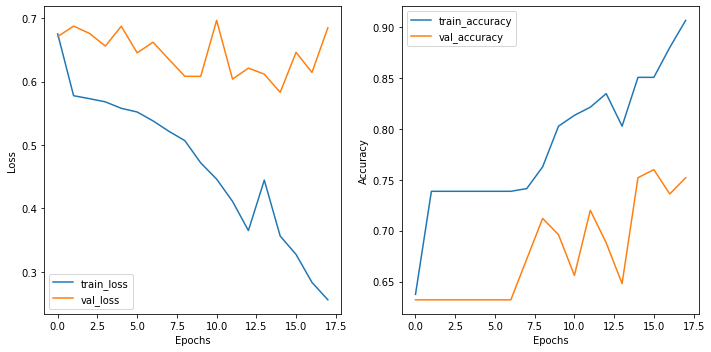

In [116]:
plot_metrics(model_12_results)

Still kind of jumping all over the place, but it has more of an obvious direction to it. 

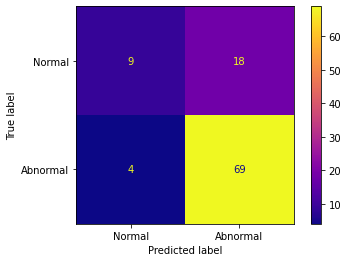

In [117]:
plot_cm(model_12)

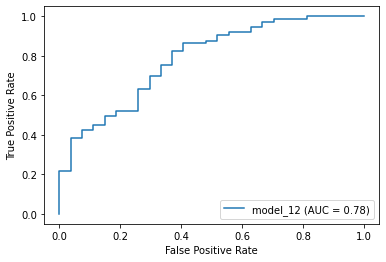

In [118]:
plot_roc(model_12, 'model_12')

The model is doing a decent job at minimizing false negatives, but it kind of looks like it's mostly predicting the majority class. 

There is a class imbalance, so let's try adjusting the class weights so that the minority class has a larger impact. 

# Model #13
<hr style="border:2px solid pink">

Let's adjust the class weights. Class 0 (or normal) had fewer images, so the weight for that class should be higher than class 1 (or the abnormal set). Let's try it. 

In [119]:
#y_ints = [y.argmax() for y in binary_train_labels]
class_weights = compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(binary_train_labels),
                                                  y=binary_train_labels)

# turn into dict so it can be put in the fit statement
class_weights_dict = {class_index: weight for class_index, weight in enumerate(class_weights)}

In [120]:
# confirm the weights look accurate
class_weights_dict

{0: 1.7361111111111112, 1: 0.702247191011236}

This looks good! Let's try it out in a model and see what it does. 

In [121]:
model_13 = Sequential()

model_13.add(Conv2D(filters=64, 
                        kernel_size=(3,3), 
                        activation='relu', 
                        input_shape=input_shape, 
                        kernel_regularizer=l2(0.0001)))

model_13.add(MaxPooling2D(pool_size=(2,2)))

model_13.add(Conv2D(128, (3, 3), activation='relu'))
model_13.add(MaxPooling2D(pool_size=(2,2)))

model_13.add(Conv2D(64, (3, 3), activation='relu'))
model_13.add(MaxPooling2D(pool_size=(2,2)))

model_13.add(Flatten())
model_13.add(Dense(128, activation='relu'))
model_13.add(Dense(64, activation='relu'))
model_13.add(Dense(32, activation='relu'))
model_13.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.0001)))

model_13.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision, recall])

model_13.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32 (Conv2D)           (None, 62, 62, 64)        640       
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 29, 29, 128)       73856     
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 12, 12, 64)        73792     
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 2304)            

In [122]:
model_13_results = model_13.fit(train_images, 
                              binary_train_labels, 
                              validation_split=0.25,
                              batch_size=100, 
                              epochs=25, 
                              callbacks=early_stop,
                              class_weight=class_weights_dict)

Epoch 1/25
4/4 [==============================] - 2s 571ms/step - loss: 0.6741 - accuracy: 0.6400 - precision: 0.7494 - recall: 0.8286 - val_loss: 0.6748 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 2/25
4/4 [==============================] - 2s 436ms/step - loss: 0.6802 - accuracy: 0.7387 - precision: 0.7387 - recall: 1.0000 - val_loss: 0.6814 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 3/25
4/4 [==============================] - 2s 426ms/step - loss: 0.6720 - accuracy: 0.6640 - precision: 0.7428 - recall: 0.8339 - val_loss: 0.6892 - val_accuracy: 0.6320 - val_precision: 0.6542 - val_recall: 0.8861
Epoch 4/25
4/4 [==============================] - 2s 440ms/step - loss: 0.6697 - accuracy: 0.7227 - precision: 0.7493 - recall: 0.9386 - val_loss: 0.6818 - val_accuracy: 0.6400 - val_precision: 0.6441 - val_recall: 0.9620


In [123]:
evaluate_model(model_13)

4/4 [==============================] - 0s 39ms/step - loss: 0.6762 - accuracy: 0.7600 - precision: 0.8657 - recall: 0.7945
Training Loss: 0.673
Training Accuracy: 0.724
Training Precision: 0.728
Training Recall: 0.978
---------------------------
Testing Loss: 0.676
Testing Accuracy: 0.76
Testing Precision: 0.866
Testing Recall: 0.795


Both training and testing scores are average at best. The low training scores suggests not enough complexity. Maybe the early stopping was too soon. 

The model is pretty overfit, let's try adding more regularization. 

But first, let's look at the loss and accuracy, confusion matrix, and roc curve. 

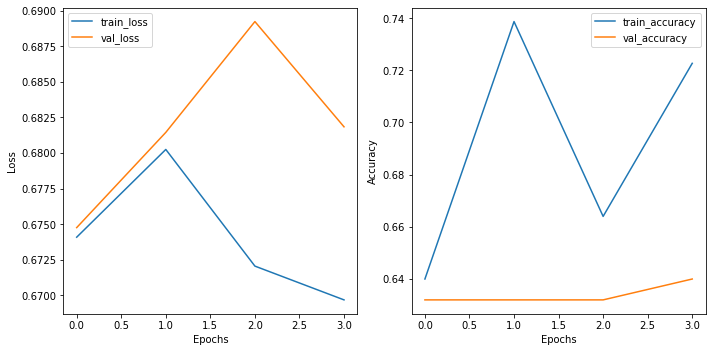

In [124]:
plot_metrics(model_13_results)

This didn't really improve anything. The loss functions look like they're being maximized instead of minimzed, and accuracy is all over the place. 

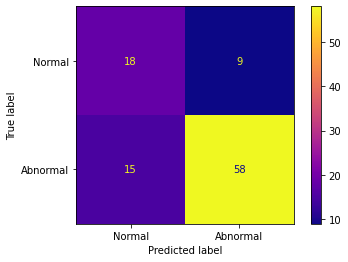

In [125]:
plot_cm(model_13)

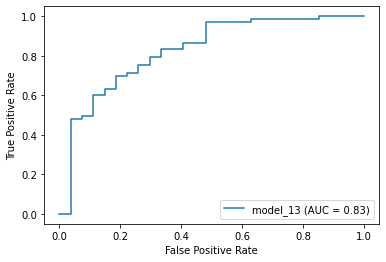

In [126]:
plot_roc(model_13, 'model_13')

The model seems to be doing better at predicting the minority class at least, but it looks like there are a decent number of false negatives, which we want to avoid. Let's try adding in some more regularization. 

# Model #14
<hr style="border:2px solid pink">

I'd like to see what the impact of dropout regularization is. Dropout involves randomly deactivating a specified percentage of neurons between layers during each training iteration. This technique prevents the model from memorizing specific details of the training set, which produces a more robust and generalized learning process.

I'll add dropout after each max pooling layer, dropping out 20% of the neurons each time. 

In [127]:
model_14 = Sequential()

model_14.add(Conv2D(filters=32, 
                        kernel_size=(3,3), 
                        activation='relu', 
                        input_shape=input_shape, 
                        kernel_regularizer=l2(0.0001)))

model_14.add(MaxPooling2D(pool_size=(2,2)))
model_14.add(Dropout(0.2))

model_14.add(Conv2D(128, (3, 3), activation='relu'))
model_14.add(MaxPooling2D(pool_size=(2,2)))
model_14.add(Dropout(0.2))

model_14.add(Conv2D(64, (3, 3), activation='relu'))
model_14.add(MaxPooling2D(pool_size=(2,2)))
model_14.add(Dropout(0.2))

model_14.add(Flatten())
model_14.add(Dense(64, activation='relu'))
model_14.add(Dense(32, activation='relu'))
model_14.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.0001)))

model_14.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision, recall])

model_14.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_35 (Conv2D)           (None, 62, 62, 32)        320       
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 29, 29, 128)       36992     
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 14, 14, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 12, 12, 64)      

In [128]:
model_14_results = model_14.fit(train_images, 
                              binary_train_labels, 
                              validation_split=0.25,
                              batch_size=100, 
                              epochs=25, 
                              callbacks=early_stop,
                              class_weight=class_weights_dict)

Epoch 1/25
4/4 [==============================] - 2s 479ms/step - loss: 0.6808 - accuracy: 0.5200 - precision: 0.7570 - recall: 0.6143 - val_loss: 0.6888 - val_accuracy: 0.6000 - val_precision: 0.6218 - val_recall: 0.9367
Epoch 2/25
4/4 [==============================] - 1s 366ms/step - loss: 0.6743 - accuracy: 0.7253 - precision: 0.7417 - recall: 0.9639 - val_loss: 0.6745 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 3/25
4/4 [==============================] - 2s 425ms/step - loss: 0.6682 - accuracy: 0.7013 - precision: 0.7405 - recall: 0.9170 - val_loss: 0.6867 - val_accuracy: 0.5280 - val_precision: 0.6282 - val_recall: 0.6203
Epoch 4/25
4/4 [==============================] - 2s 455ms/step - loss: 0.6638 - accuracy: 0.5653 - precision: 0.7938 - recall: 0.5560 - val_loss: 0.6774 - val_accuracy: 0.5760 - val_precision: 0.6327 - val_recall: 0.7848
Epoch 5/25
4/4 [==============================] - 2s 477ms/step - loss: 0.6639 - accuracy: 0.6560 - precision: 0

In [129]:
evaluate_model(model_14)

4/4 [==============================] - 0s 33ms/step - loss: 1.0009 - accuracy: 0.4900 - precision: 1.0000 - recall: 0.3014
Training Loss: 0.498
Training Accuracy: 0.762
Training Precision: 0.879
Training Recall: 0.772
---------------------------
Testing Loss: 1.0
Testing Accuracy: 0.49
Testing Precision: 1.0
Testing Recall: 0.301


This only made things worse! I think the model might be getting stopped too soon due to the fluctuations in loss and accuracy. Let's remove early stopping from now on. 

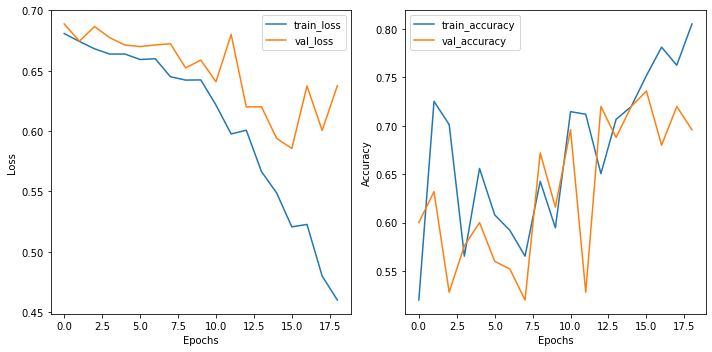

In [130]:
plot_metrics(model_14_results)

The loss and accuracy are actually kind of getting there. They're at least curving in the right direction. Let's try model 14 again but without early stopping and see how the results change. But first, the confusion matrix and roc curve. 

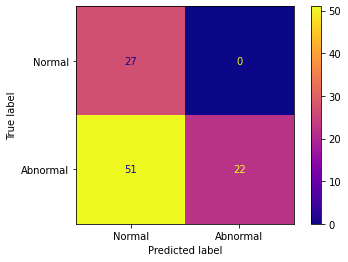

In [131]:
plot_cm(model_14)

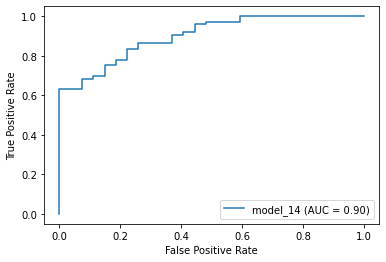

In [132]:
plot_roc(model_14, 'model_14')

The model is definitely predicting the minority class now! We have 0 false positives, which makes sense as precision scores were pretty high. AUC of 0.90 seems a little high though. Let's remove early stopping and try again. 

In [133]:
# removed early stopping
model_14_results = model_14.fit(train_images, 
                              binary_train_labels, 
                              validation_split=0.25,
                              batch_size=100, 
                              epochs=25,
                              class_weight=class_weights_dict)

Epoch 1/25
4/4 [==============================] - 2s 396ms/step - loss: 0.4721 - accuracy: 0.8213 - precision: 0.8723 - recall: 0.8881 - val_loss: 0.6299 - val_accuracy: 0.7200 - val_precision: 0.8143 - val_recall: 0.7215
Epoch 2/25
4/4 [==============================] - 2s 385ms/step - loss: 0.4498 - accuracy: 0.7733 - precision: 0.9660 - recall: 0.7184 - val_loss: 0.6142 - val_accuracy: 0.7280 - val_precision: 0.7184 - val_recall: 0.9367
Epoch 3/25
4/4 [==============================] - 2s 433ms/step - loss: 0.4500 - accuracy: 0.8347 - precision: 0.8669 - recall: 0.9170 - val_loss: 0.6726 - val_accuracy: 0.6240 - val_precision: 0.7759 - val_recall: 0.5696
Epoch 4/25
4/4 [==============================] - 2s 384ms/step - loss: 0.4367 - accuracy: 0.7573 - precision: 0.9471 - recall: 0.7112 - val_loss: 0.6023 - val_accuracy: 0.7200 - val_precision: 0.7245 - val_recall: 0.8987
Epoch 5/25
4/4 [==============================] - 2s 443ms/step - loss: 0.4129 - accuracy: 0.8400 - precision: 0

In [134]:
evaluate_model(model_14)

4/4 [==============================] - 0s 42ms/step - loss: 2.0785 - accuracy: 0.5600 - precision: 0.9394 - recall: 0.4247
Training Loss: 0.398
Training Accuracy: 0.872
Training Precision: 0.953
Training Recall: 0.862
---------------------------
Testing Loss: 2.08
Testing Accuracy: 0.56
Testing Precision: 0.939
Testing Recall: 0.425


That increased both the training and testing scores, so I think I was right and early stopping was stopping the training process too quickly. Let's stop using it from now on. 

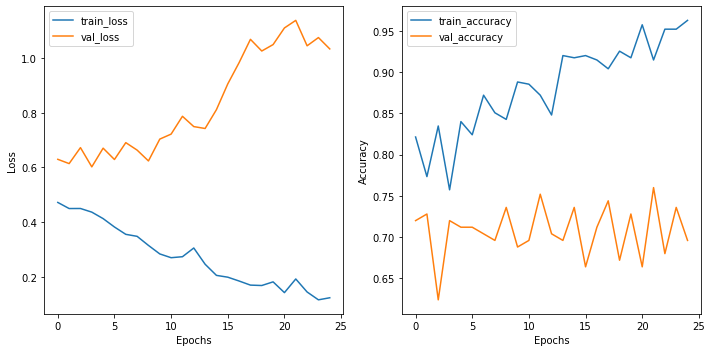

In [135]:
plot_metrics(model_14_results)

We lost the curve we had earlier and are back to the endless fluctuations. I wonder how batch size and epochs would change the results. 

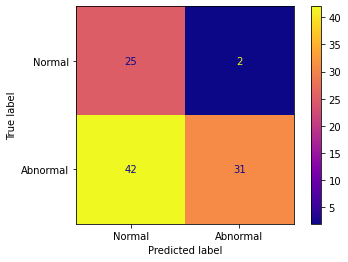

In [136]:
plot_cm(model_14)

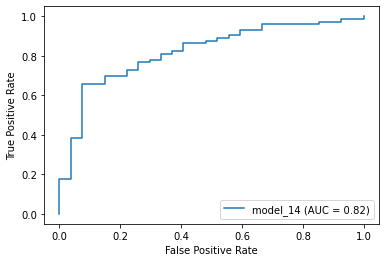

In [137]:
plot_roc(model_14, 'model_14')

The confusion matrix and roc curve are pretty similar to the last model. We're still minimizing false positives over false negatives. 

Let's look at different batch size and epochs by experimenting with the latest model. I will iterate through a few different batch sizes and epochs, then look at the average accuracy.

Let's do the loop!

In [138]:
model_14_loop = {}
batch_sizes = [50, 100, 150]
epochs = [15, 25, 50]

for batch_size in batch_sizes:
    for epoch in epochs:
        model = model_14
        
        model.compile(optimizer='Adam',
                      loss='binary_crossentropy',
                      metrics=['accuracy', precision, recall])
        
        # Train the model
        model_results = model.fit(train_images, 
                                  binary_train_labels, 
                                  batch_size=batch_size, 
                                  epochs=epoch,
                                  validation_split=0.25,
                                  class_weight=class_weights_dict)
        
        # Store the results in a dictionary using the combination of batch size and epochs as keys
        model_14_loop[(batch_size, epoch)] = model_results

Epoch 1/15
8/8 [==============================] - 3s 321ms/step - loss: 0.4145 - accuracy: 0.8293 - precision: 0.9481 - recall: 0.7314 - val_loss: 0.8094 - val_accuracy: 0.7360 - val_precision: 0.7556 - val_recall: 0.8608
Epoch 2/15
8/8 [==============================] - 2s 256ms/step - loss: 0.1947 - accuracy: 0.9627 - precision: 0.9582 - recall: 0.9928 - val_loss: 0.8800 - val_accuracy: 0.6960 - val_precision: 0.7356 - val_recall: 0.8101
Epoch 3/15
8/8 [==============================] - 2s 310ms/step - loss: 0.1528 - accuracy: 0.9467 - precision: 0.9961 - recall: 0.9314 - val_loss: 1.0368 - val_accuracy: 0.6880 - val_precision: 0.7273 - val_recall: 0.8101
Epoch 4/15
8/8 [==============================] - 3s 321ms/step - loss: 0.0994 - accuracy: 0.9787 - precision: 1.0000 - recall: 0.9711 - val_loss: 1.2310 - val_accuracy: 0.7040 - val_precision: 0.7333 - val_recall: 0.8354
Epoch 5/15
8/8 [==============================] - 3s 387ms/step - loss: 0.0971 - accuracy: 0.9680 - precision: 0

Epoch 23/25
8/8 [==============================] - 3s 321ms/step - loss: 0.0774 - accuracy: 0.9600 - precision: 1.0000 - recall: 0.9458 - val_loss: 1.9210 - val_accuracy: 0.7200 - val_precision: 0.7037 - val_recall: 0.9620
Epoch 24/25
8/8 [==============================] - 3s 337ms/step - loss: 0.0598 - accuracy: 0.9920 - precision: 0.9928 - recall: 0.9964 - val_loss: 1.6097 - val_accuracy: 0.6480 - val_precision: 0.7536 - val_recall: 0.6582
Epoch 25/25
8/8 [==============================] - 3s 328ms/step - loss: 0.0430 - accuracy: 0.9893 - precision: 0.9928 - recall: 0.9928 - val_loss: 1.6983 - val_accuracy: 0.7280 - val_precision: 0.7320 - val_recall: 0.8987
Epoch 1/50
8/8 [==============================] - 3s 368ms/step - loss: 0.0297 - accuracy: 0.9947 - precision: 0.9301 - recall: 0.9719 - val_loss: 1.9654 - val_accuracy: 0.6960 - val_precision: 0.7204 - val_recall: 0.8481
Epoch 2/50
8/8 [==============================] - 2s 281ms/step - loss: 0.0127 - accuracy: 0.9973 - precision

Epoch 35/50
8/8 [==============================] - 3s 333ms/step - loss: 0.0066 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 2.2849 - val_accuracy: 0.7280 - val_precision: 0.7143 - val_recall: 0.9494
Epoch 36/50
8/8 [==============================] - 2s 286ms/step - loss: 0.0218 - accuracy: 0.9893 - precision: 0.9964 - recall: 0.9892 - val_loss: 2.3174 - val_accuracy: 0.7040 - val_precision: 0.7234 - val_recall: 0.8608
Epoch 37/50
8/8 [==============================] - 2s 304ms/step - loss: 0.0063 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 2.9986 - val_accuracy: 0.7120 - val_precision: 0.7216 - val_recall: 0.8861
Epoch 38/50
8/8 [==============================] - 2s 307ms/step - loss: 0.0145 - accuracy: 0.9947 - precision: 0.9964 - recall: 0.9964 - val_loss: 3.2617 - val_accuracy: 0.6880 - val_precision: 0.7222 - val_recall: 0.8228
Epoch 39/50
8/8 [==============================] - 3s 325ms/step - loss: 0.0067 - accuracy: 0.9973 - precisi

Epoch 7/25
4/4 [==============================] - 2s 470ms/step - loss: 0.0046 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 2.8625 - val_accuracy: 0.7360 - val_precision: 0.7255 - val_recall: 0.9367
Epoch 8/25
4/4 [==============================] - 2s 488ms/step - loss: 0.0035 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 2.7203 - val_accuracy: 0.7200 - val_precision: 0.7245 - val_recall: 0.8987
Epoch 9/25
4/4 [==============================] - 2s 479ms/step - loss: 0.0057 - accuracy: 0.9947 - precision: 1.0000 - recall: 0.9928 - val_loss: 2.9607 - val_accuracy: 0.7120 - val_precision: 0.7172 - val_recall: 0.8987
Epoch 10/25
4/4 [==============================] - 2s 470ms/step - loss: 0.0129 - accuracy: 0.9947 - precision: 0.9964 - recall: 0.9964 - val_loss: 3.0405 - val_accuracy: 0.7120 - val_precision: 0.7172 - val_recall: 0.8987
Epoch 11/25
4/4 [==============================] - 2s 442ms/step - loss: 0.0029 - accuracy: 1.0000 - precision:

Epoch 19/50
4/4 [==============================] - 2s 463ms/step - loss: 0.0023 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 4.5893 - val_accuracy: 0.6960 - val_precision: 0.6847 - val_recall: 0.9620
Epoch 20/50
4/4 [==============================] - 2s 453ms/step - loss: 0.0068 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 3.5347 - val_accuracy: 0.7360 - val_precision: 0.7396 - val_recall: 0.8987
Epoch 21/50
4/4 [==============================] - 2s 480ms/step - loss: 0.0067 - accuracy: 0.9973 - precision: 1.0000 - recall: 0.9964 - val_loss: 3.5577 - val_accuracy: 0.6560 - val_precision: 0.7195 - val_recall: 0.7468
Epoch 22/50
4/4 [==============================] - 2s 404ms/step - loss: 0.0138 - accuracy: 0.9920 - precision: 1.0000 - recall: 0.9892 - val_loss: 3.7882 - val_accuracy: 0.7440 - val_precision: 0.7327 - val_recall: 0.9367
Epoch 23/50
4/4 [==============================] - 2s 517ms/step - loss: 0.0175 - accuracy: 0.9973 - precisi

Epoch 6/15
3/3 [==============================] - 1s 472ms/step - loss: 8.6728e-04 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 4.7193 - val_accuracy: 0.6720 - val_precision: 0.7021 - val_recall: 0.8354
Epoch 7/15
3/3 [==============================] - 2s 521ms/step - loss: 0.0012 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 4.7835 - val_accuracy: 0.6720 - val_precision: 0.7065 - val_recall: 0.8228
Epoch 8/15
3/3 [==============================] - 2s 517ms/step - loss: 0.0020 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 4.9378 - val_accuracy: 0.6880 - val_precision: 0.7000 - val_recall: 0.8861
Epoch 9/15
3/3 [==============================] - 1s 480ms/step - loss: 9.3635e-04 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 4.9252 - val_accuracy: 0.7360 - val_precision: 0.7170 - val_recall: 0.9620
Epoch 10/15
3/3 [==============================] - 2s 519ms/step - loss: 7.8225e-04 - accuracy: 1.0000 -

Epoch 39/50
3/3 [==============================] - 2s 541ms/step - loss: 7.6236e-04 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 4.0937 - val_accuracy: 0.7280 - val_precision: 0.7273 - val_recall: 0.9114
Epoch 40/50
3/3 [==============================] - 2s 565ms/step - loss: 8.0642e-04 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 4.0639 - val_accuracy: 0.7200 - val_precision: 0.7245 - val_recall: 0.8987
Epoch 41/50
3/3 [==============================] - 2s 561ms/step - loss: 8.6100e-04 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 4.0485 - val_accuracy: 0.7200 - val_precision: 0.7245 - val_recall: 0.8987
Epoch 42/50
3/3 [==============================] - 1s 499ms/step - loss: 8.3927e-04 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 4.0452 - val_accuracy: 0.7200 - val_precision: 0.7245 - val_recall: 0.8987
Epoch 43/50
3/3 [==============================] - 2s 520ms/step - loss: 0.0010 - accuracy: 

And now, let's get the average accuracy for each batch size/epoch combination and see where the results are the best. 

In [139]:
average_accuracy = {}

for batch_size in batch_sizes:
    for epoch in epochs:
        history = model_14_loop[(batch_size, epoch)].history
        avg_acc = sum(history['accuracy']) / len(history['accuracy'])
        average_accuracy[(batch_size, epoch)] = avg_acc

for batch_size in batch_sizes:
    for epoch in epochs:
        print(f"Batch Size {batch_size}, Epochs {epoch}:")
        print(f"Average Accuracy: {average_accuracy[(batch_size, epoch)]}")

Batch Size 50, Epochs 15:
Average Accuracy: 0.9616000016530355
Batch Size 50, Epochs 25:
Average Accuracy: 0.9806933379173279
Batch Size 50, Epochs 50:
Average Accuracy: 0.9953600084781646
Batch Size 100, Epochs 15:
Average Accuracy: 0.9957333405812582
Batch Size 100, Epochs 25:
Average Accuracy: 0.9981866717338562
Batch Size 100, Epochs 50:
Average Accuracy: 0.9986133372783661
Batch Size 150, Epochs 15:
Average Accuracy: 0.9998222231864929
Batch Size 150, Epochs 25:
Average Accuracy: 0.9989333391189575
Batch Size 150, Epochs 50:
Average Accuracy: 0.9981866705417634


So it looks like the most of these options are going to overfit, except for batch size 50, epochs 15, and maybe batch size 50, epochs 25. Let's try them both! 

# Model #15
<hr style="border:2px solid pink">

In [140]:
model_15 = Sequential()

model_15.add(Conv2D(filters=32, 
                        kernel_size=(3,3), 
                        activation='relu', 
                        input_shape=input_shape, 
                        kernel_regularizer=l2(0.0001)))

model_15.add(MaxPooling2D(pool_size=(2,2)))
model_15.add(Dropout(0.2))

model_15.add(Conv2D(128, (3, 3), activation='relu'))
model_15.add(MaxPooling2D(pool_size=(2,2)))
model_15.add(Dropout(0.2))

model_15.add(Conv2D(64, (3, 3), activation='relu'))
model_15.add(MaxPooling2D(pool_size=(2,2)))
model_15.add(Dropout(0.2))

model_15.add(Flatten())
model_15.add(Dense(64, activation='relu'))
model_15.add(Dense(32, activation='relu'))
model_15.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.0001)))

model_15.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision, recall])

model_15.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_38 (Conv2D)           (None, 62, 62, 32)        320       
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 29, 29, 128)       36992     
_________________________________________________________________
max_pooling2d_39 (MaxPooling (None, 14, 14, 128)       0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 12, 12, 64)      

In [141]:
# try batch size 50 and 15 epochs first
model_15_results = model_15.fit(train_images, 
                              binary_train_labels, 
                              validation_split=0.25,
                              batch_size=50, 
                              epochs=15,
                              class_weight=class_weights_dict)

Epoch 1/15
8/8 [==============================] - 3s 320ms/step - loss: 0.6788 - accuracy: 0.5333 - precision: 0.7173 - recall: 0.6770 - val_loss: 0.6922 - val_accuracy: 0.5200 - val_precision: 0.6508 - val_recall: 0.5190
Epoch 2/15
8/8 [==============================] - 2s 305ms/step - loss: 0.6715 - accuracy: 0.6427 - precision: 0.7544 - recall: 0.7653 - val_loss: 0.6807 - val_accuracy: 0.6560 - val_precision: 0.6475 - val_recall: 1.0000
Epoch 3/15
8/8 [==============================] - 4s 541ms/step - loss: 0.6696 - accuracy: 0.7333 - precision: 0.7373 - recall: 0.9928 - val_loss: 0.6738 - val_accuracy: 0.6400 - val_precision: 0.6491 - val_recall: 0.9367
Epoch 4/15
8/8 [==============================] - 3s 373ms/step - loss: 0.6604 - accuracy: 0.6453 - precision: 0.7500 - recall: 0.7798 - val_loss: 0.6794 - val_accuracy: 0.5520 - val_precision: 0.6494 - val_recall: 0.6329
Epoch 5/15
8/8 [==============================] - 3s 344ms/step - loss: 0.6641 - accuracy: 0.5227 - precision: 0

In [142]:
evaluate_model(model_15)

4/4 [==============================] - 0s 36ms/step - loss: 0.4929 - accuracy: 0.8000 - precision: 0.8442 - recall: 0.8904
Training Loss: 0.523
Training Accuracy: 0.788
Training Precision: 0.806
Training Recall: 0.924
---------------------------
Testing Loss: 0.493
Testing Accuracy: 0.8
Testing Precision: 0.844
Testing Recall: 0.89


Not so bad! Both training and testing scores are pretty decent, with training accuracy at 79%, precision at 81%, and recall at 92%. Testing accuracy is at 80%, precision at 84%, and recall at 89%. Let's look at the loss and accuracy, confusion matrix, and roc curve. 

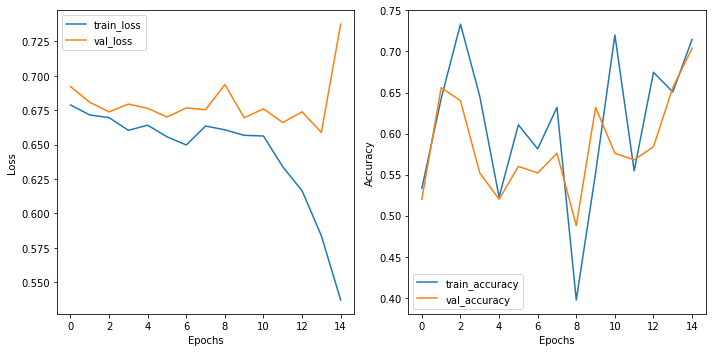

In [143]:
plot_metrics(model_15_results)

We have a lot of fluctuations in accuracy. Loss is not terrible, but validation loss spikes up at the end. 

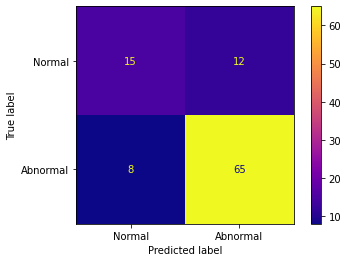

In [144]:
plot_cm(model_15)

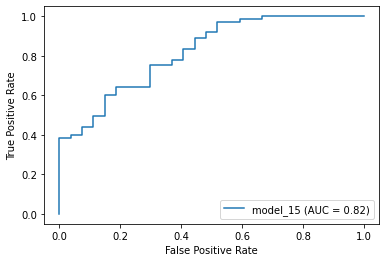

In [145]:
plot_roc(model_15, 'model_15')

We're doing a decent job of minimizing false negatives here! And the AUC score of 0.82, along the rest of the metrics, is prety decent. Let's see how more epochs does. 

In [146]:
# 25 epochs, 50 batch size
model_15_results = model_15.fit(train_images, 
                              binary_train_labels, 
                              validation_split=0.25,
                              batch_size=50, 
                              epochs=25,
                              class_weight=class_weights_dict)

Epoch 1/25
8/8 [==============================] - 2s 277ms/step - loss: 0.5409 - accuracy: 0.7067 - precision: 0.8523 - recall: 0.7292 - val_loss: 0.6718 - val_accuracy: 0.7040 - val_precision: 0.7234 - val_recall: 0.8608
Epoch 2/25
8/8 [==============================] - 3s 329ms/step - loss: 0.5279 - accuracy: 0.7280 - precision: 0.8924 - recall: 0.7184 - val_loss: 0.6744 - val_accuracy: 0.6880 - val_precision: 0.7273 - val_recall: 0.8101
Epoch 3/25
8/8 [==============================] - 3s 322ms/step - loss: 0.4598 - accuracy: 0.7920 - precision: 0.8996 - recall: 0.8087 - val_loss: 0.7862 - val_accuracy: 0.6240 - val_precision: 0.7424 - val_recall: 0.6203
Epoch 4/25
8/8 [==============================] - 2s 304ms/step - loss: 0.4368 - accuracy: 0.7813 - precision: 0.9114 - recall: 0.7798 - val_loss: 0.7842 - val_accuracy: 0.6400 - val_precision: 0.7500 - val_recall: 0.6456
Epoch 5/25
8/8 [==============================] - 2s 296ms/step - loss: 0.4043 - accuracy: 0.8107 - precision: 0

In [147]:
evaluate_model(model_15)

4/4 [==============================] - 0s 30ms/step - loss: 0.8096 - accuracy: 0.7100 - precision: 0.8667 - recall: 0.7123
Training Loss: 0.454
Training Accuracy: 0.926
Training Precision: 0.932
Training Recall: 0.966
---------------------------
Testing Loss: 0.81
Testing Accuracy: 0.71
Testing Precision: 0.867
Testing Recall: 0.712


Great training scores, not so great testing scores. It seems like 25 epochs is better than 15 at least, we can control the overfitting with regularization. Let's look at our plots first.  

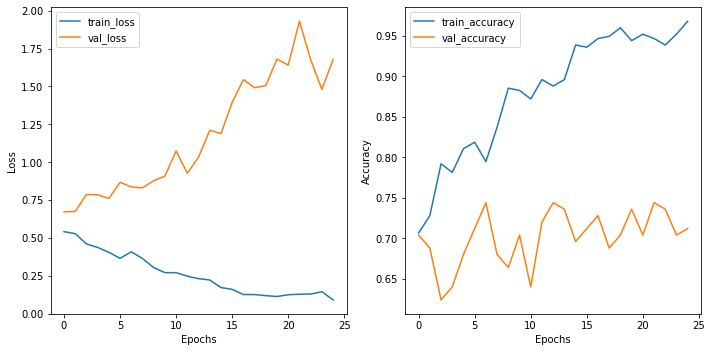

In [148]:
plot_metrics(model_15_results)

There are still a lot of fluctuations in both loss and accuracy. 

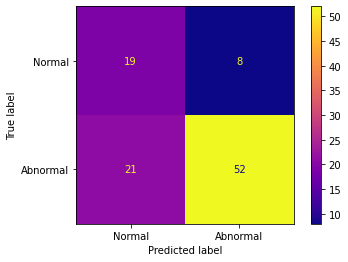

In [149]:
plot_cm(model_15)

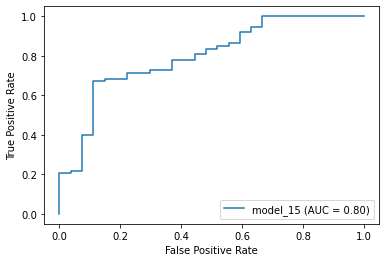

In [150]:
plot_roc(model_15, 'model_15')

We still have quite a lot of false negatives, but a little bit less than the last model at least. The AUC score of 0.80 suggests average performance when compared with the other metrics. 

# Model #16
<hr style="border:2px solid pink">

Let's increase the dropout rates. 

In [151]:
model_16 = Sequential()

model_16.add(Conv2D(filters=32, 
                        kernel_size=(3,3), 
                        activation='relu', 
                        input_shape=input_shape, 
                        kernel_regularizer=l2(0.0001)))

model_16.add(MaxPooling2D(pool_size=(2,2)))
model_16.add(Dropout(0.3)) # increased

model_16.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.0001))) # added
model_16.add(MaxPooling2D(pool_size=(2,2)))
model_16.add(Dropout(0.3)) # increased

model_16.add(Conv2D(64, (3, 3), activation='relu'))
model_16.add(MaxPooling2D(pool_size=(2,2)))
model_16.add(Dropout(0.2))

model_16.add(Flatten())
model_16.add(Dense(64, activation='relu'))
model_16.add(Dense(32, activation='relu'))
model_16.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.0001)))

model_16.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision, recall])

model_16.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_41 (Conv2D)           (None, 62, 62, 32)        320       
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 29, 29, 128)       36992     
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 14, 14, 128)       0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 12, 12, 64)      

In [152]:
model_16_results = model_16.fit(train_images, 
                              binary_train_labels, 
                              validation_split=0.25,
                              batch_size=50, 
                              epochs=25,
                              class_weight=class_weights_dict)

Epoch 1/25
8/8 [==============================] - 3s 358ms/step - loss: 0.6797 - accuracy: 0.7173 - precision: 0.7603 - recall: 0.8971 - val_loss: 0.6874 - val_accuracy: 0.6400 - val_precision: 0.6393 - val_recall: 0.9873
Epoch 2/25
8/8 [==============================] - 2s 288ms/step - loss: 0.6782 - accuracy: 0.6533 - precision: 0.7333 - recall: 0.8339 - val_loss: 0.6911 - val_accuracy: 0.6080 - val_precision: 0.6442 - val_recall: 0.8481
Epoch 3/25
8/8 [==============================] - 2s 308ms/step - loss: 0.6698 - accuracy: 0.6693 - precision: 0.7647 - recall: 0.7978 - val_loss: 0.6783 - val_accuracy: 0.6320 - val_precision: 0.6435 - val_recall: 0.9367
Epoch 4/25
8/8 [==============================] - 3s 320ms/step - loss: 0.6699 - accuracy: 0.6507 - precision: 0.7466 - recall: 0.7978 - val_loss: 0.6864 - val_accuracy: 0.4880 - val_precision: 0.6230 - val_recall: 0.4810
Epoch 5/25
8/8 [==============================] - 3s 317ms/step - loss: 0.6669 - accuracy: 0.6213 - precision: 0

In [153]:
evaluate_model(model_16)

4/4 [==============================] - 0s 28ms/step - loss: 1.0921 - accuracy: 0.5300 - precision: 0.9333 - recall: 0.3836
Training Loss: 0.491
Training Accuracy: 0.818
Training Precision: 0.937
Training Recall: 0.798
---------------------------
Testing Loss: 1.09
Testing Accuracy: 0.53
Testing Precision: 0.933
Testing Recall: 0.384


That lowered the testing score a lot! We decreased from 71% to 53%, and it looks like loss increased as well. Let's look at the plots.  

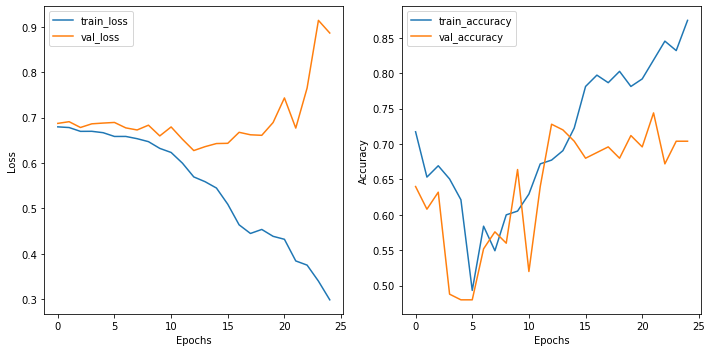

In [154]:
plot_metrics(model_16_results)

Yes, validation loss is increasing. Accuracy is still fluctuating quite a lot. 

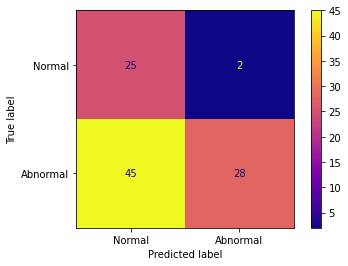

In [155]:
plot_cm(model_16)

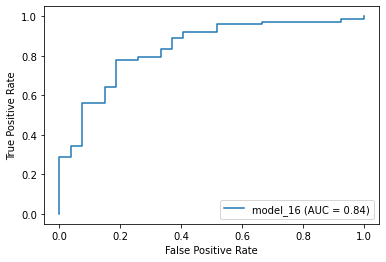

In [156]:
plot_roc(model_16, 'model_16')

The confusion matrix suggests that the model is doing a good job at minimizing false positives, which is great but not the main goal. I'd like to see what happens if we increase/decrease all the units in the layers, and keep everything else constant. 

# Model #17
<hr style="border:2px solid pink">

Let's try adjusting the numbers of units in each of the layers. Start by doubling them all. 

In [157]:
model_17 = Sequential()

model_17.add(Conv2D(filters=64, 
                        kernel_size=(3,3), 
                        activation='relu', 
                        input_shape=input_shape, 
                        kernel_regularizer=l2(0.0001)))

model_17.add(MaxPooling2D(pool_size=(2,2)))
model_17.add(Dropout(0.3))

model_17.add(Conv2D(256, (3, 3), activation='relu', kernel_regularizer=l2(0.0001))) # added
model_17.add(MaxPooling2D(pool_size=(2,2)))
model_17.add(Dropout(0.3))

model_17.add(Conv2D(128, (3, 3), activation='relu'))
model_17.add(MaxPooling2D(pool_size=(2,2)))
model_17.add(Dropout(0.2))

model_17.add(Flatten())
model_17.add(Dense(128, activation='relu'))
model_17.add(Dense(64, activation='relu'))
model_17.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.0001)))

model_17.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision, recall])

model_17.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_44 (Conv2D)           (None, 62, 62, 64)        640       
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 31, 31, 64)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 29, 29, 256)       147712    
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 14, 14, 256)       0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 14, 14, 256)       0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 12, 12, 128)     

Wow! Look at how many more parameters that created! Let's see how the model does. 

In [158]:
model_17_results = model_17.fit(train_images, 
                              binary_train_labels, 
                              validation_split=0.25,
                              batch_size=50, 
                              epochs=25,
                              class_weight=class_weights_dict)

Epoch 1/25
8/8 [==============================] - 7s 919ms/step - loss: 0.6857 - accuracy: 0.6160 - precision: 0.7359 - recall: 0.7086 - val_loss: 0.6829 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 2/25
8/8 [==============================] - 7s 814ms/step - loss: 0.6801 - accuracy: 0.6533 - precision: 0.7561 - recall: 0.7834 - val_loss: 0.7299 - val_accuracy: 0.4320 - val_precision: 0.7857 - val_recall: 0.1392
Epoch 3/25
8/8 [==============================] - 6s 776ms/step - loss: 0.6811 - accuracy: 0.4373 - precision: 0.7895 - recall: 0.3249 - val_loss: 0.6816 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 4/25
8/8 [==============================] - 6s 792ms/step - loss: 0.6743 - accuracy: 0.7413 - precision: 0.7406 - recall: 1.0000 - val_loss: 0.6847 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 5/25
8/8 [==============================] - 7s 821ms/step - loss: 0.6722 - accuracy: 0.7307 - precision: 0

In [159]:
evaluate_model(model_17)

4/4 [==============================] - 0s 69ms/step - loss: 0.6848 - accuracy: 0.7600 - precision: 0.8551 - recall: 0.8082
Training Loss: 0.395
Training Accuracy: 0.914
Training Precision: 0.909
Training Recall: 0.978
---------------------------
Testing Loss: 0.685
Testing Accuracy: 0.76
Testing Precision: 0.855
Testing Recall: 0.808


This is pretty good for the training set - accuracy, precision, and recall are all in the 90s! However, and unsurprisingly, this is overfit, and the test set seems to be prioritizing minimizing false positives over false negatives. Let's look at the loss and accuracy. 

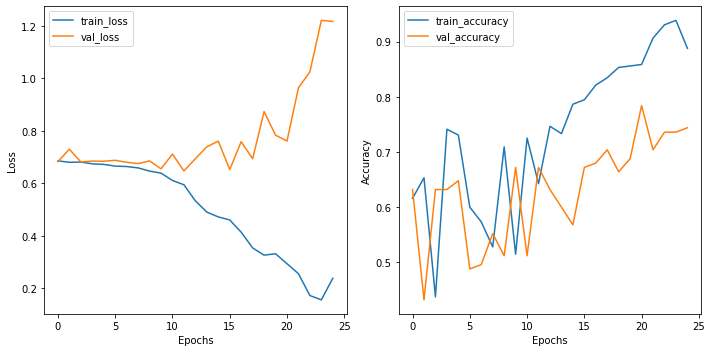

In [160]:
plot_metrics(model_17_results)

The validation loss is interesting - it curves back up and starts to get jagged around 15 epochs. Maybe 25 was too many. Accuracy is jumping all over the place still, maybe the worst yet. Let's try halving all of the units next.

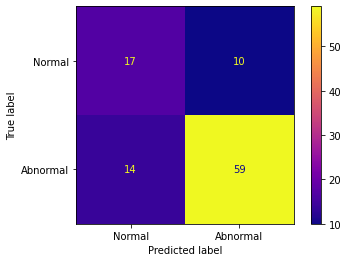

In [161]:
plot_cm(model_17)

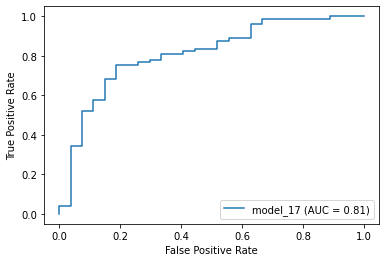

In [162]:
plot_roc(model_17, 'model_17')

There are less false negatives! However, it would be better if there were more true negatives and true positives. The confusion matrix and roc curve suggest average performance. 

Let's halve the units in each layer. 

# Model #18
<hr style="border:2px solid pink">

In [163]:
model_18 = Sequential()

model_18.add(Conv2D(filters=32, 
                        kernel_size=(3,3), 
                        activation='relu', 
                        input_shape=input_shape, 
                        kernel_regularizer=l2(0.0001)))

model_18.add(MaxPooling2D(pool_size=(2,2)))
model_18.add(Dropout(0.3))

model_18.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.0001))) # added
model_18.add(MaxPooling2D(pool_size=(2,2)))
model_18.add(Dropout(0.2))

model_18.add(Conv2D(32, (3, 3), activation='relu'))
model_18.add(MaxPooling2D(pool_size=(2,2)))
model_18.add(Dropout(0.2))

model_18.add(Flatten())
model_18.add(Dense(32, activation='relu'))
model_18.add(Dense(16, activation='relu'))
model_18.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.0001)))

model_18.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision, recall])

model_18.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_47 (Conv2D)           (None, 62, 62, 32)        320       
_________________________________________________________________
max_pooling2d_47 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_48 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 12, 12, 32)      

This really decreased the parameters! We went from over 1 million to just 74,721! Let's see how it does. 

In [164]:
model_18_results = model_18.fit(train_images, 
                              binary_train_labels, 
                              validation_split=0.25,
                              batch_size=50, 
                              epochs=25,
                              class_weight=class_weights_dict)

Epoch 1/25
8/8 [==============================] - 1s 136ms/step - loss: 0.6831 - accuracy: 0.4347 - precision: 0.7615 - recall: 0.4743 - val_loss: 0.6911 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 2/25
8/8 [==============================] - 1s 81ms/step - loss: 0.6764 - accuracy: 0.7387 - precision: 0.7387 - recall: 1.0000 - val_loss: 0.6850 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 3/25
8/8 [==============================] - 1s 87ms/step - loss: 0.6766 - accuracy: 0.7387 - precision: 0.7387 - recall: 1.0000 - val_loss: 0.6810 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 4/25
8/8 [==============================] - 1s 84ms/step - loss: 0.6723 - accuracy: 0.7360 - precision: 0.7380 - recall: 0.9964 - val_loss: 0.6856 - val_accuracy: 0.6320 - val_precision: 0.6341 - val_recall: 0.9873
Epoch 5/25
8/8 [==============================] - 1s 85ms/step - loss: 0.6743 - accuracy: 0.5333 - precision: 0.736

In [165]:
evaluate_model(model_18)

4/4 [==============================] - 0s 17ms/step - loss: 0.6907 - accuracy: 0.6400 - precision: 0.9111 - recall: 0.5616
Training Loss: 0.419
Training Accuracy: 0.838
Training Precision: 0.901
Training Recall: 0.868
---------------------------
Testing Loss: 0.691
Testing Accuracy: 0.64
Testing Precision: 0.911
Testing Recall: 0.562


Still overfit and the scores aren't as high. Precision is still being prioritized over recall. The more complex models seem to perform a little better. Let's look at the plots.  

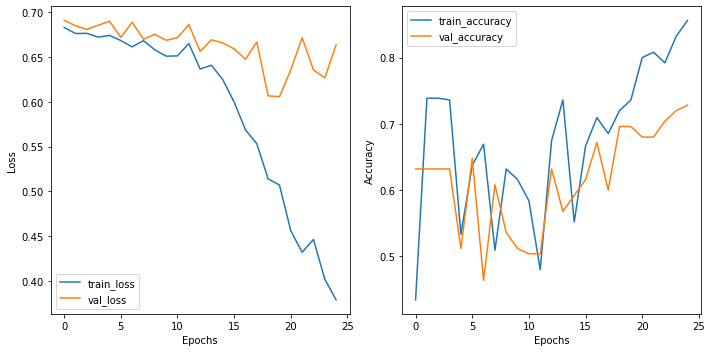

In [166]:
plot_metrics(model_18_results)

Train loss is doing okay, validation loss is kind of sporadic, and accuracy is just all over the place still. I think increasing complexity could help at least the scores increase. 

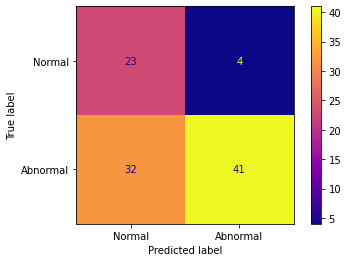

In [167]:
plot_cm(model_18)

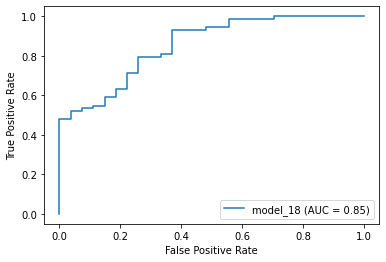

In [169]:
plot_roc(model_18, 'model_18')

Yes, it looks like there are fewer false positives than false negatives. 

Let's go back to the original units, and add more dense layers in between to connect the neurons. 

# Model #19
<hr style="border:2px solid pink">

In [170]:
model_19 = Sequential()

model_19.add(Conv2D(filters=32, 
                        kernel_size=(3,3), 
                        activation='relu', 
                        input_shape=input_shape, 
                        kernel_regularizer=l2(0.0001)))

model_19.add(Dense(64, activation='relu')) # added
model_19.add(MaxPooling2D(pool_size=(2,2)))
model_19.add(Dropout(0.3))

model_19.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.0001)))
model_19.add(Dense(64, activation='relu'))
model_19.add(MaxPooling2D(pool_size=(2,2)))
model_19.add(Dropout(0.2))

model_19.add(Conv2D(64, (3, 3), activation='relu'))
model_19.add(Dense(64, activation='relu'))
model_19.add(MaxPooling2D(pool_size=(2,2)))
model_19.add(Dropout(0.2))

model_19.add(Flatten())
model_19.add(Dense(64, activation='relu'))
model_19.add(Dense(32, activation='relu'))
model_19.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.0001)))

model_19.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision, recall])

model_19.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_50 (Conv2D)           (None, 62, 62, 32)        320       
_________________________________________________________________
dense_54 (Dense)             (None, 62, 62, 64)        2112      
_________________________________________________________________
max_pooling2d_50 (MaxPooling (None, 31, 31, 64)        0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 29, 29, 128)       73856     
_________________________________________________________________
dense_55 (Dense)             (None, 29, 29, 64)        8256      
_________________________________________________________________
max_pooling2d_51 (MaxPooling (None, 14, 14, 64)      

This added some of those lost parameters back in. Let's see how it does. 

In [171]:
model_19_results = model_19.fit(train_images, 
                              binary_train_labels, 
                              validation_split=0.25,
                              batch_size=50, 
                              epochs=25,
                              class_weight=class_weights_dict)

Epoch 1/25
8/8 [==============================] - 2s 247ms/step - loss: 0.6834 - accuracy: 0.6880 - precision: 0.7627 - recall: 0.8171 - val_loss: 0.6929 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 2/25
8/8 [==============================] - 2s 195ms/step - loss: 0.6783 - accuracy: 0.7387 - precision: 0.7387 - recall: 1.0000 - val_loss: 0.6830 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 3/25
8/8 [==============================] - 2s 190ms/step - loss: 0.6809 - accuracy: 0.5040 - precision: 0.7600 - recall: 0.4801 - val_loss: 0.6825 - val_accuracy: 0.6320 - val_precision: 0.6571 - val_recall: 0.8734
Epoch 4/25
8/8 [==============================] - 1s 186ms/step - loss: 0.6739 - accuracy: 0.7227 - precision: 0.7423 - recall: 0.9567 - val_loss: 0.6760 - val_accuracy: 0.6480 - val_precision: 0.6423 - val_recall: 1.0000
Epoch 5/25
8/8 [==============================] - 1s 184ms/step - loss: 0.6696 - accuracy: 0.7147 - precision: 0

In [172]:
evaluate_model(model_19)

4/4 [==============================] - 0s 39ms/step - loss: 0.6019 - accuracy: 0.7200 - precision: 0.8462 - recall: 0.7534
Training Loss: 0.374
Training Accuracy: 0.886
Training Precision: 0.903
Training Recall: 0.941
---------------------------
Testing Loss: 0.602
Testing Accuracy: 0.72
Testing Precision: 0.846
Testing Recall: 0.753


A little bit better! Still overfit, but the scores are all pretty good, and all up from the last model. 

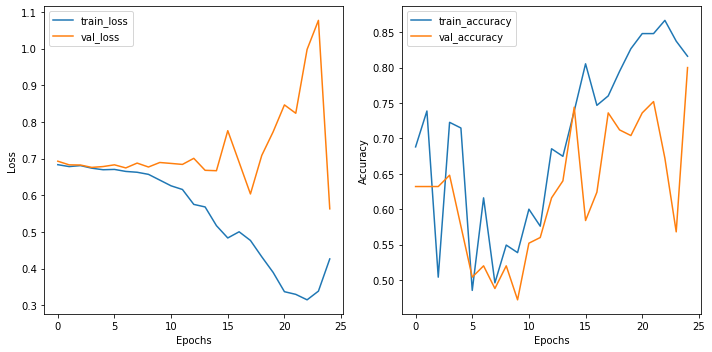

In [173]:
plot_metrics(model_19_results)

The loss and accuracy is still jumping around so much. I'd like to try and add some batch normalization in again to help stabilize. 

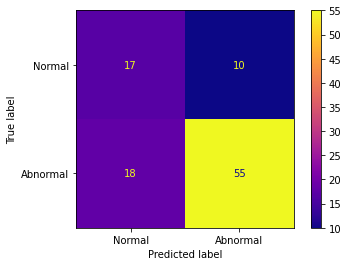

In [174]:
plot_cm(model_19)

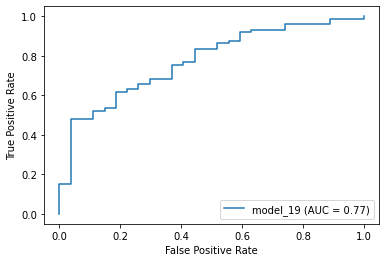

In [175]:
plot_roc(model_19, 'model_19')

We have a lot of false negatives and false positives here, and the AUC score of 0.77 suggets average performance overall. Let's try to stabilize the loss and accuracy. 

# Model #20
<hr style="border:2px solid pink">

Going back to model 12 as that model had decent results. Adding in batch normalization to try and stablize loss/accuracy.

In [176]:
model_20 = Sequential()

model_20.add(Conv2D(filters=32, 
                        kernel_size=(3,3), 
                        activation='relu', 
                        input_shape=input_shape, 
                        kernel_regularizer=l2(0.0001)))

model_20.add(Dense(64, activation='relu'))
model_20.add(MaxPooling2D(pool_size=(2,2)))
model_20.add(Dropout(0.3))

model_20.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.0001)))
model_20.add(Dense(64, activation='relu'))
model_20.add(MaxPooling2D(pool_size=(2,2)))
model_20.add(Dropout(0.2))

model_20.add(Conv2D(64, (3, 3), activation='relu'))
model_20.add(BatchNormalization()) # added
model_20.add(Dense(64, activation='relu'))
model_20.add(MaxPooling2D(pool_size=(2,2)))
model_20.add(Dropout(0.2))

model_20.add(Flatten())
model_20.add(Dense(64, activation='relu'))
model_20.add(Dense(32, activation='relu'))
model_20.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.0001)))

model_20.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision, recall])

model_20.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_53 (Conv2D)           (None, 62, 62, 32)        320       
_________________________________________________________________
dense_60 (Dense)             (None, 62, 62, 64)        2112      
_________________________________________________________________
max_pooling2d_53 (MaxPooling (None, 31, 31, 64)        0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 29, 29, 128)       73856     
_________________________________________________________________
dense_61 (Dense)             (None, 29, 29, 64)        8256      
_________________________________________________________________
max_pooling2d_54 (MaxPooling (None, 14, 14, 64)      

That increased the parameters a little bit, let's see how it does. 

In [177]:
model_20_results = model_20.fit(train_images, 
                              binary_train_labels, 
                              validation_split=0.25,
                              batch_size=50, 
                              epochs=25,
                              class_weight=class_weights_dict)

Epoch 1/25
8/8 [==============================] - 6s 764ms/step - loss: 0.7044 - accuracy: 0.5893 - precision: 0.7471 - recall: 0.7257 - val_loss: 0.7056 - val_accuracy: 0.3680 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/25
8/8 [==============================] - 4s 509ms/step - loss: 0.7006 - accuracy: 0.5733 - precision: 0.7312 - recall: 0.6679 - val_loss: 0.7004 - val_accuracy: 0.6160 - val_precision: 0.6396 - val_recall: 0.8987
Epoch 3/25
8/8 [==============================] - 4s 480ms/step - loss: 0.6686 - accuracy: 0.6480 - precision: 0.7580 - recall: 0.7690 - val_loss: 0.7015 - val_accuracy: 0.4480 - val_precision: 0.7500 - val_recall: 0.1899
Epoch 4/25
8/8 [==============================] - 3s 414ms/step - loss: 0.6631 - accuracy: 0.5840 - precision: 0.7840 - recall: 0.6029 - val_loss: 0.6994 - val_accuracy: 0.6000 - val_precision: 0.6495 - val_recall: 0.7975
Epoch 5/25
8/8 [==============================] - 3s 435ms/step - loss: 0.6518 - accuracy: 0.6480 - prec

In [178]:
evaluate_model(model_20)

4/4 [==============================] - 0s 54ms/step - loss: 0.6120 - accuracy: 0.6600 - precision: 0.8824 - recall: 0.6164
Training Loss: 0.521
Training Accuracy: 0.846
Training Precision: 0.927
Training Recall: 0.851
---------------------------
Testing Loss: 0.612
Testing Accuracy: 0.66
Testing Precision: 0.882
Testing Recall: 0.616


Scores are a little worse than the last model, and it's still overfit. Let's visualize the plots. 

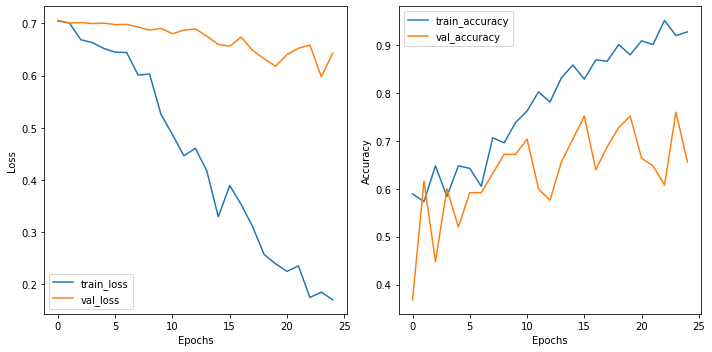

In [179]:
plot_metrics(model_20_results)

We have more of a curve direction here, and less fluctuations than before. 

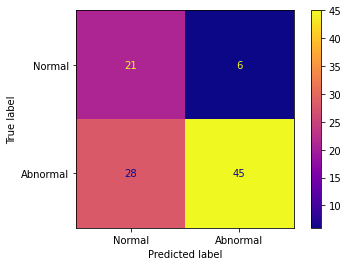

In [180]:
plot_cm(model_20)

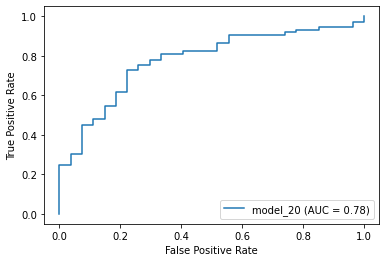

In [181]:
plot_roc(model_20, 'model_20')

We're starting to get a little more false negatives than is advisable. The model was pretty overfit, so let's increase regularization and add more batch normalization to stabilize the curves. 

# Model #21
<hr style="border:2px solid pink">

increasing regularization, added in another batch normalization. 

In [182]:
model_21 = Sequential()

model_21.add(Conv2D(filters=32, 
                        kernel_size=(3,3), 
                        activation='relu', 
                        input_shape=input_shape, 
                        kernel_regularizer=l2(0.0001)))
model_21.add(MaxPooling2D(pool_size=(2,2)))
model_21.add(Dropout(0.3))

model_21.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.0001)))
model_21.add(BatchNormalization())
model_21.add(MaxPooling2D(pool_size=(2,2)))
model_21.add(Dropout(0.3))

model_21.add(Conv2D(64, (3, 3), activation='relu'))
model_21.add(BatchNormalization())
model_21.add(MaxPooling2D(pool_size=(2,2)))
model_21.add(Dropout(0.2))

model_21.add(Flatten())
model_21.add(Dense(128, activation='relu'))
model_21.add(Dense(64, activation='relu'))
model_21.add(Dense(32, activation='relu'))
model_21.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.0001)))

model_21.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision, recall])

model_21.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_56 (Conv2D)           (None, 62, 62, 32)        320       
_________________________________________________________________
max_pooling2d_56 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 29, 29, 128)       36992     
_________________________________________________________________
batch_normalization_7 (Batch (None, 29, 29, 128)       512       
_________________________________________________________________
max_pooling2d_57 (MaxPooling (None, 14, 14, 128)       0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 14, 14, 128)     

In [183]:
model_21_results = model_21.fit(train_images, 
                                binary_train_labels, 
                                batch_size=50, 
                                epochs=25,
                                validation_split=0.25,
                                class_weight=class_weights_dict)

Epoch 1/25
8/8 [==============================] - 2s 196ms/step - loss: 0.9077 - accuracy: 0.5093 - precision: 0.7727 - recall: 0.5343 - val_loss: 0.6939 - val_accuracy: 0.6080 - val_precision: 0.6364 - val_recall: 0.8861
Epoch 2/25
8/8 [==============================] - 1s 158ms/step - loss: 0.6689 - accuracy: 0.6027 - precision: 0.7857 - recall: 0.6354 - val_loss: 0.6793 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 3/25
8/8 [==============================] - 1s 155ms/step - loss: 0.6197 - accuracy: 0.6560 - precision: 0.8364 - recall: 0.6643 - val_loss: 0.6735 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 4/25
8/8 [==============================] - 1s 157ms/step - loss: 0.5631 - accuracy: 0.6987 - precision: 0.8694 - recall: 0.6968 - val_loss: 0.7038 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 5/25
8/8 [==============================] - 1s 154ms/step - loss: 0.5049 - accuracy: 0.8000 - precision: 0

In [184]:
evaluate_model(model_21)

4/4 [==============================] - 0s 36ms/step - loss: 3.3050 - accuracy: 0.7300 - precision: 0.7300 - recall: 1.0000
Training Loss: 3.85
Training Accuracy: 0.712
Training Precision: 0.712
Training Recall: 1.0
---------------------------
Testing Loss: 3.31
Testing Accuracy: 0.73
Testing Precision: 0.73
Testing Recall: 1.0


Typical results - there have been several models with the same scores before this. Let's look at the plots. 

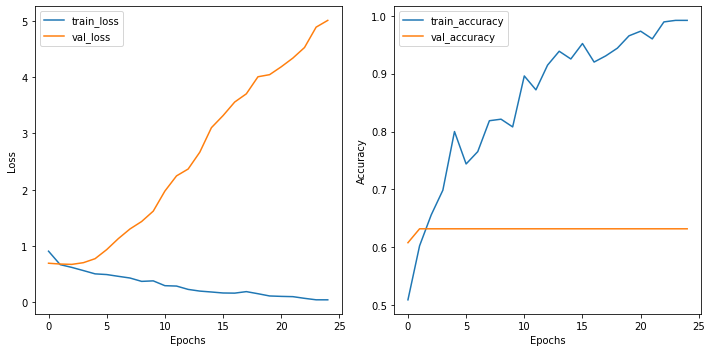

In [185]:
plot_metrics(model_21_results)

Validation loss is increasing instead of decreasing, and validation accuracy is stalled. Let's look at the confusion matrix and roc curve. 

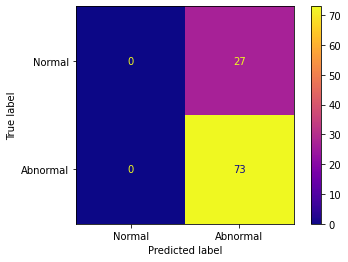

In [186]:
plot_cm(model_21)

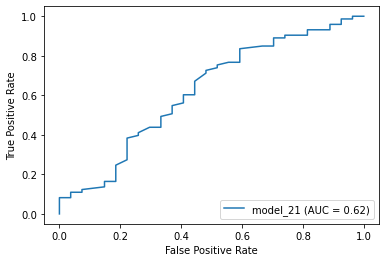

In [187]:
plot_roc(model_21, 'model_21')

We're back to the model only predicting the majority class. The AUC score of 0.62 reflects this. 

# Model #22
<hr style="border:2px solid pink">

I realized my best model was using tanh: Let's try some of the other successful models using tanh and see what the results are. 

Model #17 had great training scores, but was a little overfit. Let's see if tanh helps it. 

In [188]:
model_22 = Sequential()

model_22.add(Conv2D(filters=64, 
                        kernel_size=(3,3), 
                        activation='tanh', 
                        input_shape=input_shape, 
                        kernel_regularizer=l2(0.0001)))

model_22.add(MaxPooling2D(pool_size=(2,2)))
model_22.add(Dropout(0.3))

model_22.add(Conv2D(256, (3, 3), activation='tanh', kernel_regularizer=l2(0.0001))) # added
model_22.add(MaxPooling2D(pool_size=(2,2)))
model_22.add(Dropout(0.3))

model_22.add(Conv2D(128, (3, 3), activation='tanh'))
model_22.add(MaxPooling2D(pool_size=(2,2)))
model_22.add(Dropout(0.2))

model_22.add(Flatten())
model_22.add(Dense(128, activation='tanh'))
model_22.add(Dense(64, activation='tanh'))
model_22.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.0001)))

model_22.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision, recall])

model_22.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_59 (Conv2D)           (None, 62, 62, 64)        640       
_________________________________________________________________
max_pooling2d_59 (MaxPooling (None, 31, 31, 64)        0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 29, 29, 256)       147712    
_________________________________________________________________
max_pooling2d_60 (MaxPooling (None, 14, 14, 256)       0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 14, 14, 256)       0         
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 12, 12, 128)     

In [189]:
model_22_results = model_22.fit(train_images, 
                                binary_train_labels, 
                                batch_size=50, 
                                epochs=25,
                                validation_split=0.25,
                                class_weight=class_weights_dict)

Epoch 1/25
8/8 [==============================] - 7s 892ms/step - loss: 0.7878 - accuracy: 0.5627 - precision: 0.7524 - recall: 0.6771 - val_loss: 0.9911 - val_accuracy: 0.3680 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/25
8/8 [==============================] - 7s 831ms/step - loss: 0.7093 - accuracy: 0.4347 - precision: 0.7338 - recall: 0.3682 - val_loss: 0.6943 - val_accuracy: 0.5600 - val_precision: 0.7308 - val_recall: 0.4810
Epoch 3/25
8/8 [==============================] - 7s 868ms/step - loss: 0.6892 - accuracy: 0.6027 - precision: 0.7462 - recall: 0.7004 - val_loss: 0.6990 - val_accuracy: 0.5280 - val_precision: 0.8125 - val_recall: 0.3291
Epoch 4/25
8/8 [==============================] - 7s 844ms/step - loss: 0.6692 - accuracy: 0.5333 - precision: 0.7965 - recall: 0.4946 - val_loss: 0.6525 - val_accuracy: 0.6160 - val_precision: 0.6867 - val_recall: 0.7215
Epoch 5/25
8/8 [==============================] - 7s 848ms/step - loss: 0.6570 - accuracy: 0.6827 - prec

In [190]:
evaluate_model(model_22)

4/4 [==============================] - 0s 77ms/step - loss: 0.6374 - accuracy: 0.7800 - precision: 0.8148 - recall: 0.9041
Training Loss: 0.244
Training Accuracy: 0.93
Training Precision: 0.94
Training Recall: 0.963
---------------------------
Testing Loss: 0.637
Testing Accuracy: 0.78
Testing Precision: 0.815
Testing Recall: 0.904


That helped increase the testing scores a little bit! Let's play with this model and try to reduce the overfitting a little more. 

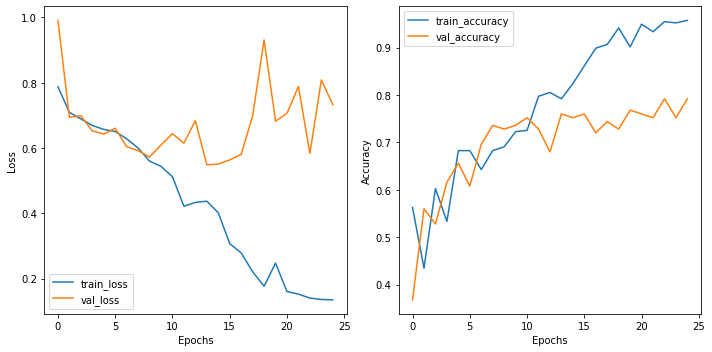

In [191]:
plot_metrics(model_22_results)

Validation loss is fluctuating and increasing, and both train and validation loss are jumping around. But, train loss looks good, and accuracy, although fluctuating, is generally increasing for both sets. 

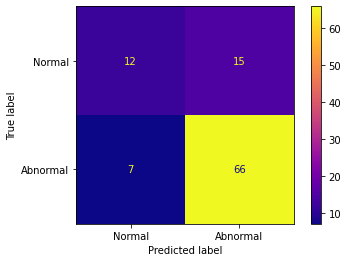

In [192]:
plot_cm(model_22)

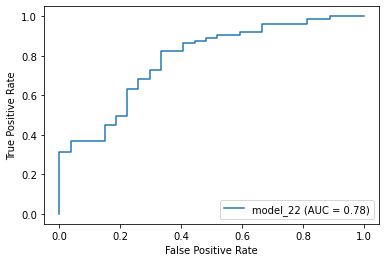

In [193]:
plot_roc(model_22, 'model_22')

A little bit better with minimizing false negatives! The model still has more false positives than true negatives, which isn't ideal. 

Let's add in a batch normalization at the end to try and help stabilization a little more. 

# Model #23
<hr style="border:2px solid pink">

In [194]:
model_23 = Sequential()

model_23.add(Conv2D(filters=64, 
                        kernel_size=(3,3), 
                        activation='tanh', 
                        input_shape=input_shape, 
                        kernel_regularizer=l2(0.0001)))

model_23.add(MaxPooling2D(pool_size=(2,2)))
model_23.add(Dropout(0.3))

model_23.add(Conv2D(256, (3, 3), activation='tanh', kernel_regularizer=l2(0.0001))) # added
model_23.add(MaxPooling2D(pool_size=(2,2)))
model_23.add(Dropout(0.3))

model_23.add(Conv2D(128, (3, 3), activation='tanh'))
model_23.add(BatchNormalization()) # added
model_23.add(MaxPooling2D(pool_size=(2,2)))
model_23.add(Dropout(0.2))

model_23.add(Flatten())
model_23.add(Dense(128, activation='tanh'))
model_23.add(Dense(64, activation='tanh'))
model_23.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.0001)))

model_23.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision, recall])

model_23.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_62 (Conv2D)           (None, 62, 62, 64)        640       
_________________________________________________________________
max_pooling2d_62 (MaxPooling (None, 31, 31, 64)        0         
_________________________________________________________________
dropout_27 (Dropout)         (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_63 (Conv2D)           (None, 29, 29, 256)       147712    
_________________________________________________________________
max_pooling2d_63 (MaxPooling (None, 14, 14, 256)       0         
_________________________________________________________________
dropout_28 (Dropout)         (None, 14, 14, 256)       0         
_________________________________________________________________
conv2d_64 (Conv2D)           (None, 12, 12, 128)     

This added a few more parameters. Let's see how it does. 

In [195]:
model_23_results = model_23.fit(train_images, 
                                binary_train_labels, 
                                batch_size=50, 
                                epochs=25,
                                validation_split=0.25,
                                class_weight=class_weights_dict)

Epoch 1/25
8/8 [==============================] - 9s 1s/step - loss: 1.0438 - accuracy: 0.5173 - precision: 0.7653 - recall: 0.6057 - val_loss: 0.6901 - val_accuracy: 0.5920 - val_precision: 0.6892 - val_recall: 0.6456
Epoch 2/25
8/8 [==============================] - 6s 736ms/step - loss: 0.6741 - accuracy: 0.6133 - precision: 0.7578 - recall: 0.7004 - val_loss: 0.6803 - val_accuracy: 0.6320 - val_precision: 0.6634 - val_recall: 0.8481
Epoch 3/25
8/8 [==============================] - 6s 796ms/step - loss: 0.6612 - accuracy: 0.6613 - precision: 0.7778 - recall: 0.7581 - val_loss: 0.6961 - val_accuracy: 0.5440 - val_precision: 0.6486 - val_recall: 0.6076
Epoch 4/25
8/8 [==============================] - 6s 811ms/step - loss: 0.6318 - accuracy: 0.6453 - precision: 0.8429 - recall: 0.6390 - val_loss: 0.7154 - val_accuracy: 0.4880 - val_precision: 0.6667 - val_recall: 0.3797
Epoch 5/25
8/8 [==============================] - 7s 861ms/step - loss: 0.6148 - accuracy: 0.7227 - precision: 0.84

In [196]:
evaluate_model(model_23)

4/4 [==============================] - 0s 77ms/step - loss: 0.5415 - accuracy: 0.7300 - precision: 0.8710 - recall: 0.7397
Training Loss: 0.41
Training Accuracy: 0.834
Training Precision: 0.885
Training Recall: 0.882
---------------------------
Testing Loss: 0.541
Testing Accuracy: 0.73
Testing Precision: 0.871
Testing Recall: 0.74


Scores are a little lower all around, and precision is still higher than recall for the test set. Let's look at the plots. 

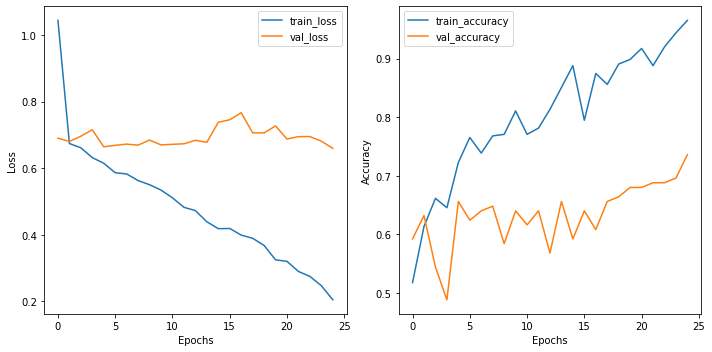

In [197]:
plot_metrics(model_23_results)

Train loss is decreasing pretty quickly, and validation loss is slowly fluctuating, but not really increasing or decreasing drastically. Accuracy is curved upwards, but is fluctuating quite a bit. 

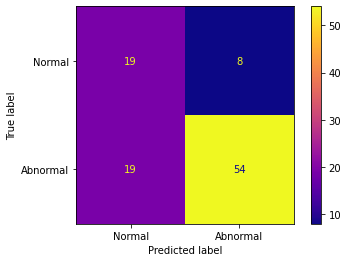

In [199]:
plot_cm(model_23)

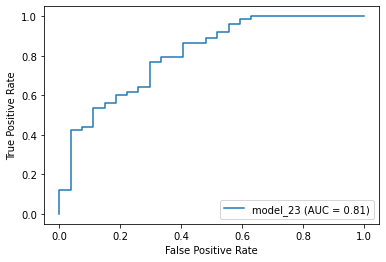

In [200]:
plot_roc(model_23, 'model_23')

We're back to minimizing false positives over false negatives. The AUC score is 0.81, which is okay. 

# Model #24
<hr style="border:2px solid pink">

Let's remove the batch normalization, and add some L2 regularization at a low strength to address the overfitting instead. 

In [201]:
model_24 = Sequential()

model_24.add(Conv2D(filters=64, 
                        kernel_size=(3,3), 
                        activation='tanh', 
                        input_shape=input_shape, 
                        kernel_regularizer=l2(0.0001)))

model_24.add(MaxPooling2D(pool_size=(2,2)))
model_24.add(Dropout(0.3))

model_24.add(Conv2D(256, (3, 3), activation='tanh', kernel_regularizer=l2(0.00001)))
model_24.add(MaxPooling2D(pool_size=(2,2)))
model_24.add(Dropout(0.3))

model_24.add(Conv2D(128, (3, 3), activation='tanh', kernel_regularizer=l2(0.00001)))
model_24.add(MaxPooling2D(pool_size=(2,2)))
model_24.add(Dropout(0.2))

model_24.add(Flatten())
model_24.add(Dense(128, activation='tanh'))
model_24.add(Dense(64, activation='tanh'))
model_24.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.0001)))

model_24.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision, recall])

model_24.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_65 (Conv2D)           (None, 62, 62, 64)        640       
_________________________________________________________________
max_pooling2d_65 (MaxPooling (None, 31, 31, 64)        0         
_________________________________________________________________
dropout_30 (Dropout)         (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 29, 29, 256)       147712    
_________________________________________________________________
max_pooling2d_66 (MaxPooling (None, 14, 14, 256)       0         
_________________________________________________________________
dropout_31 (Dropout)         (None, 14, 14, 256)       0         
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 12, 12, 128)     

In [202]:
model_24_results = model_24.fit(train_images, 
                                binary_train_labels, 
                                batch_size=50, 
                                epochs=25,
                                validation_split=0.25,
                                class_weight=class_weights_dict)

Epoch 1/25
8/8 [==============================] - 3s 372ms/step - loss: 0.6941 - accuracy: 0.5440 - precision: 0.7946 - recall: 0.5857 - val_loss: 0.6669 - val_accuracy: 0.6720 - val_precision: 0.7065 - val_recall: 0.8228
Epoch 2/25
8/8 [==============================] - 3s 328ms/step - loss: 0.6932 - accuracy: 0.5547 - precision: 0.7412 - recall: 0.6101 - val_loss: 0.6653 - val_accuracy: 0.6560 - val_precision: 0.7195 - val_recall: 0.7468
Epoch 3/25
8/8 [==============================] - 3s 313ms/step - loss: 0.6727 - accuracy: 0.5520 - precision: 0.7685 - recall: 0.5632 - val_loss: 0.6379 - val_accuracy: 0.6240 - val_precision: 0.6290 - val_recall: 0.9873
Epoch 4/25
8/8 [==============================] - 3s 338ms/step - loss: 0.6649 - accuracy: 0.5680 - precision: 0.7700 - recall: 0.5921 - val_loss: 0.6792 - val_accuracy: 0.5360 - val_precision: 0.7561 - val_recall: 0.3924
Epoch 5/25
8/8 [==============================] - 5s 572ms/step - loss: 0.6524 - accuracy: 0.5973 - precision: 0

In [203]:
evaluate_model(model_24)

4/4 [==============================] - 0s 80ms/step - loss: 1.0068 - accuracy: 0.8100 - precision: 0.8000 - recall: 0.9863
Training Loss: 0.422
Training Accuracy: 0.908
Training Precision: 0.887
Training Recall: 0.997
---------------------------
Testing Loss: 1.01
Testing Accuracy: 0.81
Testing Precision: 0.8
Testing Recall: 0.986


Pretty good train scores! It's a little overfit, and the test loss looks pretty high, but recall is higher than precision at least. Let's look at loss and accuracy. 

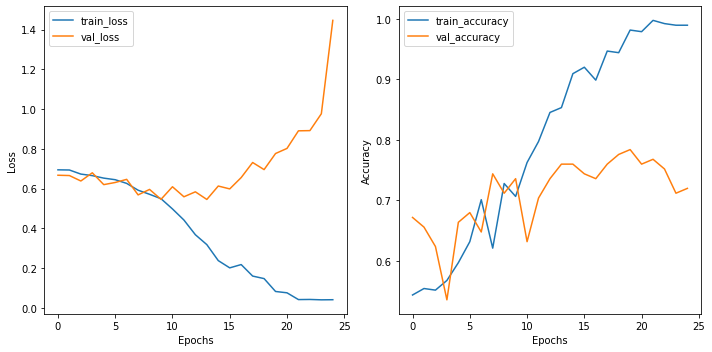

In [204]:
plot_metrics(model_24_results)

Train loss and train accuracy are actually pretty good! Loss is curving down pretty smoothly, and accuracy increases with small fluctuations. Validation loss however is curving upwards, starting just after 15 epochs, and accuracy is jumping all over the place. 

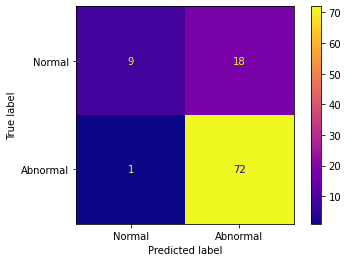

In [205]:
plot_cm(model_24)

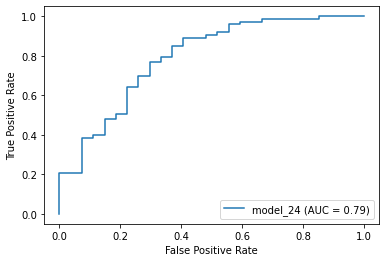

In [219]:
plot_roc(model_24, 'model_24')

The model looks like it's mostly predicting the majority class. False negatives look great though, only 1!

Let's try increasing the dropout rates to address the overfitting. 

# Model #25
<hr style="border:2px solid pink">

In [206]:
model_25 = Sequential()

model_25.add(Conv2D(filters=64, 
                        kernel_size=(3,3), 
                        activation='tanh', 
                        input_shape=input_shape, 
                        kernel_regularizer=l2(0.0001)))

model_25.add(MaxPooling2D(pool_size=(2,2)))
model_25.add(Dropout(0.3))

model_25.add(Conv2D(256, (3, 3), activation='tanh', kernel_regularizer=l2(0.0001)))
model_25.add(MaxPooling2D(pool_size=(2,2)))
model_25.add(Dropout(0.4)) # increased

model_25.add(Conv2D(128, (3, 3), activation='tanh'))
model_25.add(MaxPooling2D(pool_size=(2,2)))
model_25.add(Dropout(0.3)) # increased

model_25.add(Flatten())
model_25.add(Dense(128, activation='tanh'))
model_25.add(Dense(64, activation='tanh'))
model_25.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.0001)))

model_25.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision, recall])

model_25.summary()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_68 (Conv2D)           (None, 62, 62, 64)        640       
_________________________________________________________________
max_pooling2d_68 (MaxPooling (None, 31, 31, 64)        0         
_________________________________________________________________
dropout_33 (Dropout)         (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_69 (Conv2D)           (None, 29, 29, 256)       147712    
_________________________________________________________________
max_pooling2d_69 (MaxPooling (None, 14, 14, 256)       0         
_________________________________________________________________
dropout_34 (Dropout)         (None, 14, 14, 256)       0         
_________________________________________________________________
conv2d_70 (Conv2D)           (None, 12, 12, 128)     

In [207]:
model_25_results = model_25.fit(train_images, 
                                binary_train_labels, 
                                batch_size=50, 
                                epochs=25,
                                validation_split=0.25,
                                class_weight=class_weights_dict)

Epoch 1/25
8/8 [==============================] - 7s 906ms/step - loss: 0.8277 - accuracy: 0.4853 - precision: 0.7500 - recall: 0.5914 - val_loss: 0.6713 - val_accuracy: 0.6480 - val_precision: 0.6636 - val_recall: 0.8987
Epoch 2/25
8/8 [==============================] - 7s 867ms/step - loss: 0.6844 - accuracy: 0.6747 - precision: 0.7592 - recall: 0.8195 - val_loss: 0.6800 - val_accuracy: 0.6160 - val_precision: 0.6914 - val_recall: 0.7089
Epoch 3/25
8/8 [==============================] - 7s 849ms/step - loss: 0.6726 - accuracy: 0.5280 - precision: 0.7976 - recall: 0.4838 - val_loss: 0.6467 - val_accuracy: 0.6240 - val_precision: 0.6311 - val_recall: 0.9747
Epoch 4/25
8/8 [==============================] - 7s 824ms/step - loss: 0.6679 - accuracy: 0.6267 - precision: 0.7729 - recall: 0.7004 - val_loss: 0.6751 - val_accuracy: 0.5680 - val_precision: 0.6984 - val_recall: 0.5570
Epoch 5/25
8/8 [==============================] - 7s 827ms/step - loss: 0.6539 - accuracy: 0.6080 - precision: 0

In [208]:
evaluate_model(model_25)

4/4 [==============================] - 0s 77ms/step - loss: 1.0157 - accuracy: 0.7400 - precision: 0.8310 - recall: 0.8082
Training Loss: 0.273
Training Accuracy: 0.932
Training Precision: 0.935
Training Recall: 0.972
---------------------------
Testing Loss: 1.02
Testing Accuracy: 0.74
Testing Precision: 0.831
Testing Recall: 0.808


A little worse than the last model for the testing scores. Let's try adjusting the learning rate next. But first, let's look at the loss, accuracy, confusion matrix, and roc curves for this model.

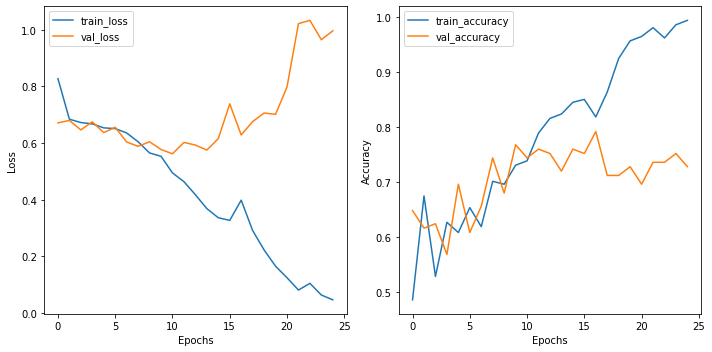

In [209]:
plot_metrics(model_25_results)

Training loss and accuracy are a little more rough than the last model, but still pretty good. Testing loss and accuracy are a little more sporadic than the last model. 

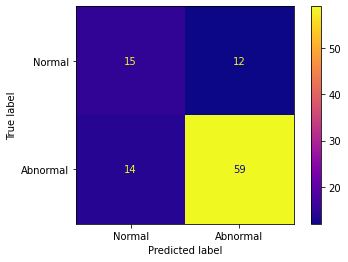

In [210]:
plot_cm(model_25)

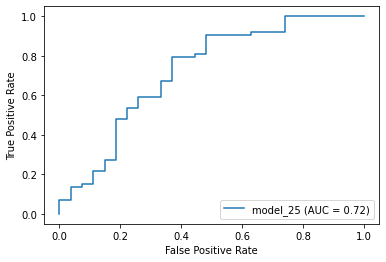

In [211]:
plot_roc(model_25, 'model_25')

The confusion matrix is showing a pretty even spread between true negatives, false negatives, and false positives. The AUC score of 0.72 suggests average performance. 

I'd like to see how learning rate impacts the model. 

# Model #26
<hr style="border:2px solid pink">

Starting with model #22 as a base. Then, we'll adjust the learning rate, starting with 0.00001 in the compile step. 

In [212]:
model_26 = Sequential()

model_26.add(Conv2D(filters=64, 
                        kernel_size=(3,3), 
                        activation='tanh', 
                        input_shape=input_shape, 
                        kernel_regularizer=l2(0.0001)))

model_26.add(MaxPooling2D(pool_size=(2,2)))
model_26.add(Dropout(0.3))

model_26.add(Conv2D(256, (3, 3), activation='tanh', kernel_regularizer=l2(0.0001))) # added
model_26.add(MaxPooling2D(pool_size=(2,2)))
model_26.add(Dropout(0.3))

model_26.add(Conv2D(128, (3, 3), activation='tanh'))
model_26.add(MaxPooling2D(pool_size=(2,2)))
model_26.add(Dropout(0.2))

model_26.add(Flatten())
model_26.add(Dense(128, activation='tanh'))
model_26.add(Dense(64, activation='tanh'))
model_26.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.0001)))

# add the learning rate
model_26.compile(optimizer=Adam(0.00001), loss='binary_crossentropy', metrics=['accuracy', precision, recall])

model_26.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_71 (Conv2D)           (None, 62, 62, 64)        640       
_________________________________________________________________
max_pooling2d_71 (MaxPooling (None, 31, 31, 64)        0         
_________________________________________________________________
dropout_36 (Dropout)         (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_72 (Conv2D)           (None, 29, 29, 256)       147712    
_________________________________________________________________
max_pooling2d_72 (MaxPooling (None, 14, 14, 256)       0         
_________________________________________________________________
dropout_37 (Dropout)         (None, 14, 14, 256)       0         
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 12, 12, 128)     

In [213]:
model_26_results = model_26.fit(train_images, 
                                binary_train_labels, 
                                batch_size=50, 
                                epochs=25,
                                validation_split=0.25,
                                class_weight=class_weights_dict)

Epoch 1/25
8/8 [==============================] - 8s 1s/step - loss: 0.6793 - accuracy: 0.5067 - precision: 0.7957 - recall: 0.5343 - val_loss: 0.7057 - val_accuracy: 0.4560 - val_precision: 0.6222 - val_recall: 0.3544
Epoch 2/25
8/8 [==============================] - 8s 942ms/step - loss: 0.6817 - accuracy: 0.6000 - precision: 0.7592 - recall: 0.6715 - val_loss: 0.7001 - val_accuracy: 0.5840 - val_precision: 0.6901 - val_recall: 0.6203
Epoch 3/25
8/8 [==============================] - 7s 868ms/step - loss: 0.6812 - accuracy: 0.7013 - precision: 0.7586 - recall: 0.8736 - val_loss: 0.6957 - val_accuracy: 0.6000 - val_precision: 0.6629 - val_recall: 0.7468
Epoch 4/25
8/8 [==============================] - 7s 870ms/step - loss: 0.6769 - accuracy: 0.6960 - precision: 0.7477 - recall: 0.8881 - val_loss: 0.6943 - val_accuracy: 0.5920 - val_precision: 0.6556 - val_recall: 0.7468
Epoch 5/25
8/8 [==============================] - 7s 837ms/step - loss: 0.6801 - accuracy: 0.6800 - precision: 0.74

In [214]:
evaluate_model(model_26)

4/4 [==============================] - 0s 72ms/step - loss: 0.6947 - accuracy: 0.5600 - precision: 0.8537 - recall: 0.4795
Training Loss: 0.673
Training Accuracy: 0.646
Training Precision: 0.751
Training Recall: 0.753
---------------------------
Testing Loss: 0.695
Testing Accuracy: 0.56
Testing Precision: 0.854
Testing Recall: 0.479


That decreased the variance between training and testing accuracy, but also decreased the scores overall. Let's try a smaller learning rate and see how it does. 

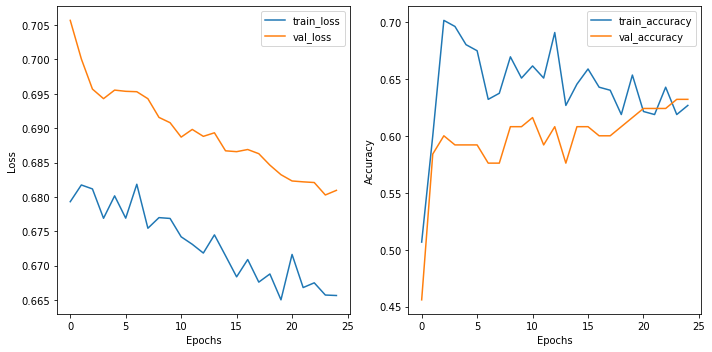

In [215]:
plot_metrics(model_26_results)

The loss functions are both decreasing mostly smoothly, with a few fluctuations. For the first time in a while, the validation loss looks pretty good! Train and validation accuracy are both mostly increasing, but are fluctuating pretty frequently. 

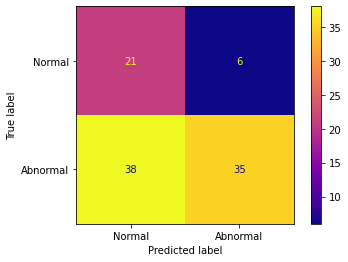

In [217]:
plot_cm(model_26)

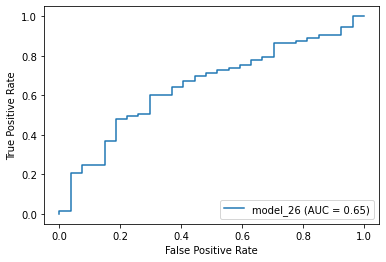

In [218]:
plot_roc(model_26, 'model_26')

The model is doing a good job at minimizing false positives, but not so great a job at minimizing false negatives. AUC of 0.65 suggests slightly less than average performance. 

Let's try a smaller learning rate of 0.0000000001. I will use the same model as above, but call is model_26_v2. 

# Model #26_v2
<hr style="border:2px solid pink">

In [220]:
model_26_v2 = Sequential()

model_26_v2.add(Conv2D(filters=64, 
                        kernel_size=(3,3), 
                        activation='tanh', 
                        input_shape=input_shape, 
                        kernel_regularizer=l2(0.0001)))

model_26_v2.add(MaxPooling2D(pool_size=(2,2)))
model_26_v2.add(Dropout(0.3))

model_26_v2.add(Conv2D(256, (3, 3), activation='tanh', kernel_regularizer=l2(0.0001))) # added
model_26_v2.add(MaxPooling2D(pool_size=(2,2)))
model_26_v2.add(Dropout(0.3))

model_26_v2.add(Conv2D(128, (3, 3), activation='tanh'))
model_26_v2.add(MaxPooling2D(pool_size=(2,2)))
model_26_v2.add(Dropout(0.2))

model_26_v2.add(Flatten())
model_26_v2.add(Dense(128, activation='tanh'))
model_26_v2.add(Dense(64, activation='tanh'))
model_26_v2.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.0001)))

model_26_v2.compile(optimizer=Adam(0.0000000001), loss='binary_crossentropy', metrics=['accuracy', precision, recall])

model_26_v2.summary()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_74 (Conv2D)           (None, 62, 62, 64)        640       
_________________________________________________________________
max_pooling2d_74 (MaxPooling (None, 31, 31, 64)        0         
_________________________________________________________________
dropout_39 (Dropout)         (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_75 (Conv2D)           (None, 29, 29, 256)       147712    
_________________________________________________________________
max_pooling2d_75 (MaxPooling (None, 14, 14, 256)       0         
_________________________________________________________________
dropout_40 (Dropout)         (None, 14, 14, 256)       0         
_________________________________________________________________
conv2d_76 (Conv2D)           (None, 12, 12, 128)     

In [221]:
model_26_v2_results = model_26_v2.fit(train_images, 
                                binary_train_labels, 
                                batch_size=50, 
                                epochs=25,
                                validation_split=0.25,
                                class_weight=class_weights_dict)

Epoch 1/25
8/8 [==============================] - 3s 378ms/step - loss: 0.6876 - accuracy: 0.4533 - precision: 0.7563 - recall: 0.4257 - val_loss: 0.7051 - val_accuracy: 0.4960 - val_precision: 0.7222 - val_recall: 0.3291
Epoch 2/25
8/8 [==============================] - 3s 314ms/step - loss: 0.6828 - accuracy: 0.4907 - precision: 0.7722 - recall: 0.4404 - val_loss: 0.7051 - val_accuracy: 0.4960 - val_precision: 0.7222 - val_recall: 0.3291
Epoch 3/25
8/8 [==============================] - 3s 313ms/step - loss: 0.6853 - accuracy: 0.4453 - precision: 0.7170 - recall: 0.4116 - val_loss: 0.7051 - val_accuracy: 0.4960 - val_precision: 0.7222 - val_recall: 0.3291
Epoch 4/25
8/8 [==============================] - 3s 343ms/step - loss: 0.6868 - accuracy: 0.4640 - precision: 0.7289 - recall: 0.4368 - val_loss: 0.7051 - val_accuracy: 0.4960 - val_precision: 0.7222 - val_recall: 0.3291
Epoch 5/25
8/8 [==============================] - 4s 553ms/step - loss: 0.6876 - accuracy: 0.4533 - precision: 0

In [222]:
evaluate_model(model_26_v2)

4/4 [==============================] - 0s 78ms/step - loss: 0.7052 - accuracy: 0.4900 - precision: 0.8056 - recall: 0.3973
Training Loss: 0.706
Training Accuracy: 0.4
Training Precision: 0.709
Training Recall: 0.267
---------------------------
Testing Loss: 0.705
Testing Accuracy: 0.49
Testing Precision: 0.806
Testing Recall: 0.397


That really decreased the scores! Training accuracy is at 40%, precision at 71%, and recall at 27%, while testing accuracy is slightly better at 49%, precision at 81%, and recall at 40%. 

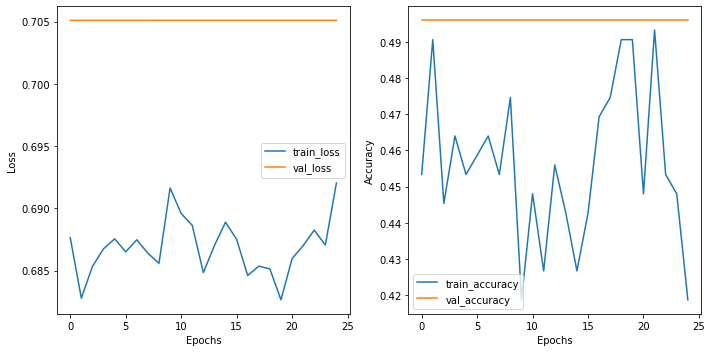

In [223]:
plot_metrics(model_26_v2_results)

Validation loss and accuracy are completely stalled, while training loss and accuracy is fluctuating at extremes! It seems the higher learning rate was better, but not as good at the default. 

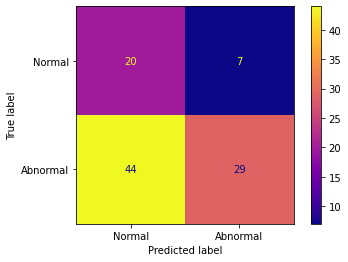

In [224]:
plot_cm(model_26_v2)

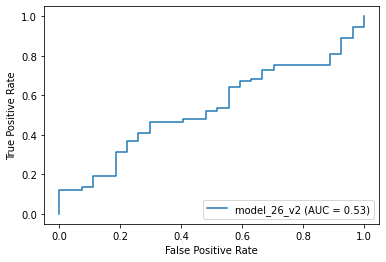

In [225]:
plot_roc(model_26_v2, 'model_26_v2')

The confusion matrix shows the there are more false negatives than false positives, which makes sense since precision was the only metric to have a decent score. The AUC score of 0.53 reflects the metrics as well - this was not a good model. 

I feel like the complexity helped the training score so much, and testing scores were pretty decent as well, so let's add another round of layers, and more hidden ones as well. 

# Model #27
<hr style="border:2px solid pink">

Let's try adding 1 more round of Conv2d, Maxpooling, and Dropout, and then another hidden dense layer. 

In [226]:
model_27 = Sequential()

model_27.add(Conv2D(filters=64, 
                        kernel_size=(3,3), 
                        activation='tanh', 
                        input_shape=input_shape, 
                        kernel_regularizer=l2(0.0001)))

model_27.add(MaxPooling2D(pool_size=(2,2)))
model_27.add(Dropout(0.3))

model_27.add(Conv2D(256, (3, 3), activation='tanh', kernel_regularizer=l2(0.0001))) # added
model_27.add(MaxPooling2D(pool_size=(2,2)))
model_27.add(Dropout(0.3))

model_27.add(Conv2D(128, (3, 3), activation='tanh'))
model_27.add(MaxPooling2D(pool_size=(2,2)))
model_27.add(Dropout(0.2))

# added
model_27.add(Conv2D(64, (3, 3), activation='tanh'))
model_27.add(MaxPooling2D(pool_size=(2,2)))
model_27.add(Dropout(0.2))

model_27.add(Flatten())
model_27.add(Dense(128, activation='tanh'))
model_27.add(Dense(64, activation='tanh'))
model_27.add(Dense(32, activation='tanh')) # added          
model_27.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.0001)))

model_27.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision, recall])

model_27.summary()

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_77 (Conv2D)           (None, 62, 62, 64)        640       
_________________________________________________________________
max_pooling2d_77 (MaxPooling (None, 31, 31, 64)        0         
_________________________________________________________________
dropout_42 (Dropout)         (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_78 (Conv2D)           (None, 29, 29, 256)       147712    
_________________________________________________________________
max_pooling2d_78 (MaxPooling (None, 14, 14, 256)       0         
_________________________________________________________________
dropout_43 (Dropout)         (None, 14, 14, 256)       0         
_________________________________________________________________
conv2d_79 (Conv2D)           (None, 12, 12, 128)     

That decreased the parameters by about half. Let's see how it does. 

In [227]:
model_27_results = model_27.fit(train_images, 
                                binary_train_labels, 
                                batch_size=50, 
                                epochs=25,
                                validation_split=0.25,
                                class_weight=class_weights_dict)

Epoch 1/25
8/8 [==============================] - 6s 793ms/step - loss: 0.7372 - accuracy: 0.5200 - precision: 0.7280 - recall: 0.5429 - val_loss: 0.6900 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 2/25
8/8 [==============================] - 6s 719ms/step - loss: 0.6877 - accuracy: 0.4587 - precision: 0.7569 - recall: 0.3935 - val_loss: 0.6559 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 3/25
8/8 [==============================] - 6s 712ms/step - loss: 0.6813 - accuracy: 0.5707 - precision: 0.7283 - recall: 0.6679 - val_loss: 0.6826 - val_accuracy: 0.5920 - val_precision: 0.7188 - val_recall: 0.5823
Epoch 4/25
8/8 [==============================] - 6s 713ms/step - loss: 0.6812 - accuracy: 0.6667 - precision: 0.7533 - recall: 0.8159 - val_loss: 0.7088 - val_accuracy: 0.4960 - val_precision: 0.6905 - val_recall: 0.3671
Epoch 5/25
8/8 [==============================] - 6s 699ms/step - loss: 0.6631 - accuracy: 0.4640 - precision: 0

In [228]:
evaluate_model(model_27)

4/4 [==============================] - 0s 83ms/step - loss: 0.7852 - accuracy: 0.7000 - precision: 0.9216 - recall: 0.6438
Training Loss: 0.343
Training Accuracy: 0.88
Training Precision: 0.935
Training Recall: 0.893
---------------------------
Testing Loss: 0.785
Testing Accuracy: 0.7
Testing Precision: 0.922
Testing Recall: 0.644


Training scores are much better! Back in the high 80s/low 90s for all the key metrics. Testing scores are average, with accuracy at 70%, precision at 92%, and recall at 64%. Let's view the plots. 

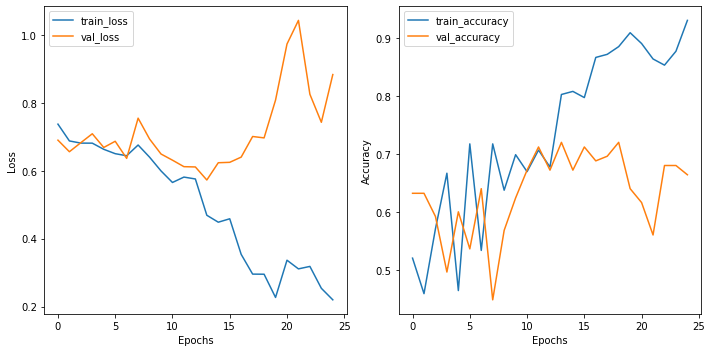

In [229]:
plot_metrics(model_27_results)

Once again, we have so many fluctuations!

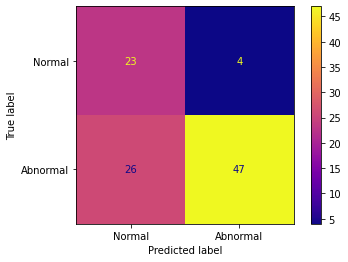

In [230]:
plot_cm(model_27)

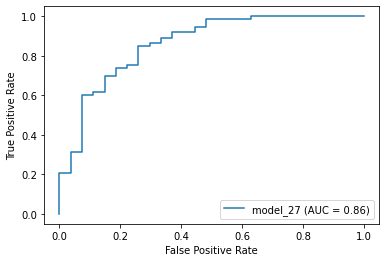

In [231]:
plot_roc(model_27, 'model_27')

The confusion matrix reflects the precision and recall scores - there are barely any false positives (only 4), and more false negatives (26) than true negatives (23)!

Let's try and get that overfitting under control. 

# Model #28
<hr style="border:2px solid pink">

Let's strengthen the regularization to help with the regularization. 

In [232]:
model_28 = Sequential()

model_28.add(Conv2D(filters=64, 
                        kernel_size=(3,3), 
                        activation='tanh', 
                        input_shape=input_shape, 
                        kernel_regularizer=l2(0.0001)))

model_28.add(MaxPooling2D(pool_size=(2,2)))
model_28.add(Dropout(0.3))

model_28.add(Conv2D(256, (3, 3), activation='tanh', kernel_regularizer=l2(0.0001)))
model_28.add(MaxPooling2D(pool_size=(2,2)))
model_28.add(Dropout(0.3))

model_28.add(Conv2D(128, (3, 3), activation='tanh', kernel_regularizer=l2(0.0001)))
model_28.add(MaxPooling2D(pool_size=(2,2)))
model_28.add(Dropout(0.2))

# added
model_28.add(Conv2D(64, (3, 3), activation='tanh', kernel_regularizer=l2(0.0001)))
model_28.add(MaxPooling2D(pool_size=(2,2)))
model_28.add(Dropout(0.2))

model_28.add(Flatten())
model_28.add(Dense(128, activation='tanh'))
model_28.add(Dense(64, activation='tanh'))
model_28.add(Dense(32, activation='tanh')) # added          
model_28.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.0001)))

model_28.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision, recall])

model_28.summary()

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_81 (Conv2D)           (None, 62, 62, 64)        640       
_________________________________________________________________
max_pooling2d_81 (MaxPooling (None, 31, 31, 64)        0         
_________________________________________________________________
dropout_46 (Dropout)         (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_82 (Conv2D)           (None, 29, 29, 256)       147712    
_________________________________________________________________
max_pooling2d_82 (MaxPooling (None, 14, 14, 256)       0         
_________________________________________________________________
dropout_47 (Dropout)         (None, 14, 14, 256)       0         
_________________________________________________________________
conv2d_83 (Conv2D)           (None, 12, 12, 128)     

In [233]:
model_28_results = model_28.fit(train_images, 
                                binary_train_labels, 
                                batch_size=50, 
                                epochs=25,
                                validation_split=0.25,
                                class_weight=class_weights_dict)

Epoch 1/25
8/8 [==============================] - 8s 967ms/step - loss: 0.7504 - accuracy: 0.5947 - precision: 0.7781 - recall: 0.6714 - val_loss: 0.7402 - val_accuracy: 0.4160 - val_precision: 0.6154 - val_recall: 0.2025
Epoch 2/25
8/8 [==============================] - 6s 793ms/step - loss: 0.7032 - accuracy: 0.6320 - precision: 0.7747 - recall: 0.7076 - val_loss: 0.6823 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 3/25
8/8 [==============================] - 7s 838ms/step - loss: 0.7225 - accuracy: 0.5600 - precision: 0.7545 - recall: 0.5993 - val_loss: 0.7034 - val_accuracy: 0.6240 - val_precision: 0.6538 - val_recall: 0.8608
Epoch 4/25
8/8 [==============================] - 8s 965ms/step - loss: 0.7014 - accuracy: 0.6400 - precision: 0.7669 - recall: 0.7365 - val_loss: 0.7048 - val_accuracy: 0.5680 - val_precision: 0.6812 - val_recall: 0.5949
Epoch 5/25
8/8 [==============================] - 7s 837ms/step - loss: 0.6905 - accuracy: 0.6400 - precision: 0

In [234]:
evaluate_model(model_28)

4/4 [==============================] - 0s 79ms/step - loss: 0.9519 - accuracy: 0.6700 - precision: 0.9348 - recall: 0.5890
Training Loss: 0.493
Training Accuracy: 0.81
Training Precision: 0.948
Training Recall: 0.775
---------------------------
Testing Loss: 0.952
Testing Accuracy: 0.67
Testing Precision: 0.935
Testing Recall: 0.589


That helped lower the variance between training and testing accuracy, but testing accuracy is now only 67%. Let's view the plots. 

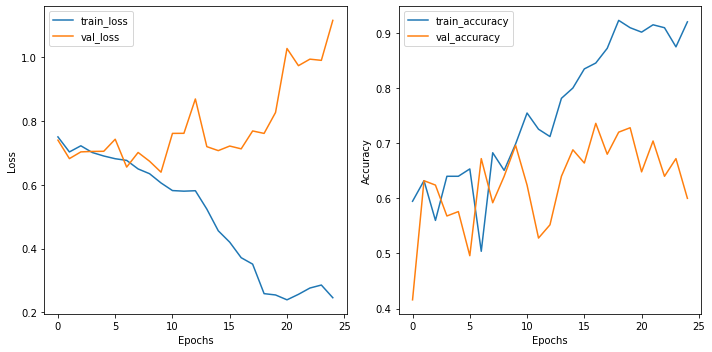

In [235]:
plot_metrics(model_28_results)

Training loss and accuracy aren't too bad, there are a few fluctuations but nothing compared to the validation set. 

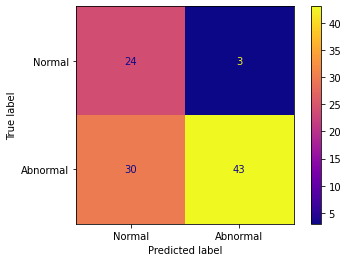

In [236]:
plot_cm(model_28)

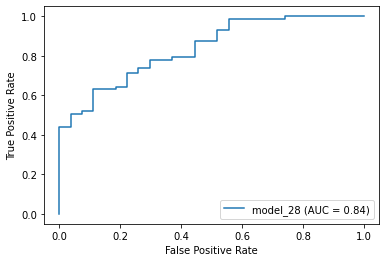

In [237]:
plot_roc(model_28, 'model_28')

Same as the previous model - there aren't too many false positives, but there are more false negatives than true negatives, which is less than ideal. 

# Model #29
<hr style="border:2px solid pink">

Let play around with the layers and remove the ones we just added, but keep the dense hidden layer. 

In [238]:
model_29 = Sequential()

model_29.add(Conv2D(filters=64, 
                        kernel_size=(3,3), 
                        activation='tanh', 
                        input_shape=input_shape, 
                        kernel_regularizer=l2(0.0001)))

model_29.add(MaxPooling2D(pool_size=(2,2)))
model_29.add(Dropout(0.3))

model_29.add(Conv2D(256, (3, 3), activation='tanh', kernel_regularizer=l2(0.0001)))
model_29.add(MaxPooling2D(pool_size=(2,2)))
model_29.add(Dropout(0.3))

model_29.add(Conv2D(128, (3, 3), activation='tanh', kernel_regularizer=l2(0.0001)))
model_29.add(MaxPooling2D(pool_size=(2,2)))
model_29.add(Dropout(0.2))

model_29.add(Flatten())
model_29.add(Dense(128, activation='tanh'))
model_29.add(Dense(64, activation='tanh'))
model_29.add(Dense(32, activation='tanh')) # added          
model_29.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.0001)))

model_29.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision, recall])

model_29.summary()

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_85 (Conv2D)           (None, 62, 62, 64)        640       
_________________________________________________________________
max_pooling2d_85 (MaxPooling (None, 31, 31, 64)        0         
_________________________________________________________________
dropout_50 (Dropout)         (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_86 (Conv2D)           (None, 29, 29, 256)       147712    
_________________________________________________________________
max_pooling2d_86 (MaxPooling (None, 14, 14, 256)       0         
_________________________________________________________________
dropout_51 (Dropout)         (None, 14, 14, 256)       0         
_________________________________________________________________
conv2d_87 (Conv2D)           (None, 12, 12, 128)     

In [239]:
model_29_results = model_29.fit(train_images, 
                                binary_train_labels, 
                                batch_size=50, 
                                epochs=25,
                                validation_split=0.25,
                                class_weight=class_weights_dict)

Epoch 1/25
8/8 [==============================] - 7s 883ms/step - loss: 0.8655 - accuracy: 0.5360 - precision: 0.7457 - recall: 0.6200 - val_loss: 0.7815 - val_accuracy: 0.3680 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/25
8/8 [==============================] - 7s 886ms/step - loss: 0.7055 - accuracy: 0.5120 - precision: 0.7798 - recall: 0.4729 - val_loss: 0.6780 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 3/25
8/8 [==============================] - 6s 754ms/step - loss: 0.7106 - accuracy: 0.4987 - precision: 0.7486 - recall: 0.4838 - val_loss: 0.7009 - val_accuracy: 0.5760 - val_precision: 0.6757 - val_recall: 0.6329
Epoch 4/25
8/8 [==============================] - 6s 777ms/step - loss: 0.7067 - accuracy: 0.6960 - precision: 0.7492 - recall: 0.8845 - val_loss: 0.6923 - val_accuracy: 0.5760 - val_precision: 0.6625 - val_recall: 0.6709
Epoch 5/25
8/8 [==============================] - 6s 717ms/step - loss: 0.6978 - accuracy: 0.4880 - prec

In [240]:
evaluate_model(model_29)

4/4 [==============================] - 0s 101ms/step - loss: 0.4945 - accuracy: 0.8100 - precision: 0.8214 - recall: 0.9452
Training Loss: 0.336
Training Accuracy: 0.892
Training Precision: 0.927
Training Recall: 0.921
---------------------------
Testing Loss: 0.494
Testing Accuracy: 0.81
Testing Precision: 0.821
Testing Recall: 0.945


This is pretty good actually! It's definitely a little overfit, training accuracy is 89% and testing accuracy is 81%, but recall and precision are high for both training and testing, and recall is a little higher than precision! 

Let's look at the plots. 

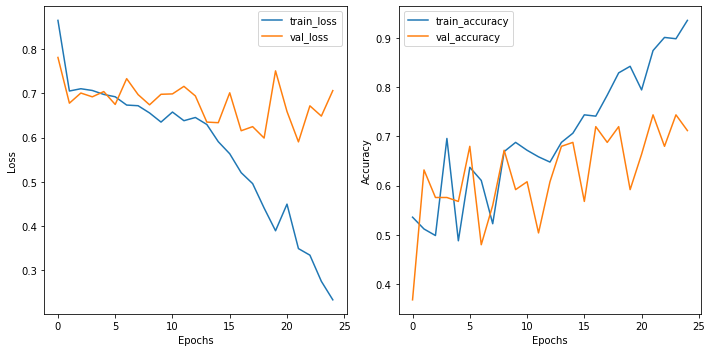

In [241]:
plot_metrics(model_29_results)

Not the steadiest plots, which is a little disappointing. The model is still struggling to converge on a minimum. 

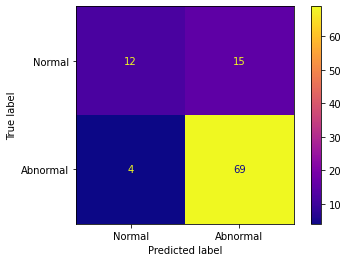

In [242]:
plot_cm(model_29)

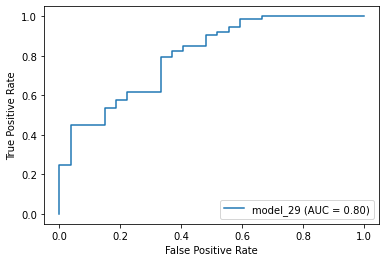

In [243]:
plot_roc(model_29, 'model_29')

We have very few false negatives (only 4), and slightly more false positives than true negatives, which is a little better than too many false negatives. This model isn't so bad. Let's see if we can adjust it a little bit to help with the overfitting. 

# Model #30
<hr style="border:2px solid pink">

Adjusted some of the dropout and learning rates.

In [244]:
model_30 = Sequential()

model_30.add(Conv2D(filters=64, 
                        kernel_size=(3,3), 
                        activation='tanh', 
                        input_shape=input_shape, 
                        kernel_regularizer=l2(0.001)))
model_30.add(MaxPooling2D(pool_size=(2,2)))

model_30.add(Conv2D(128, (3, 3), activation='tanh'))
model_30.add(MaxPooling2D(pool_size=(2,2)))

model_30.add(Conv2D(64, (3, 3), activation='tanh'))
model_30.add(MaxPooling2D(pool_size=(2,2)))

model_30.add(Flatten())
model_30.add(Dense(256, activation='tanh'))
model_30.add(Dense(128, activation='tanh'))
model_30.add(Dense(64, activation='tanh'))
model_30.add(Dense(32, activation='tanh'))
model_30.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01)))

model_30.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision, recall])

model_30.summary()

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_88 (Conv2D)           (None, 62, 62, 64)        640       
_________________________________________________________________
max_pooling2d_88 (MaxPooling (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_89 (Conv2D)           (None, 29, 29, 128)       73856     
_________________________________________________________________
max_pooling2d_89 (MaxPooling (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_90 (Conv2D)           (None, 12, 12, 64)        73792     
_________________________________________________________________
max_pooling2d_90 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_30 (Flatten)         (None, 2304)            

In [245]:
model_30_results = model_30.fit(train_images, 
                                binary_train_labels, 
                                batch_size=50, 
                                epochs=25,
                                validation_split=0.25,
                                class_weight=class_weights_dict)

Epoch 1/25
8/8 [==============================] - 4s 517ms/step - loss: 0.7529 - accuracy: 0.5920 - precision: 0.7764 - recall: 0.7143 - val_loss: 0.7645 - val_accuracy: 0.3840 - val_precision: 0.6667 - val_recall: 0.0506
Epoch 2/25
8/8 [==============================] - 3s 389ms/step - loss: 0.6813 - accuracy: 0.5653 - precision: 0.7938 - recall: 0.5560 - val_loss: 0.6912 - val_accuracy: 0.7040 - val_precision: 0.7333 - val_recall: 0.8354
Epoch 3/25
8/8 [==============================] - 3s 421ms/step - loss: 0.6744 - accuracy: 0.6560 - precision: 0.7803 - recall: 0.7437 - val_loss: 0.8731 - val_accuracy: 0.4320 - val_precision: 0.8333 - val_recall: 0.1266
Epoch 4/25
8/8 [==============================] - 4s 451ms/step - loss: 0.6780 - accuracy: 0.6000 - precision: 0.8191 - recall: 0.5884 - val_loss: 0.6659 - val_accuracy: 0.6560 - val_precision: 0.7143 - val_recall: 0.7595
Epoch 5/25
8/8 [==============================] - 4s 440ms/step - loss: 0.6227 - accuracy: 0.6827 - precision: 0

In [246]:
evaluate_model(model_30)

4/4 [==============================] - 0s 42ms/step - loss: 0.9748 - accuracy: 0.8000 - precision: 0.8046 - recall: 0.9589
Training Loss: 0.463
Training Accuracy: 0.896
Training Precision: 0.882
Training Recall: 0.986
---------------------------
Testing Loss: 0.975
Testing Accuracy: 0.8
Testing Precision: 0.805
Testing Recall: 0.959


This looks about the same as the last model, with marginally lower testing scores. 

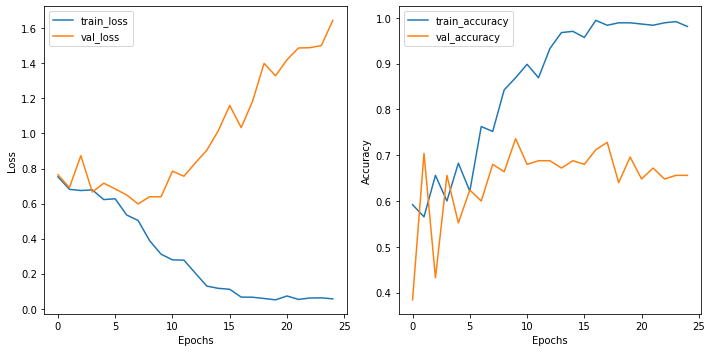

In [247]:
plot_metrics(model_30_results)

The validation loss is pretty bad here, it's increasing pretty steadily. Accuracy is fluctuating a lot at the beginning but seems to stabilize a little at the end. 

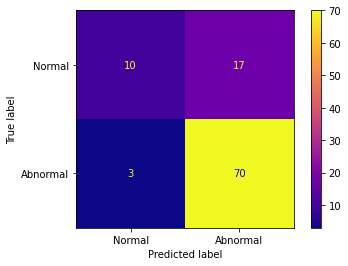

In [248]:
plot_cm(model_30)

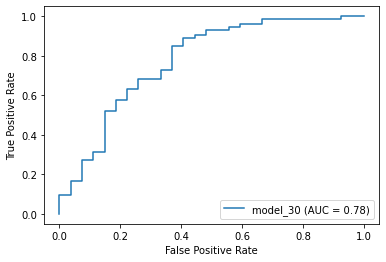

In [249]:
plot_roc(model_30, 'model_30')

The confusion matrix is a little worse for this model than the last one - there are more false positives and about the same number of false negatives. The AUC is a little worse as well at 0.78. 

Let's increase regularization a little more to help with the overfitting. 

# Model #31
<hr style="border:2px solid pink">

In [250]:
model_31 = Sequential()

model_31.add(Conv2D(filters=64, 
                        kernel_size=(3,3), 
                        activation='tanh', 
                        input_shape=input_shape, 
                        kernel_regularizer=l2(0.0001)))
model_31.add(Dense(64, activation='tanh'))
model_31.add(MaxPooling2D(pool_size=(2,2)))

model_31.add(Conv2D(128, (3, 3), activation='tanh'))
model_31.add(Dense(32, activation='tanh'))
model_31.add(MaxPooling2D(pool_size=(2,2)))

model_31.add(Conv2D(64, (3, 3), activation='tanh'))
model_31.add(MaxPooling2D(pool_size=(2,2)))

model_31.add(Flatten())
model_31.add(Dense(128, activation='tanh'))
model_31.add(Dense(64, activation='tanh'))
model_31.add(Dense(32, activation='tanh'))
model_31.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.0001)))

model_31.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision, recall])

model_31.summary()

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_91 (Conv2D)           (None, 62, 62, 64)        640       
_________________________________________________________________
dense_105 (Dense)            (None, 62, 62, 64)        4160      
_________________________________________________________________
max_pooling2d_91 (MaxPooling (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_92 (Conv2D)           (None, 29, 29, 128)       73856     
_________________________________________________________________
dense_106 (Dense)            (None, 29, 29, 32)        4128      
_________________________________________________________________
max_pooling2d_92 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_93 (Conv2D)           (None, 12, 12, 64)      

In [251]:
model_31_results = model_31.fit(train_images, 
                                binary_train_labels, 
                                batch_size=50, 
                                epochs=25,
                                validation_split=0.25,
                                class_weight=class_weights_dict)

Epoch 1/25
8/8 [==============================] - 2s 251ms/step - loss: 0.7030 - accuracy: 0.4480 - precision: 0.7639 - recall: 0.5086 - val_loss: 0.6489 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 2/25
8/8 [==============================] - 2s 193ms/step - loss: 0.6705 - accuracy: 0.6933 - precision: 0.7547 - recall: 0.8664 - val_loss: 0.7212 - val_accuracy: 0.4240 - val_precision: 0.8182 - val_recall: 0.1139
Epoch 3/25
8/8 [==============================] - 2s 192ms/step - loss: 0.6550 - accuracy: 0.5627 - precision: 0.8021 - recall: 0.5415 - val_loss: 0.6398 - val_accuracy: 0.6640 - val_precision: 0.7079 - val_recall: 0.7975
Epoch 4/25
8/8 [==============================] - 1s 179ms/step - loss: 0.6229 - accuracy: 0.6507 - precision: 0.8259 - recall: 0.6679 - val_loss: 0.7125 - val_accuracy: 0.5040 - val_precision: 0.7742 - val_recall: 0.3038
Epoch 5/25
8/8 [==============================] - 1s 178ms/step - loss: 0.6052 - accuracy: 0.6693 - precision: 0

In [252]:
evaluate_model(model_31)

4/4 [==============================] - 0s 67ms/step - loss: 1.2459 - accuracy: 0.7200 - precision: 0.8082 - recall: 0.8082
Training Loss: 0.359
Training Accuracy: 0.918
Training Precision: 0.922
Training Recall: 0.966
---------------------------
Testing Loss: 1.25
Testing Accuracy: 0.72
Testing Precision: 0.808
Testing Recall: 0.808


The training scores are a little higher, but the testing scores are a lot lower. This is a lot more overfit than before, maybe I lowered the regularization too much in some layers. 

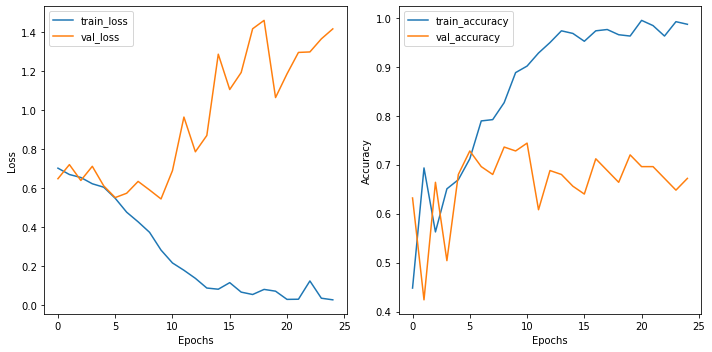

In [253]:
plot_metrics(model_31_results)

Loss and accuracy for the train set are pretty good, mostly smooth functions with a few fluctuations. Validation loss and accuracy are all over the place.

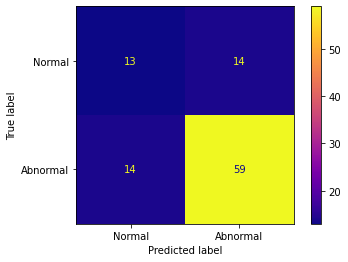

In [254]:
plot_cm(model_31)

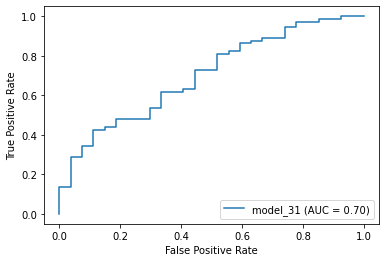

In [255]:
plot_roc(model_31, 'model_31')

The confusion matrix has a more or less even spread of false negatives, true negatives, and false positives, and the AUC score of 0.70 suggest that the model is performing averagely. 

# Model #32
<hr style="border:2px solid pink">

Let's increase the complexity by doubling the units in the hidden dense layers and see how the model performs. 

In [256]:
model_32 = Sequential()

model_32.add(Conv2D(filters=64, 
                        kernel_size=(3,3), 
                        activation='tanh', 
                        input_shape=input_shape, 
                        kernel_regularizer=l2(0.0001)))
model_32.add(Dense(128, activation='tanh'))
model_32.add(MaxPooling2D(pool_size=(2,2)))

model_32.add(Conv2D(128, (3, 3), activation='tanh'))
model_32.add(Dense(64, activation='tanh'))
model_32.add(MaxPooling2D(pool_size=(2,2)))

model_32.add(Conv2D(64, (3, 3), activation='tanh'))
model_32.add(MaxPooling2D(pool_size=(2,2)))

model_32.add(Flatten())
model_32.add(Dense(128, activation='tanh'))
model_32.add(Dense(64, activation='tanh'))
model_32.add(Dense(32, activation='tanh'))
model_32.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.0001)))

model_32.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision, recall])

model_32.summary()

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_94 (Conv2D)           (None, 62, 62, 64)        640       
_________________________________________________________________
dense_111 (Dense)            (None, 62, 62, 128)       8320      
_________________________________________________________________
max_pooling2d_94 (MaxPooling (None, 31, 31, 128)       0         
_________________________________________________________________
conv2d_95 (Conv2D)           (None, 29, 29, 128)       147584    
_________________________________________________________________
dense_112 (Dense)            (None, 29, 29, 64)        8256      
_________________________________________________________________
max_pooling2d_95 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_96 (Conv2D)           (None, 12, 12, 64)      

In [257]:
model_32_results = model_32.fit(train_images, 
                                binary_train_labels, 
                                batch_size=50, 
                                epochs=25,
                                validation_split=0.25,
                                class_weight=class_weights_dict)

Epoch 1/25
8/8 [==============================] - 8s 1s/step - loss: 0.7355 - accuracy: 0.5493 - precision: 0.7782 - recall: 0.6114 - val_loss: 0.6580 - val_accuracy: 0.6400 - val_precision: 0.6604 - val_recall: 0.8861
Epoch 2/25
8/8 [==============================] - 7s 891ms/step - loss: 0.6612 - accuracy: 0.6133 - precision: 0.7750 - recall: 0.6715 - val_loss: 0.7382 - val_accuracy: 0.4400 - val_precision: 0.6552 - val_recall: 0.2405
Epoch 3/25
8/8 [==============================] - 8s 942ms/step - loss: 0.6507 - accuracy: 0.5653 - precision: 0.7568 - recall: 0.6065 - val_loss: 0.6560 - val_accuracy: 0.5920 - val_precision: 0.7800 - val_recall: 0.4937
Epoch 4/25
8/8 [==============================] - 7s 847ms/step - loss: 0.6381 - accuracy: 0.6533 - precision: 0.8101 - recall: 0.6931 - val_loss: 0.6808 - val_accuracy: 0.5200 - val_precision: 0.7879 - val_recall: 0.3291
Epoch 5/25
8/8 [==============================] - 7s 882ms/step - loss: 0.5981 - accuracy: 0.6373 - precision: 0.88

In [258]:
evaluate_model(model_32)

4/4 [==============================] - 0s 88ms/step - loss: 1.0744 - accuracy: 0.7600 - precision: 0.7952 - recall: 0.9041
Training Loss: 0.304
Training Accuracy: 0.926
Training Precision: 0.914
Training Recall: 0.989
---------------------------
Testing Loss: 1.07
Testing Accuracy: 0.76
Testing Precision: 0.795
Testing Recall: 0.904


This model is a little less overfit, but still pretty overfit. The testing scores are still not that great, but recall seems to have increased for both the training and testing sets. 

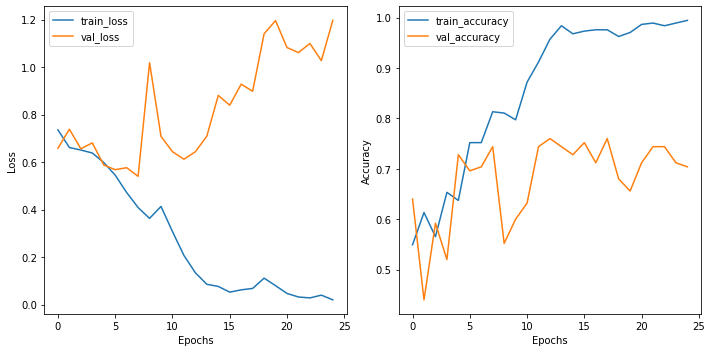

In [259]:
plot_metrics(model_32_results)

Once again, the training loss and accuracy are pretty decent, but the validation loss and accuracy are very sporadic - the model is struggling to converge. 

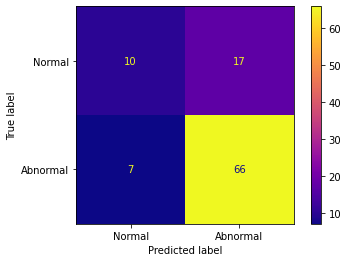

In [260]:
plot_cm(model_32)

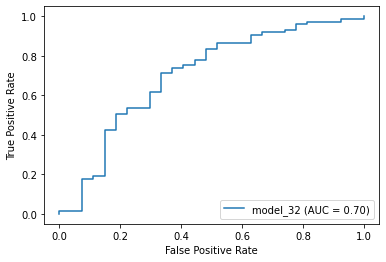

In [261]:
plot_roc(model_32, 'model_32')

Recall is doing its job and minimizing false negatives! However, there are still more false positives than true negatives, suggesting the model is not that accurate. The AUC score of 0.70 confirms this model is average at best. 

# Model #33
<hr style="border:2px solid pink">

Let's use a mix of tanh and relu as the activation functions. Since tanh and relu have different functions, it could help optimization. 

In [262]:
model_33 = Sequential()

model_33.add(Conv2D(filters=64, 
                        kernel_size=(3,3), 
                        activation='tanh', 
                        input_shape=input_shape, 
                        kernel_regularizer=l2(0.0001)))
model_33.add(Dense(64, activation='tanh'))
model_33.add(MaxPooling2D(pool_size=(2,2)))

model_33.add(Conv2D(128, (3, 3), activation='relu'))
model_33.add(Dense(32, activation='relu'))
model_33.add(MaxPooling2D(pool_size=(2,2)))

model_33.add(Conv2D(64, (3, 3), activation='relu'))
model_33.add(MaxPooling2D(pool_size=(2,2)))

model_33.add(Flatten())
model_33.add(Dense(128, activation='relu'))
model_33.add(Dense(64, activation='tanh'))
model_33.add(Dense(32, activation='tanh'))
model_33.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.0001)))

model_33.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision, recall])

model_33.summary()

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_97 (Conv2D)           (None, 62, 62, 64)        640       
_________________________________________________________________
dense_117 (Dense)            (None, 62, 62, 64)        4160      
_________________________________________________________________
max_pooling2d_97 (MaxPooling (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_98 (Conv2D)           (None, 29, 29, 128)       73856     
_________________________________________________________________
dense_118 (Dense)            (None, 29, 29, 32)        4128      
_________________________________________________________________
max_pooling2d_98 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_99 (Conv2D)           (None, 12, 12, 64)      

In [263]:
model_33_results = model_33.fit(train_images, 
                                binary_train_labels, 
                                batch_size=50, 
                                epochs=25,
                                validation_split=0.25,
                                class_weight=class_weights_dict)

Epoch 1/25
8/8 [==============================] - 5s 591ms/step - loss: 0.7060 - accuracy: 0.6453 - precision: 0.7481 - recall: 0.8314 - val_loss: 0.6968 - val_accuracy: 0.3760 - val_precision: 0.6667 - val_recall: 0.0253
Epoch 2/25
8/8 [==============================] - 4s 495ms/step - loss: 0.6765 - accuracy: 0.2640 - precision: 1.0000 - recall: 0.0036 - val_loss: 0.7013 - val_accuracy: 0.3680 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/25
8/8 [==============================] - 4s 543ms/step - loss: 0.6762 - accuracy: 0.2640 - precision: 1.0000 - recall: 0.0036 - val_loss: 0.6937 - val_accuracy: 0.4720 - val_precision: 0.7600 - val_recall: 0.2405
Epoch 4/25
8/8 [==============================] - 4s 529ms/step - loss: 0.6735 - accuracy: 0.4800 - precision: 0.8060 - recall: 0.3899 - val_loss: 0.6852 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 5/25
8/8 [==============================] - 4s 490ms/step - loss: 0.6709 - accuracy: 0.7387 - prec

In [264]:
evaluate_model(model_33)

4/4 [==============================] - 0s 58ms/step - loss: 0.9140 - accuracy: 0.7300 - precision: 0.8286 - recall: 0.7945
Training Loss: 0.317
Training Accuracy: 0.936
Training Precision: 0.926
Training Recall: 0.989
---------------------------
Testing Loss: 0.914
Testing Accuracy: 0.73
Testing Precision: 0.829
Testing Recall: 0.795


The scores are a little worse actually. Training scores are higher, but testing are lower, which means that there's a pretty decent variance between the training and unseen datasets. Let's look at the plots. 

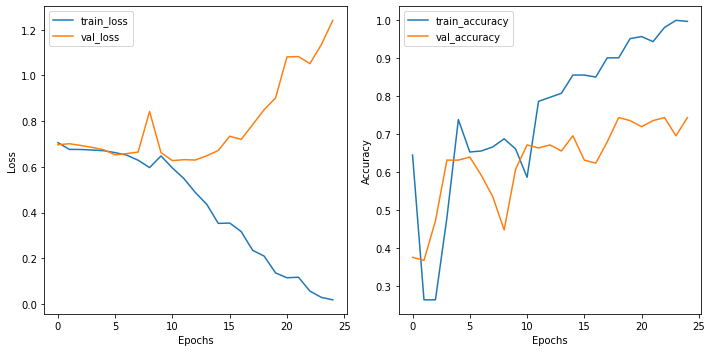

In [265]:
plot_metrics(model_33_results)

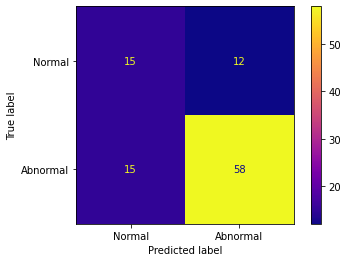

In [267]:
plot_cm(model_33)

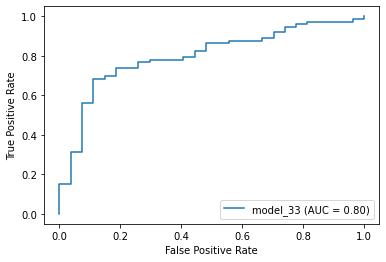

In [268]:
plot_roc(model_33, 'model_33')

Once again, there's a pretty even spread of true negatives, false negatives, and false positives. The AUC score is 0.80, which is pretty decent given how overfit the model is. 

# Model #34
<hr style="border:2px solid pink">

Let's change around teh activation functions again and see if the order of which comes first (tanh or relu) makes a difference. 

In [269]:
model_34 = Sequential()

model_34.add(Conv2D(filters=64, 
                        kernel_size=(3,3), 
                        activation='relu', 
                        input_shape=input_shape, 
                        kernel_regularizer=l2(0.0001)))
model_34.add(Dense(64, activation='relu'))
model_34.add(MaxPooling2D(pool_size=(2,2)))

model_34.add(Conv2D(128, (3, 3), activation='relu'))
model_34.add(Dense(32, activation='relu'))
model_34.add(MaxPooling2D(pool_size=(2,2)))

model_34.add(Conv2D(64, (3, 3), activation='tanh'))
model_34.add(BatchNormalization())
model_34.add(MaxPooling2D(pool_size=(2,2)))

model_34.add(Flatten())
model_34.add(Dense(128, activation='tanh'))
model_34.add(Dense(64, activation='tanh'))
model_34.add(Dense(32, activation='tanh'))
model_34.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.0001)))

model_34.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision, recall])

model_34.summary()

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_100 (Conv2D)          (None, 62, 62, 64)        640       
_________________________________________________________________
dense_123 (Dense)            (None, 62, 62, 64)        4160      
_________________________________________________________________
max_pooling2d_100 (MaxPoolin (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_101 (Conv2D)          (None, 29, 29, 128)       73856     
_________________________________________________________________
dense_124 (Dense)            (None, 29, 29, 32)        4128      
_________________________________________________________________
max_pooling2d_101 (MaxPoolin (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_102 (Conv2D)          (None, 12, 12, 64)      

In [270]:
model_34_results = model_34.fit(train_images, 
                                binary_train_labels, 
                                batch_size=50, 
                                epochs=25,
                                validation_split=0.25,
                                class_weight=class_weights_dict)

Epoch 1/25
8/8 [==============================] - 2s 245ms/step - loss: 0.7261 - accuracy: 0.5067 - precision: 0.7537 - recall: 0.5857 - val_loss: 0.6933 - val_accuracy: 0.4800 - val_precision: 0.7500 - val_recall: 0.2658
Epoch 2/25
8/8 [==============================] - 1s 178ms/step - loss: 0.6477 - accuracy: 0.6480 - precision: 0.7778 - recall: 0.7329 - val_loss: 0.6891 - val_accuracy: 0.5840 - val_precision: 0.6627 - val_recall: 0.6962
Epoch 3/25
8/8 [==============================] - 1s 179ms/step - loss: 0.5922 - accuracy: 0.6267 - precision: 0.8870 - recall: 0.5668 - val_loss: 0.6975 - val_accuracy: 0.4080 - val_precision: 0.6316 - val_recall: 0.1519
Epoch 4/25
8/8 [==============================] - 1s 170ms/step - loss: 0.5029 - accuracy: 0.7893 - precision: 0.8992 - recall: 0.8051 - val_loss: 0.6846 - val_accuracy: 0.5360 - val_precision: 0.7333 - val_recall: 0.4177
Epoch 5/25
8/8 [==============================] - 1s 178ms/step - loss: 0.4305 - accuracy: 0.8400 - precision: 0

In [271]:
evaluate_model(model_34)

4/4 [==============================] - 0s 58ms/step - loss: 0.5886 - accuracy: 0.7400 - precision: 0.8852 - recall: 0.7397
Training Loss: 0.277
Training Accuracy: 0.88
Training Precision: 0.928
Training Recall: 0.902
---------------------------
Testing Loss: 0.589
Testing Accuracy: 0.74
Testing Precision: 0.885
Testing Recall: 0.74


Much less overfit! Testing scores are still not that high, and precision is higher than recall again, but the variance between training accuracy and testing accuracy as decreased. Let's look at the plots. 

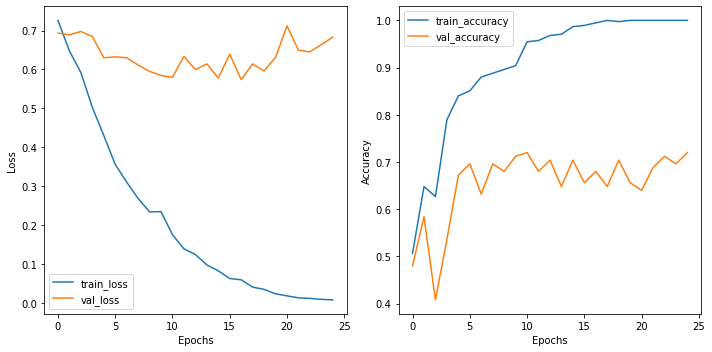

In [272]:
plot_metrics(model_34_results)

Training loss and accuracy look great! They're so smooth and steady. Validation loss and accuracy aren't as successful, but they are not fluctuating as dramatically as in the past. It seems having relu before tanh gives better results. 

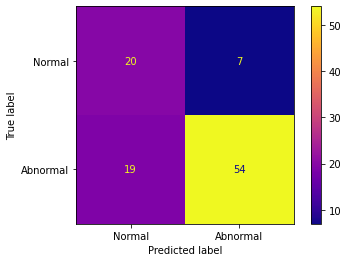

In [273]:
plot_cm(model_34)

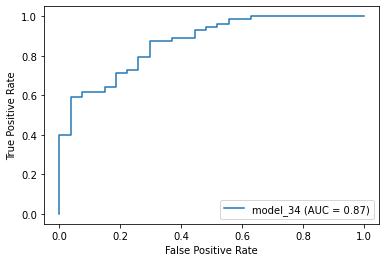

In [274]:
plot_roc(model_34, 'model_34')

The model is minimizing false positives pretty well, but we need to lower the number of false negatives. The AUC score is pretty decent at 0.87, suggesting this model is performing decently well. 

# Model #35
<hr style="border:2px solid pink">

Let's add some dense layers before the flatten layer, and see if it helps the testing scores improve. 

In [275]:
model_35 = Sequential()

model_35.add(Conv2D(filters=64, 
                        kernel_size=(3,3), 
                        activation='relu', 
                        input_shape=input_shape, 
                        kernel_regularizer=l2(0.0001)))
model_35.add(Dense(128, activation='relu'))
model_35.add(MaxPooling2D(pool_size=(2,2)))
model_35.add(Dropout(0.4))

model_35.add(Conv2D(256, (3, 3), activation='relu'))
model_35.add(Dense(64, activation='relu'))
model_35.add(MaxPooling2D(pool_size=(2,2)))
model_35.add(Dropout(0.3))

model_35.add(Conv2D(64, (3, 3), activation='tanh'))
model_35.add(MaxPooling2D(pool_size=(2,2)))
model_35.add(Dropout(0.2))

model_35.add(Flatten())
model_35.add(Dense(128, activation='tanh'))
model_35.add(Dense(64, activation='tanh'))
model_35.add(Dense(32, activation='tanh'))
model_35.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.0001)))

model_35.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision, recall])

model_35.summary()

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_103 (Conv2D)          (None, 62, 62, 64)        640       
_________________________________________________________________
dense_129 (Dense)            (None, 62, 62, 128)       8320      
_________________________________________________________________
max_pooling2d_103 (MaxPoolin (None, 31, 31, 128)       0         
_________________________________________________________________
dropout_53 (Dropout)         (None, 31, 31, 128)       0         
_________________________________________________________________
conv2d_104 (Conv2D)          (None, 29, 29, 256)       295168    
_________________________________________________________________
dense_130 (Dense)            (None, 29, 29, 64)        16448     
_________________________________________________________________
max_pooling2d_104 (MaxPoolin (None, 14, 14, 64)      

In [276]:
model_35_results = model_35.fit(train_images, 
                                binary_train_labels, 
                                batch_size=50, 
                                epochs=25,
                                validation_split=0.25,
                                class_weight=class_weights_dict)

Epoch 1/25
8/8 [==============================] - 12s 1s/step - loss: 0.6783 - accuracy: 0.6027 - precision: 0.7743 - recall: 0.7057 - val_loss: 0.6798 - val_accuracy: 0.6240 - val_precision: 0.6356 - val_recall: 0.9494
Epoch 2/25
8/8 [==============================] - 11s 1s/step - loss: 0.6742 - accuracy: 0.6693 - precision: 0.7354 - recall: 0.8628 - val_loss: 0.7153 - val_accuracy: 0.4480 - val_precision: 0.7778 - val_recall: 0.1772
Epoch 3/25
8/8 [==============================] - 8s 1s/step - loss: 0.6696 - accuracy: 0.4667 - precision: 0.7655 - recall: 0.4007 - val_loss: 0.6720 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 4/25
8/8 [==============================] - 8s 1s/step - loss: 0.6676 - accuracy: 0.7280 - precision: 0.7397 - recall: 0.9747 - val_loss: 0.6697 - val_accuracy: 0.6320 - val_precision: 0.6341 - val_recall: 0.9873
Epoch 5/25
8/8 [==============================] - 8s 1s/step - loss: 0.6615 - accuracy: 0.6933 - precision: 0.7531 - recal

In [277]:
evaluate_model(model_35)

4/4 [==============================] - 0s 118ms/step - loss: 0.6780 - accuracy: 0.7600 - precision: 0.8889 - recall: 0.7671
Training Loss: 0.3
Training Accuracy: 0.904
Training Precision: 0.921
Training Recall: 0.947
---------------------------
Testing Loss: 0.678
Testing Accuracy: 0.76
Testing Precision: 0.889
Testing Recall: 0.767


That increased scorse a little, but it's still pretty overfit. Let's look at the plots. 

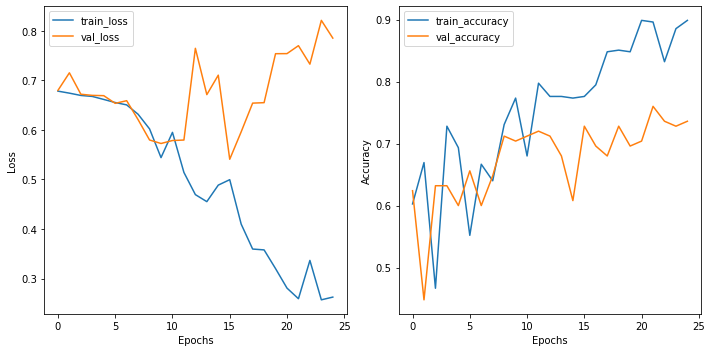

In [278]:
plot_metrics(model_35_results)

Look at all those fluctuations! It seems like this was a step in the wrong direction. Let's look at the confusion matrix and roc curve. 

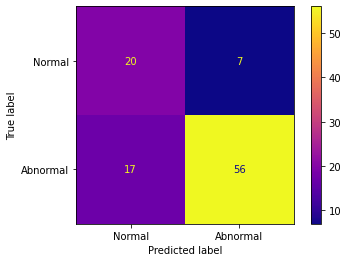

In [279]:
plot_cm(model_35)

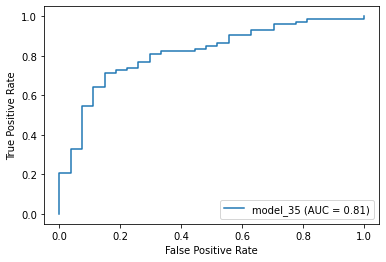

In [280]:
plot_roc(model_35, 'model_35')

The model is minimizing false positives, and there are nearly as many false negatives as true negatives! 

Let's try adding some more regularization for the overfitting. 

# Model #36
<hr style="border:2px solid pink">

In [281]:
model_36 = Sequential()

model_36.add(Conv2D(filters=64, 
                        kernel_size=(3,3), 
                        activation='tanh', 
                        input_shape=input_shape, 
                        kernel_regularizer=l2(0.0001)))
model_36.add(Dense(128, activation='tanh'))
model_36.add(MaxPooling2D(pool_size=(2,2)))
model_36.add(Dropout(0.4))

model_36.add(Conv2D(256, (3, 3), activation='tanh', kernel_regularizer=l2(0.000001)))
model_36.add(Dense(64, activation='tanh'))
model_36.add(MaxPooling2D(pool_size=(2,2)))
model_36.add(Dropout(0.3))

model_36.add(Conv2D(64, (3, 3), activation='tanh', kernel_regularizer=l2(0.000001)))
model_36.add(MaxPooling2D(pool_size=(2,2)))
model_36.add(Dropout(0.2))

model_36.add(Flatten())
model_36.add(Dense(128, activation='tanh'))
model_36.add(Dense(64, activation='tanh'))
model_36.add(Dense(32, activation='tanh'))
model_36.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.0001)))

model_36.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision, recall])

model_36.summary()

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_106 (Conv2D)          (None, 62, 62, 64)        640       
_________________________________________________________________
dense_135 (Dense)            (None, 62, 62, 128)       8320      
_________________________________________________________________
max_pooling2d_106 (MaxPoolin (None, 31, 31, 128)       0         
_________________________________________________________________
dropout_56 (Dropout)         (None, 31, 31, 128)       0         
_________________________________________________________________
conv2d_107 (Conv2D)          (None, 29, 29, 256)       295168    
_________________________________________________________________
dense_136 (Dense)            (None, 29, 29, 64)        16448     
_________________________________________________________________
max_pooling2d_107 (MaxPoolin (None, 14, 14, 64)      

In [282]:
model_36_results = model_36.fit(train_images, 
                                binary_train_labels, 
                                batch_size=50, 
                                epochs=25,
                                validation_split=0.25,
                                class_weight=class_weights_dict)

Epoch 1/25
8/8 [==============================] - 4s 556ms/step - loss: 0.7130 - accuracy: 0.5093 - precision: 0.7773 - recall: 0.5686 - val_loss: 0.7251 - val_accuracy: 0.4240 - val_precision: 0.8889 - val_recall: 0.1013
Epoch 2/25
8/8 [==============================] - 4s 472ms/step - loss: 0.6625 - accuracy: 0.5600 - precision: 0.7772 - recall: 0.5668 - val_loss: 0.6692 - val_accuracy: 0.5440 - val_precision: 0.6964 - val_recall: 0.4937
Epoch 3/25
8/8 [==============================] - 7s 912ms/step - loss: 0.6768 - accuracy: 0.4453 - precision: 0.7518 - recall: 0.3718 - val_loss: 0.6386 - val_accuracy: 0.6400 - val_precision: 0.6371 - val_recall: 1.0000
Epoch 4/25
8/8 [==============================] - 8s 975ms/step - loss: 0.6763 - accuracy: 0.5093 - precision: 0.7818 - recall: 0.4657 - val_loss: 0.6456 - val_accuracy: 0.6640 - val_precision: 0.6609 - val_recall: 0.9620
Epoch 5/25
8/8 [==============================] - 9s 1s/step - loss: 0.6627 - accuracy: 0.6933 - precision: 0.75

In [283]:
evaluate_model(model_36)

4/4 [==============================] - 1s 129ms/step - loss: 0.8663 - accuracy: 0.7700 - precision: 0.7907 - recall: 0.9315
Training Loss: 0.272
Training Accuracy: 0.924
Training Precision: 0.914
Training Recall: 0.986
---------------------------
Testing Loss: 0.866
Testing Accuracy: 0.77
Testing Precision: 0.791
Testing Recall: 0.932


Very similar scores to the last model, the testing loss increased a little bit actually. 

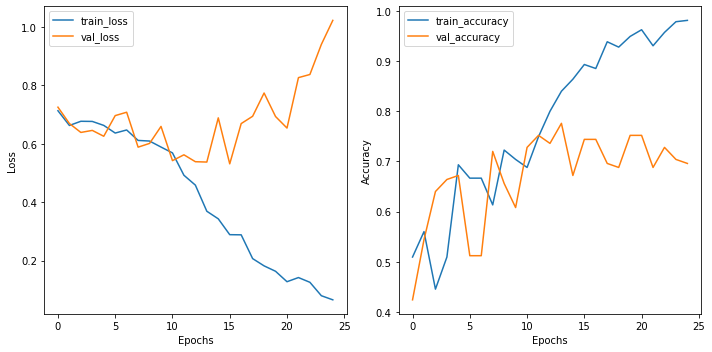

In [284]:
plot_metrics(model_36_results)

The loss and accuracy aren't that great for either training or validation, but it looks like the validation set is doing just a little bit worse. 

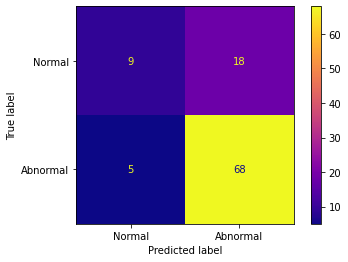

In [285]:
plot_cm(model_36)

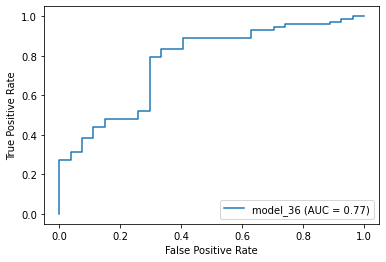

In [286]:
plot_roc(model_36, 'model_36')

The confusion matrix shows that the model is able to identify some images as normal, but is mostly predicting the majority class. 

Let's keep playing with regularization. 

# Model #37
<hr style="border:2px solid pink">

Let's add some more dropout and increase the strength. 

In [287]:
model_37 = Sequential()

model_37.add(Conv2D(filters=64, 
                        kernel_size=(3,3), 
                        activation='tanh', 
                        input_shape=input_shape, 
                        kernel_regularizer=l2(0.0001)))
model_37.add(Dense(128, activation='tanh'))
model_37.add(MaxPooling2D(pool_size=(2,2)))
model_37.add(Dropout(0.4))

model_37.add(Conv2D(256, (3, 3), activation='tanh', kernel_regularizer=l2(0.000001)))
model_37.add(Dense(64, activation='tanh'))
model_37.add(MaxPooling2D(pool_size=(2,2)))
model_37.add(Dropout(0.3))

model_37.add(Conv2D(64, (3, 3), activation='tanh', kernel_regularizer=l2(0.000001)))
model_37.add(MaxPooling2D(pool_size=(2,2)))
model_37.add(Dropout(0.2))

model_37.add(Flatten())
model_37.add(Dense(128, activation='tanh'))
model_37.add(Dropout(0.3))
model_37.add(Dense(64, activation='tanh'))
model_37.add(Dropout(0.2))
model_37.add(Dense(32, activation='tanh'))
model_37.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.0001)))

model_37.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision, recall])

model_37.summary()

Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_109 (Conv2D)          (None, 62, 62, 64)        640       
_________________________________________________________________
dense_141 (Dense)            (None, 62, 62, 128)       8320      
_________________________________________________________________
max_pooling2d_109 (MaxPoolin (None, 31, 31, 128)       0         
_________________________________________________________________
dropout_59 (Dropout)         (None, 31, 31, 128)       0         
_________________________________________________________________
conv2d_110 (Conv2D)          (None, 29, 29, 256)       295168    
_________________________________________________________________
dense_142 (Dense)            (None, 29, 29, 64)        16448     
_________________________________________________________________
max_pooling2d_110 (MaxPoolin (None, 14, 14, 64)      

In [288]:
model_37_results = model_37.fit(train_images, 
                                binary_train_labels, 
                                batch_size=50, 
                                epochs=25,
                                validation_split=0.25,
                                class_weight=class_weights_dict)

Epoch 1/25
8/8 [==============================] - 9s 1s/step - loss: 0.7218 - accuracy: 0.5387 - precision: 0.7550 - recall: 0.6514 - val_loss: 0.7630 - val_accuracy: 0.4080 - val_precision: 0.5862 - val_recall: 0.2152
Epoch 2/25
8/8 [==============================] - 9s 1s/step - loss: 0.6824 - accuracy: 0.6160 - precision: 0.7628 - recall: 0.6968 - val_loss: 0.7303 - val_accuracy: 0.4640 - val_precision: 0.7000 - val_recall: 0.2658
Epoch 3/25
8/8 [==============================] - 10s 1s/step - loss: 0.6463 - accuracy: 0.5387 - precision: 0.8250 - recall: 0.4765 - val_loss: 0.6598 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 4/25
8/8 [==============================] - 9s 1s/step - loss: 0.6799 - accuracy: 0.5680 - precision: 0.7533 - recall: 0.6173 - val_loss: 0.6625 - val_accuracy: 0.5840 - val_precision: 0.7015 - val_recall: 0.5949
Epoch 5/25
8/8 [==============================] - 9s 1s/step - loss: 0.6544 - accuracy: 0.6587 - precision: 0.7811 - recall

In [289]:
evaluate_model(model_37)

4/4 [==============================] - 1s 128ms/step - loss: 0.6973 - accuracy: 0.8000 - precision: 0.8046 - recall: 0.9589
Training Loss: 0.244
Training Accuracy: 0.924
Training Precision: 0.925
Training Recall: 0.972
---------------------------
Testing Loss: 0.697
Testing Accuracy: 0.8
Testing Precision: 0.805
Testing Recall: 0.959


If this wasn't so overfit, it would be perfect! Scores are high for both training and testing, and recall is higher than precision. Maybe we can workshop this model a little more. 

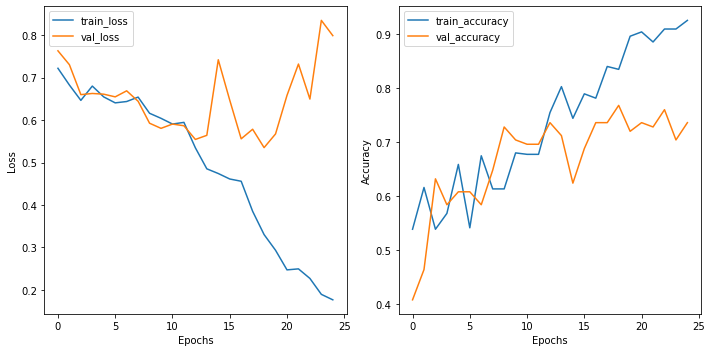

In [290]:
plot_metrics(model_37_results)

Loss and accuracy are still all over the place, suggesting that convergence is still unstable. 

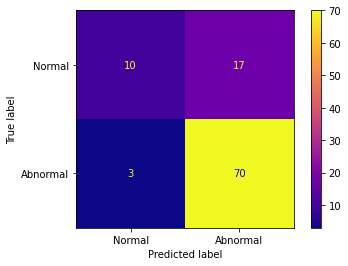

In [291]:
plot_cm(model_37)

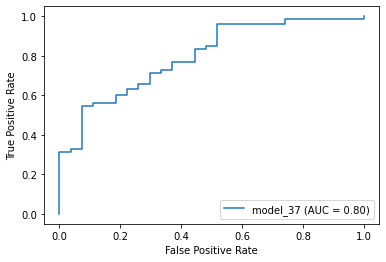

In [292]:
plot_roc(model_37, 'model_37')

The model is doing a great job at minimizing false negatives, but not so much with false positives. The AUC of 0.80 is pretty decent. 

# Model #38
<hr style="border:2px solid pink">

Let's increase the regularization to try and reduce the overfitting, and use relu for the first few layers. 

In [305]:
model_38 = Sequential()

model_38.add(Conv2D(filters=64, 
                        kernel_size=(3,3), 
                        activation='relu', 
                        input_shape=input_shape, 
                        kernel_regularizer=l2(0.0001)))
model_38.add(Dense(128, activation='relu'))
model_38.add(MaxPooling2D(pool_size=(2,2)))
model_38.add(Dropout(0.5))

model_38.add(Conv2D(256, (3, 3), activation='tanh', kernel_regularizer=l2(0.0001)))
model_38.add(Dense(64, activation='tanh'))
model_38.add(MaxPooling2D(pool_size=(2,2)))
model_38.add(Dropout(0.3))

model_38.add(Conv2D(64, (3, 3), activation='tanh', kernel_regularizer=l2(0.0001)))
model_38.add(MaxPooling2D(pool_size=(2,2)))
model_38.add(Dropout(0.2))

model_38.add(Flatten())
model_38.add(Dense(128, activation='tanh'))
model_38.add(Dropout(0.3))
model_38.add(Dense(64, activation='tanh'))
model_38.add(Dropout(0.2))
model_38.add(Dense(32, activation='tanh'))
model_38.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.0001)))

model_38.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision, recall])

model_38.summary()

Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_118 (Conv2D)          (None, 62, 62, 64)        640       
_________________________________________________________________
dense_159 (Dense)            (None, 62, 62, 128)       8320      
_________________________________________________________________
max_pooling2d_118 (MaxPoolin (None, 31, 31, 128)       0         
_________________________________________________________________
dropout_74 (Dropout)         (None, 31, 31, 128)       0         
_________________________________________________________________
conv2d_119 (Conv2D)          (None, 29, 29, 256)       295168    
_________________________________________________________________
dense_160 (Dense)            (None, 29, 29, 64)        16448     
_________________________________________________________________
max_pooling2d_119 (MaxPoolin (None, 14, 14, 64)      

In [306]:
model_38_results = model_38.fit(train_images, 
                                binary_train_labels, 
                                batch_size=50, 
                                epochs=25,
                                validation_split=0.25,
                                class_weight=class_weights_dict)

Epoch 1/25
8/8 [==============================] - 5s 595ms/step - loss: 0.7150 - accuracy: 0.4987 - precision: 0.7500 - recall: 0.5914 - val_loss: 0.6787 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 2/25
8/8 [==============================] - 4s 445ms/step - loss: 0.7239 - accuracy: 0.6053 - precision: 0.7263 - recall: 0.7473 - val_loss: 0.6966 - val_accuracy: 0.6080 - val_precision: 0.6442 - val_recall: 0.8481
Epoch 3/25
8/8 [==============================] - 4s 446ms/step - loss: 0.7006 - accuracy: 0.6853 - precision: 0.7345 - recall: 0.8989 - val_loss: 0.7017 - val_accuracy: 0.5600 - val_precision: 0.6579 - val_recall: 0.6329
Epoch 4/25
8/8 [==============================] - 6s 724ms/step - loss: 0.6899 - accuracy: 0.4800 - precision: 0.7595 - recall: 0.4332 - val_loss: 0.6871 - val_accuracy: 0.6240 - val_precision: 0.6569 - val_recall: 0.8481
Epoch 5/25
8/8 [==============================] - 6s 756ms/step - loss: 0.6755 - accuracy: 0.6827 - precision: 0

In [307]:
evaluate_model(model_38)

4/4 [==============================] - 0s 67ms/step - loss: 0.5731 - accuracy: 0.7700 - precision: 0.8676 - recall: 0.8082
Training Loss: 0.31
Training Accuracy: 0.902
Training Precision: 0.912
Training Recall: 0.955
---------------------------
Testing Loss: 0.573
Testing Accuracy: 0.77
Testing Precision: 0.868
Testing Recall: 0.808


A little bit worse all around. 

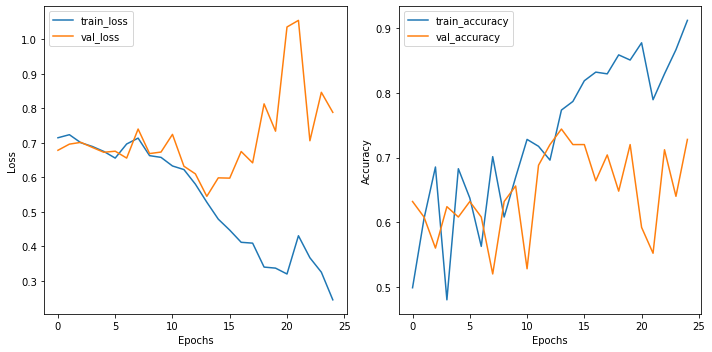

In [308]:
plot_metrics(model_38_results)

Not the worse loss and accuracy functions I've seen but these are pretty bad. Train loss is decreasing with a few small fluctuations, but validation loss is skyrocketing at 20 epochs, then stays pretty high. Accuracy for both train and validation are all over the place. All of these models and I still can't get these to smooth out. 

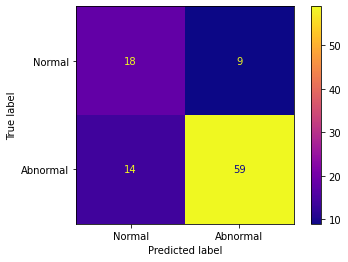

In [309]:
plot_cm(model_38)

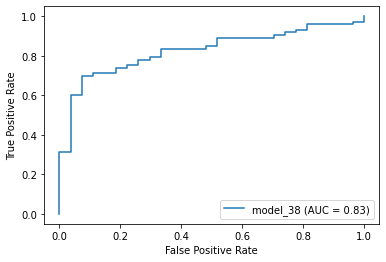

In [310]:
plot_roc(model_38, 'model_38')

The model is minimizing false positives nicely, but the false negative count is pretty high, which is not what we want. The AUC is 0.83, which is pretty good, but deceptively high as the metrics aren't where we want them to be. 

# Model #39
<hr style="border:2px solid pink">

The above loss and accuracy were fluctuating a lot, let's add batch normalization after 2 layers with activation functions in an effort to help stabilize the training. 

In [311]:
model_39 = Sequential()

model_39.add(Conv2D(filters=64, 
                        kernel_size=(3,3), 
                        activation='tanh', 
                        input_shape=input_shape, 
                        kernel_regularizer=l2(0.0001)))
model_39.add(Dense(128, activation='tanh'))
model_39.add(BatchNormalization())
model_39.add(MaxPooling2D(pool_size=(2,2)))
model_39.add(Dropout(0.5))

model_39.add(Conv2D(256, (3, 3), activation='tanh', kernel_regularizer=l2(0.0001)))
model_39.add(Dense(64, activation='tanh'))
model_39.add(BatchNormalization())
model_39.add(MaxPooling2D(pool_size=(2,2)))
model_39.add(Dropout(0.3))

model_39.add(Conv2D(64, (3, 3), activation='tanh', kernel_regularizer=l2(0.0001)))
model_39.add(MaxPooling2D(pool_size=(2,2)))
model_39.add(Dropout(0.2))

model_39.add(Flatten())
model_39.add(Dense(128, activation='tanh'))
model_39.add(Dropout(0.3))
model_39.add(Dense(64, activation='tanh'))
model_39.add(Dropout(0.2))
model_39.add(Dense(32, activation='tanh'))
model_39.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.0001)))

model_39.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision, recall])

model_39.summary()

Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_121 (Conv2D)          (None, 62, 62, 64)        640       
_________________________________________________________________
dense_165 (Dense)            (None, 62, 62, 128)       8320      
_________________________________________________________________
batch_normalization_11 (Batc (None, 62, 62, 128)       512       
_________________________________________________________________
max_pooling2d_121 (MaxPoolin (None, 31, 31, 128)       0         
_________________________________________________________________
dropout_79 (Dropout)         (None, 31, 31, 128)       0         
_________________________________________________________________
conv2d_122 (Conv2D)          (None, 29, 29, 256)       295168    
_________________________________________________________________
dense_166 (Dense)            (None, 29, 29, 64)      

In [312]:
model_39_results = model_39.fit(train_images, 
                                binary_train_labels, 
                                batch_size=50, 
                                epochs=25,
                                validation_split=0.25,
                                class_weight=class_weights_dict)

Epoch 1/25
8/8 [==============================] - 6s 724ms/step - loss: 0.7750 - accuracy: 0.5227 - precision: 0.7846 - recall: 0.5829 - val_loss: 0.6773 - val_accuracy: 0.6320 - val_precision: 0.6364 - val_recall: 0.9747
Epoch 2/25
8/8 [==============================] - 6s 707ms/step - loss: 0.7221 - accuracy: 0.6133 - precision: 0.7374 - recall: 0.7401 - val_loss: 0.6792 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 3/25
8/8 [==============================] - 8s 1s/step - loss: 0.6921 - accuracy: 0.5867 - precision: 0.7421 - recall: 0.6751 - val_loss: 0.6767 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 4/25
8/8 [==============================] - 9s 1s/step - loss: 0.6857 - accuracy: 0.5947 - precision: 0.7907 - recall: 0.6137 - val_loss: 0.6860 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 5/25
8/8 [==============================] - 10s 1s/step - loss: 0.6839 - accuracy: 0.6533 - precision: 0.7561 - 

In [313]:
evaluate_model(model_39)

4/4 [==============================] - 1s 132ms/step - loss: 1.0413 - accuracy: 0.7300 - precision: 0.7300 - recall: 1.0000
Training Loss: 1.15
Training Accuracy: 0.712
Training Precision: 0.712
Training Recall: 1.0
---------------------------
Testing Loss: 1.04
Testing Accuracy: 0.73
Testing Precision: 0.73
Testing Recall: 1.0


That might have been too much, we're back at these mediocre results I've gotten for a few different models. 

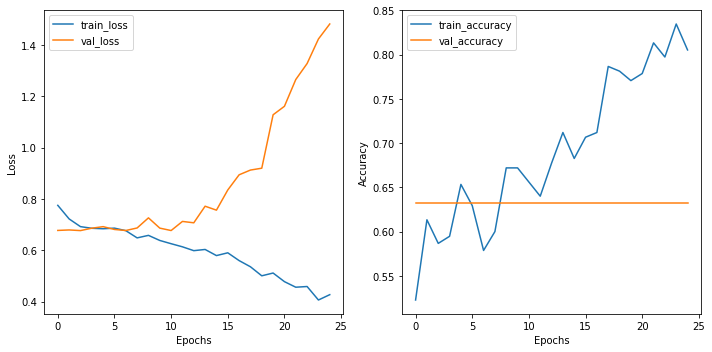

In [314]:
plot_metrics(model_39_results)

Validation loss is doing the complete opposite of what it's supposed to be doing, and accuracy is just stalled. Let's look at the confusion matrix and roc curve, but this is not a good model. 

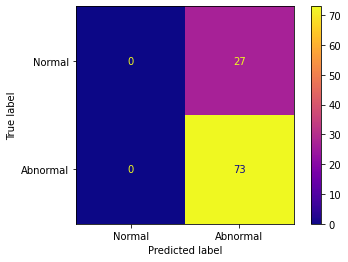

In [315]:
plot_cm(model_39)

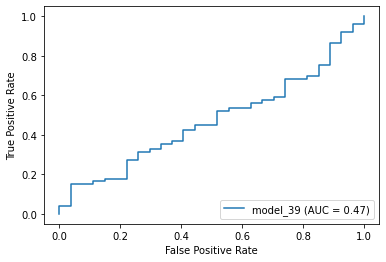

In [316]:
plot_roc(model_39, 'model_39')

The confusion matrix and roc curve are proof of how bad a model this is - it's predicting only the majority class as seen by the 27 false positives, 73 true positives, 0 false negatives, and 0 true negatives. The AUC score of 0.47 confirms this. 

# Model #40
<hr style="border:2px solid pink">

Let's remove some of the batch normalization, see if it helps. 

In [317]:
model_40 = Sequential()

model_40.add(Conv2D(filters=64, 
                        kernel_size=(3,3), 
                        activation='tanh', 
                        input_shape=input_shape, 
                        kernel_regularizer=l2(0.0001)))
model_40.add(Dense(128, activation='tanh'))
model_40.add(MaxPooling2D(pool_size=(2,2)))
model_40.add(Dropout(0.5))

model_40.add(Conv2D(256, (3, 3), activation='tanh', kernel_regularizer=l2(0.0001)))
model_40.add(Dense(64, activation='tanh'))
model_40.add(BatchNormalization())
model_40.add(MaxPooling2D(pool_size=(2,2)))
model_40.add(Dropout(0.3))

model_40.add(Conv2D(64, (3, 3), activation='tanh', kernel_regularizer=l2(0.0001)))
model_40.add(MaxPooling2D(pool_size=(2,2)))
model_40.add(Dropout(0.2))

model_40.add(Flatten())
model_40.add(Dense(128, activation='tanh'))
model_40.add(Dropout(0.3))
model_40.add(Dense(64, activation='tanh'))
model_40.add(Dropout(0.2))
model_40.add(Dense(32, activation='tanh'))
model_40.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.0001)))

model_40.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision, recall])

model_40.summary()

Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_124 (Conv2D)          (None, 62, 62, 64)        640       
_________________________________________________________________
dense_171 (Dense)            (None, 62, 62, 128)       8320      
_________________________________________________________________
max_pooling2d_124 (MaxPoolin (None, 31, 31, 128)       0         
_________________________________________________________________
dropout_84 (Dropout)         (None, 31, 31, 128)       0         
_________________________________________________________________
conv2d_125 (Conv2D)          (None, 29, 29, 256)       295168    
_________________________________________________________________
dense_172 (Dense)            (None, 29, 29, 64)        16448     
_________________________________________________________________
batch_normalization_13 (Batc (None, 29, 29, 64)      

In [318]:
model_40_results = model_40.fit(train_images, 
                                binary_train_labels, 
                                batch_size=50, 
                                epochs=25,
                                validation_split=0.25,
                                class_weight=class_weights_dict)

Epoch 1/25
8/8 [==============================] - 4s 548ms/step - loss: 0.7762 - accuracy: 0.5813 - precision: 0.7385 - recall: 0.7343 - val_loss: 0.6688 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 2/25
8/8 [==============================] - 4s 499ms/step - loss: 0.7006 - accuracy: 0.5707 - precision: 0.7816 - recall: 0.5812 - val_loss: 0.6906 - val_accuracy: 0.6480 - val_precision: 0.6446 - val_recall: 0.9873
Epoch 3/25
8/8 [==============================] - 7s 866ms/step - loss: 0.6866 - accuracy: 0.6693 - precision: 0.7629 - recall: 0.8014 - val_loss: 0.6849 - val_accuracy: 0.6160 - val_precision: 0.6566 - val_recall: 0.8228
Epoch 4/25
8/8 [==============================] - 7s 867ms/step - loss: 0.7016 - accuracy: 0.6000 - precision: 0.7613 - recall: 0.6679 - val_loss: 0.7087 - val_accuracy: 0.5920 - val_precision: 0.6707 - val_recall: 0.6962
Epoch 5/25
8/8 [==============================] - 7s 876ms/step - loss: 0.6964 - accuracy: 0.6000 - precision: 0

In [319]:
evaluate_model(model_40)

4/4 [==============================] - 0s 123ms/step - loss: 0.5161 - accuracy: 0.7900 - precision: 0.7955 - recall: 0.9589
Training Loss: 0.535
Training Accuracy: 0.772
Training Precision: 0.78
Training Recall: 0.947
---------------------------
Testing Loss: 0.516
Testing Accuracy: 0.79
Testing Precision: 0.795
Testing Recall: 0.959


If the scores were just slightly higher, this would be a fantastic model. It's slightly underfit, and recall is higher than precision. Loss is kind of high, but not terrible. Let's visualize it. 

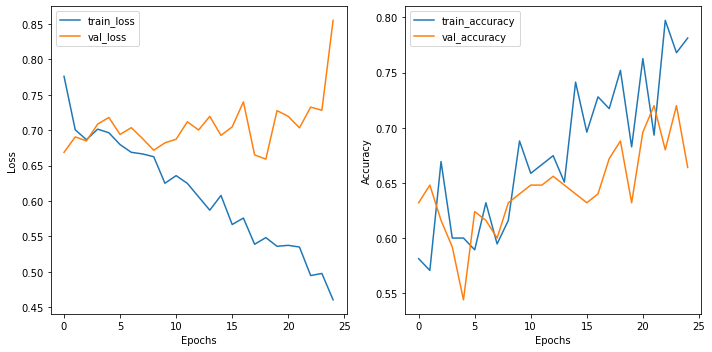

In [320]:
plot_metrics(model_40_results)

The loss and accuracy are fluctuating quite a bit still. 

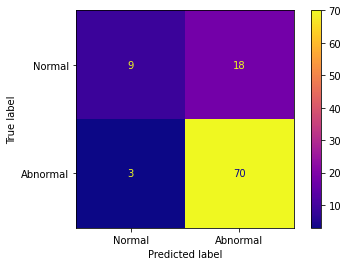

In [321]:
plot_cm(model_40)

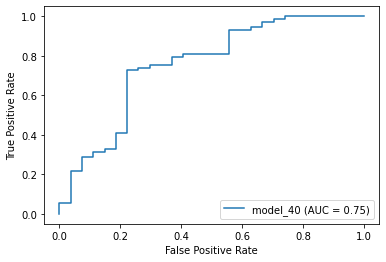

In [322]:
plot_roc(model_40, 'model_40')

The model looks like it's leaning towards always predicting the majority class. There are a few normal predictions in there, but not that many. 

Let's try increasing the complexity one last time and see if it helps. 

# Model #41
<hr style="border:2px solid pink">

In [323]:
model_41 = Sequential()

model_41.add(Conv2D(filters=64, 
                        kernel_size=(3,3), 
                        activation='tanh', 
                        input_shape=input_shape, 
                        kernel_regularizer=l2(0.0001)))
model_41.add(Dense(128, activation='tanh'))
model_41.add(MaxPooling2D(pool_size=(2,2)))
model_41.add(Dropout(0.5))

model_41.add(Conv2D(256, (3, 3), activation='tanh', kernel_regularizer=l2(0.0001)))
model_41.add(Dense(64, activation='tanh'))
model_41.add(BatchNormalization())
model_41.add(MaxPooling2D(pool_size=(2,2)))
model_41.add(Dropout(0.3))

model_41.add(Conv2D(64, (3, 3), activation='tanh', kernel_regularizer=l2(0.0001)))
model_41.add(MaxPooling2D(pool_size=(2,2)))
model_41.add(Dropout(0.3))

model_41.add(Flatten())
model_41.add(Dense(128, activation='tanh'))
model_41.add(Dropout(0.3))
model_41.add(Dense(64, activation='tanh'))
model_41.add(Dropout(0.2))
model_41.add(Dense(64, activation='tanh'))
model_41.add(Dense(32, activation='tanh'))
model_41.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.0001)))

model_41.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision, recall])

model_41.summary()

Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_127 (Conv2D)          (None, 62, 62, 64)        640       
_________________________________________________________________
dense_177 (Dense)            (None, 62, 62, 128)       8320      
_________________________________________________________________
max_pooling2d_127 (MaxPoolin (None, 31, 31, 128)       0         
_________________________________________________________________
dropout_89 (Dropout)         (None, 31, 31, 128)       0         
_________________________________________________________________
conv2d_128 (Conv2D)          (None, 29, 29, 256)       295168    
_________________________________________________________________
dense_178 (Dense)            (None, 29, 29, 64)        16448     
_________________________________________________________________
batch_normalization_14 (Batc (None, 29, 29, 64)      

In [324]:
model_41_results = model_41.fit(train_images, 
                                binary_train_labels, 
                                batch_size=50, 
                                epochs=25,
                                validation_split=0.25,
                                class_weight=class_weights_dict)

Epoch 1/25
8/8 [==============================] - 5s 564ms/step - loss: 0.8361 - accuracy: 0.4667 - precision: 0.7345 - recall: 0.5771 - val_loss: 0.6849 - val_accuracy: 0.6480 - val_precision: 0.6423 - val_recall: 1.0000
Epoch 2/25
8/8 [==============================] - 4s 482ms/step - loss: 0.6953 - accuracy: 0.6053 - precision: 0.7380 - recall: 0.7220 - val_loss: 0.6844 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 3/25
8/8 [==============================] - 7s 864ms/step - loss: 0.6877 - accuracy: 0.7120 - precision: 0.7538 - recall: 0.9061 - val_loss: 0.6973 - val_accuracy: 0.6080 - val_precision: 0.6230 - val_recall: 0.9620
Epoch 4/25
8/8 [==============================] - 7s 813ms/step - loss: 0.6978 - accuracy: 0.5253 - precision: 0.7861 - recall: 0.4910 - val_loss: 0.7029 - val_accuracy: 0.5600 - val_precision: 0.6333 - val_recall: 0.7215
Epoch 5/25
8/8 [==============================] - 7s 901ms/step - loss: 0.6843 - accuracy: 0.6187 - precision: 0

In [325]:
evaluate_model(model_41)

4/4 [==============================] - 0s 110ms/step - loss: 0.5619 - accuracy: 0.7900 - precision: 0.8171 - recall: 0.9178
Training Loss: 0.462
Training Accuracy: 0.792
Training Precision: 0.844
Training Recall: 0.868
---------------------------
Testing Loss: 0.562
Testing Accuracy: 0.79
Testing Precision: 0.817
Testing Recall: 0.918


That increased the training scores a little bit, and recall is higher than precision. Let's look at the plots. 

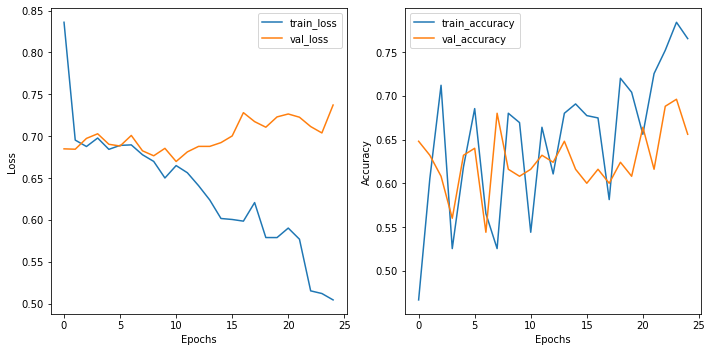

In [326]:
plot_metrics(model_41_results)

It's really fluctuating, accuracy is all over the place. 

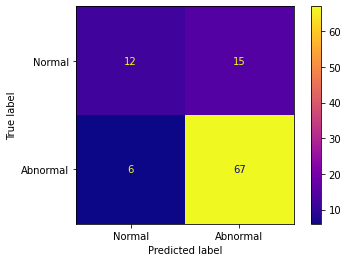

In [327]:
plot_cm(model_41)

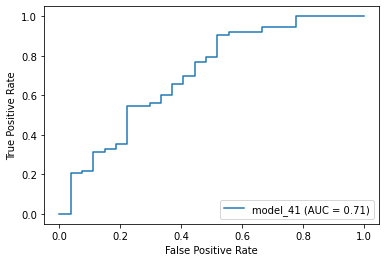

In [329]:
plot_roc(model_41, 'model_41')

The model is doing an average job at the predictions. Let's add just a little more complexity because that seemed to help. 

# Model #42
<hr style="border:2px solid pink">

Adding another hidden dense layer and increasing the units. 

In [348]:
model_42 = Sequential()

model_42.add(Conv2D(filters=64, 
                        kernel_size=(3,3), 
                        activation='tanh', 
                        input_shape=input_shape, 
                        kernel_regularizer=l2(0.0001)))
model_42.add(Dense(128, activation='tanh'))
model_42.add(MaxPooling2D(pool_size=(2,2)))
model_42.add(Dropout(0.5))

model_42.add(Conv2D(256, (3, 3), activation='tanh', kernel_regularizer=l2(0.0001)))
model_42.add(Dense(64, activation='tanh'))
model_42.add(BatchNormalization())
model_42.add(MaxPooling2D(pool_size=(2,2)))
model_42.add(Dropout(0.3))

model_42.add(Conv2D(64, (3, 3), activation='tanh', kernel_regularizer=l2(0.0001)))
model_42.add(MaxPooling2D(pool_size=(2,2)))
model_42.add(Dropout(0.3))

model_42.add(Flatten())
model_42.add(Dense(256, activation='tanh'))
model_42.add(Dropout(0.3))
model_42.add(Dense(64, activation='tanh'))
model_42.add(Dropout(0.2))
model_42.add(Dense(128, activation='tanh'))
model_42.add(Dense(64, activation='tanh'))
model_42.add(Dense(32, activation='tanh'))
model_42.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.0001)))

model_42.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision, recall])

model_42.summary()

Model: "sequential_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_139 (Conv2D)          (None, 62, 62, 64)        640       
_________________________________________________________________
dense_207 (Dense)            (None, 62, 62, 128)       8320      
_________________________________________________________________
max_pooling2d_139 (MaxPoolin (None, 31, 31, 128)       0         
_________________________________________________________________
dropout_109 (Dropout)        (None, 31, 31, 128)       0         
_________________________________________________________________
conv2d_140 (Conv2D)          (None, 29, 29, 256)       295168    
_________________________________________________________________
dense_208 (Dense)            (None, 29, 29, 64)        16448     
_________________________________________________________________
batch_normalization_18 (Batc (None, 29, 29, 64)      

In [349]:
model_42_results = model_42.fit(train_images, 
                                binary_train_labels, 
                                batch_size=50, 
                                epochs=25,
                                validation_split=0.25,
                                class_weight=class_weights_dict)

Epoch 1/25
8/8 [==============================] - 4s 548ms/step - loss: 0.7954 - accuracy: 0.4267 - precision: 0.7514 - recall: 0.3886 - val_loss: 0.6961 - val_accuracy: 0.6480 - val_precision: 0.6471 - val_recall: 0.9747
Epoch 2/25
8/8 [==============================] - 6s 715ms/step - loss: 0.7231 - accuracy: 0.6960 - precision: 0.7283 - recall: 0.9386 - val_loss: 0.7111 - val_accuracy: 0.5760 - val_precision: 0.6383 - val_recall: 0.7595
Epoch 3/25
8/8 [==============================] - 7s 838ms/step - loss: 0.7089 - accuracy: 0.4400 - precision: 0.7161 - recall: 0.4007 - val_loss: 0.7040 - val_accuracy: 0.5760 - val_precision: 0.6140 - val_recall: 0.8861
Epoch 4/25
8/8 [==============================] - 7s 855ms/step - loss: 0.7056 - accuracy: 0.6560 - precision: 0.7387 - recall: 0.8267 - val_loss: 0.6953 - val_accuracy: 0.6400 - val_precision: 0.6393 - val_recall: 0.9873
Epoch 5/25
8/8 [==============================] - 8s 1s/step - loss: 0.6964 - accuracy: 0.6507 - precision: 0.74

In [350]:
evaluate_model(model_42)

4/4 [==============================] - 1s 157ms/step - loss: 0.7665 - accuracy: 0.7300 - precision: 0.7300 - recall: 1.0000
Training Loss: 0.71
Training Accuracy: 0.714
Training Precision: 0.748
Training Recall: 0.902
---------------------------
Testing Loss: 0.766
Testing Accuracy: 0.73
Testing Precision: 0.73
Testing Recall: 1.0


Scores did not improve, they actually got worse. Let's check out the plots. 

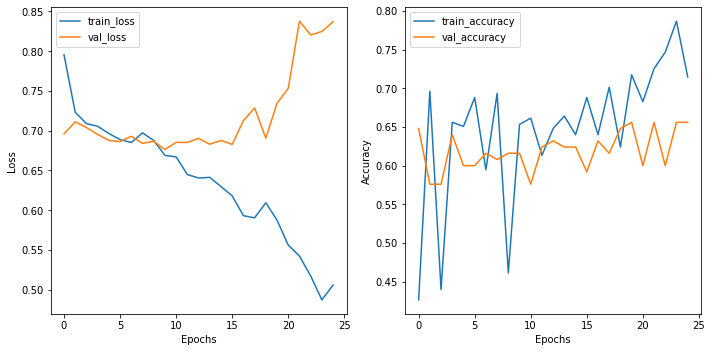

In [351]:
plot_metrics(model_42_results)

Very sporadic - look at how train accuracy goes to such extreme highs and lows. 

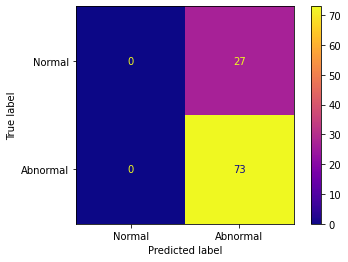

In [352]:
plot_cm(model_42)

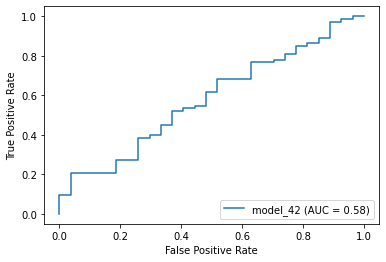

In [353]:
plot_roc(model_42, 'model_42')

The model is just predicting the majority class once again. 

Let's try and adjust model 29 just a little bit, as those scores were pretty good. 

# Model #43
<hr style="border:2px solid pink">

Added dropout regularization. 

In [419]:
model_43 = Sequential()

model_43.add(Conv2D(filters=64, 
                        kernel_size=(3,3), 
                        activation='tanh', 
                        input_shape=input_shape, 
                        kernel_regularizer=l2(0.0001)))

model_43.add(MaxPooling2D(pool_size=(2,2)))
model_43.add(Dropout(0.3))

model_43.add(Conv2D(256, (3, 3), activation='tanh', kernel_regularizer=l2(0.0001)))
model_43.add(MaxPooling2D(pool_size=(2,2)))
model_43.add(Dropout(0.4))

model_43.add(Conv2D(128, (3, 3), activation='tanh', kernel_regularizer=l2(0.0001)))
model_43.add(MaxPooling2D(pool_size=(2,2)))
model_43.add(Dropout(0.7))

model_43.add(Flatten())
model_43.add(Dense(128, activation='tanh'))
model_43.add(Dense(64, activation='tanh'))
model_43.add(Dense(32, activation='tanh'))          
model_43.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.0001)))

model_43.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision, recall])

model_43.summary()

Model: "sequential_62"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_184 (Conv2D)          (None, 62, 62, 64)        640       
_________________________________________________________________
max_pooling2d_184 (MaxPoolin (None, 31, 31, 64)        0         
_________________________________________________________________
dropout_158 (Dropout)        (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_185 (Conv2D)          (None, 29, 29, 256)       147712    
_________________________________________________________________
max_pooling2d_185 (MaxPoolin (None, 14, 14, 256)       0         
_________________________________________________________________
dropout_159 (Dropout)        (None, 14, 14, 256)       0         
_________________________________________________________________
conv2d_186 (Conv2D)          (None, 12, 12, 128)     

In [420]:
# lowered the epochs from 25 to 20
model_43_results = model_43.fit(train_images, 
                                binary_train_labels, 
                                batch_size=50, 
                                epochs=20,
                                validation_split=0.25,
                                class_weight=class_weights_dict)

Epoch 1/20
8/8 [==============================] - 5s 659ms/step - loss: 0.7325 - accuracy: 0.6080 - precision: 0.7609 - recall: 0.7457 - val_loss: 0.7079 - val_accuracy: 0.5520 - val_precision: 0.7255 - val_recall: 0.4684
Epoch 2/20
8/8 [==============================] - 6s 744ms/step - loss: 0.6942 - accuracy: 0.6427 - precision: 0.7804 - recall: 0.7184 - val_loss: 0.7383 - val_accuracy: 0.4800 - val_precision: 0.7059 - val_recall: 0.3038
Epoch 3/20
8/8 [==============================] - 6s 757ms/step - loss: 0.6900 - accuracy: 0.6080 - precision: 0.7686 - recall: 0.6715 - val_loss: 0.7180 - val_accuracy: 0.5360 - val_precision: 0.7143 - val_recall: 0.4430
Epoch 4/20
8/8 [==============================] - 6s 756ms/step - loss: 0.6887 - accuracy: 0.5680 - precision: 0.7889 - recall: 0.5668 - val_loss: 0.6632 - val_accuracy: 0.6480 - val_precision: 0.6522 - val_recall: 0.9494
Epoch 5/20
8/8 [==============================] - 6s 739ms/step - loss: 0.6788 - accuracy: 0.5813 - precision: 0

In [421]:
evaluate_model(model_43)

4/4 [==============================] - 0s 83ms/step - loss: 0.4875 - accuracy: 0.8000 - precision: 0.8272 - recall: 0.9178
Training Loss: 0.346
Training Accuracy: 0.888
Training Precision: 0.889
Training Recall: 0.963
---------------------------
Testing Loss: 0.487
Testing Accuracy: 0.8
Testing Precision: 0.827
Testing Recall: 0.918


These results are pretty similar to model #29. It's still a little overfit, but slightly less. Recall is still higher than precision which is good. Let's visualize the loss and accuracy. 

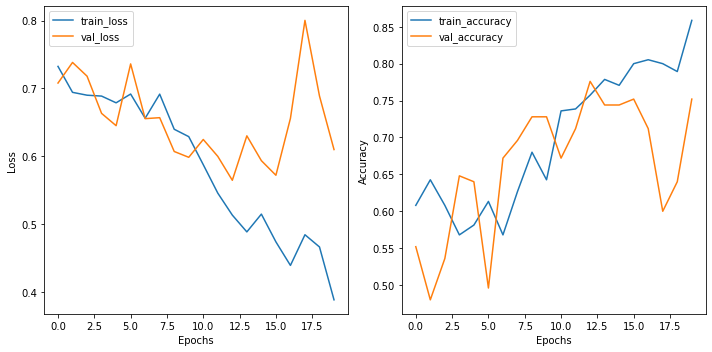

In [423]:
plot_metrics(model_43_results)

The validation loss seems to spike at 17 or so epochs, and the accuracy takes a pretty big dip there too. Let's try lowering the epochs down to 15 and see if that helps. But first, let's look at the confusion matrix and roc curve. 

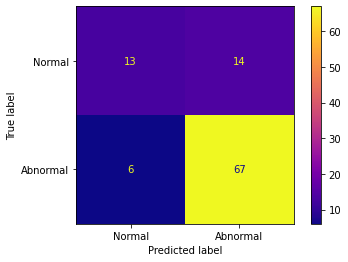

In [422]:
plot_cm(model_43)

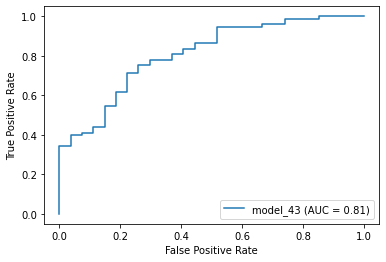

In [424]:
plot_roc(model_43, 'model_43')

The confusion matrix and AUC score are pretty similar to model #29 as well, with minor differences in each score. 

Let's see the same model with slighly stronger regularization, but with 15 epochs instead. 

# Model #44
<hr style="border:2px solid pink">

In [436]:
model_44 = Sequential()

model_44.add(Conv2D(filters=64, 
                        kernel_size=(3,3), 
                        activation='tanh', 
                        input_shape=input_shape, 
                        kernel_regularizer=l2(0.0001)))

model_44.add(MaxPooling2D(pool_size=(2,2)))
model_44.add(Dropout(0.4))

model_44.add(Conv2D(256, (3, 3), activation='tanh', kernel_regularizer=l2(0.0001)))
model_44.add(MaxPooling2D(pool_size=(2,2)))
model_44.add(Dropout(0.4))

model_44.add(Conv2D(128, (3, 3), activation='tanh', kernel_regularizer=l2(0.0001)))
model_44.add(MaxPooling2D(pool_size=(2,2)))
model_44.add(Dropout(0.75))

model_44.add(Flatten())
model_44.add(Dense(128, activation='tanh'))
model_44.add(Dense(64, activation='tanh'))
model_44.add(Dense(32, activation='tanh'))          
model_44.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.0001)))

model_44.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision, recall])

model_44.summary()

Model: "sequential_64"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_190 (Conv2D)          (None, 62, 62, 64)        640       
_________________________________________________________________
max_pooling2d_190 (MaxPoolin (None, 31, 31, 64)        0         
_________________________________________________________________
dropout_164 (Dropout)        (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_191 (Conv2D)          (None, 29, 29, 256)       147712    
_________________________________________________________________
max_pooling2d_191 (MaxPoolin (None, 14, 14, 256)       0         
_________________________________________________________________
dropout_165 (Dropout)        (None, 14, 14, 256)       0         
_________________________________________________________________
conv2d_192 (Conv2D)          (None, 12, 12, 128)     

In [437]:
model_44_results = model_44.fit(train_images, 
                                binary_train_labels, 
                                batch_size=50, 
                                epochs=15,
                                validation_split=0.25,
                                class_weight=class_weights_dict)

Epoch 1/15
8/8 [==============================] - 4s 491ms/step - loss: 0.8325 - accuracy: 0.5600 - precision: 0.7662 - recall: 0.6743 - val_loss: 0.6763 - val_accuracy: 0.6320 - val_precision: 0.6320 - val_recall: 1.0000
Epoch 2/15
8/8 [==============================] - 6s 755ms/step - loss: 0.6907 - accuracy: 0.4907 - precision: 0.7654 - recall: 0.4477 - val_loss: 0.6996 - val_accuracy: 0.5600 - val_precision: 0.6429 - val_recall: 0.6835
Epoch 3/15
8/8 [==============================] - 6s 793ms/step - loss: 0.6927 - accuracy: 0.6533 - precision: 0.7616 - recall: 0.7726 - val_loss: 0.6788 - val_accuracy: 0.6320 - val_precision: 0.6486 - val_recall: 0.9114
Epoch 4/15
8/8 [==============================] - 7s 841ms/step - loss: 0.6929 - accuracy: 0.6240 - precision: 0.7345 - recall: 0.7690 - val_loss: 0.7261 - val_accuracy: 0.5120 - val_precision: 0.7045 - val_recall: 0.3924
Epoch 5/15
8/8 [==============================] - 6s 706ms/step - loss: 0.6700 - accuracy: 0.5520 - precision: 0

In [438]:
evaluate_model(model_44)

4/4 [==============================] - 1s 141ms/step - loss: 0.5366 - accuracy: 0.8000 - precision: 0.8272 - recall: 0.9178
Training Loss: 0.503
Training Accuracy: 0.782
Training Precision: 0.814
Training Recall: 0.899
---------------------------
Testing Loss: 0.537
Testing Accuracy: 0.8
Testing Precision: 0.827
Testing Recall: 0.918


The model is slightly underfit, but not by much. Recall is still higher than precision which is good. Let's see what the loss and accuracy look like. 

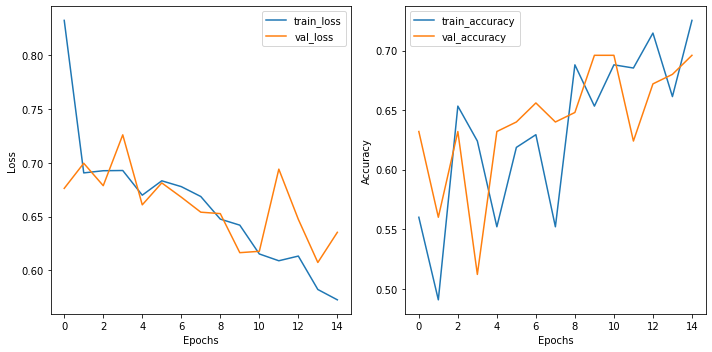

In [439]:
plot_metrics(model_44_results)

A lot of fluctuations.. loss seems to spike around 12 epochs, and accuracy takes a dip around 3 and 11 epochs. 

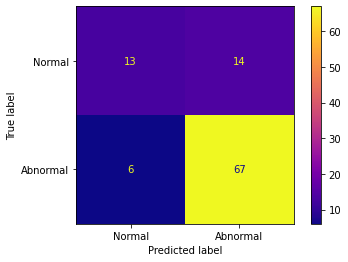

In [440]:
plot_cm(model_44)

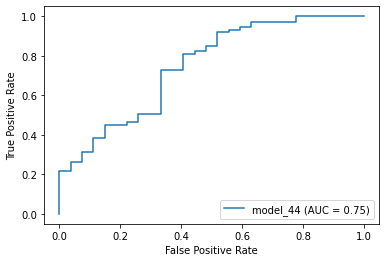

In [441]:
plot_roc(model_44, 'model_44')

The model is doing a decent job of minimizing false negatives, about the same as the last model. Let's lower regularization just a little bit to try and get training scores up a tad. 

# Model #45
<hr style="border:2px solid pink">

Here, I lowered regularization just a tad, and changed the filters to 74 in the first convolutional layer. 

In [480]:
model_45 = Sequential()

model_45.add(Conv2D(filters=74, 
                        kernel_size=(3,3), 
                        activation='tanh', 
                        input_shape=input_shape, 
                        kernel_regularizer=l2(0.0001)))

model_45.add(MaxPooling2D(pool_size=(2,2)))
model_45.add(Dropout(0.45))

model_45.add(Conv2D(256, (3, 3), activation='tanh', kernel_regularizer=l2(0.0001)))
model_45.add(MaxPooling2D(pool_size=(2,2)))

model_45.add(Conv2D(128, (3, 3), activation='tanh', kernel_regularizer=l2(0.0001)))
model_45.add(MaxPooling2D(pool_size=(2,2)))
model_45.add(Dropout(0.6))

model_45.add(Flatten())
model_45.add(Dense(128, activation='tanh'))
model_45.add(Dense(64, activation='tanh'))
model_45.add(Dense(32, activation='tanh'))          
model_45.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.0001)))

model_45.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision, recall])

model_45.summary()

Model: "sequential_74"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_220 (Conv2D)          (None, 62, 62, 74)        740       
_________________________________________________________________
max_pooling2d_220 (MaxPoolin (None, 31, 31, 74)        0         
_________________________________________________________________
dropout_194 (Dropout)        (None, 31, 31, 74)        0         
_________________________________________________________________
conv2d_221 (Conv2D)          (None, 29, 29, 256)       170752    
_________________________________________________________________
max_pooling2d_221 (MaxPoolin (None, 14, 14, 256)       0         
_________________________________________________________________
conv2d_222 (Conv2D)          (None, 12, 12, 128)       295040    
_________________________________________________________________
max_pooling2d_222 (MaxPoolin (None, 6, 6, 128)       

We're up to 1,066,853 parameters! This is pretty complex, let's see how it does. 

In [481]:
model_45_results = model_45.fit(train_images, 
                                binary_train_labels, 
                                batch_size=50, 
                                epochs=15,
                                validation_split=0.25,
                                class_weight=class_weights_dict)

Epoch 1/15
8/8 [==============================] - 12s 1s/step - loss: 0.7786 - accuracy: 0.5680 - precision: 0.7428 - recall: 0.6600 - val_loss: 0.8427 - val_accuracy: 0.3680 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/15
8/8 [==============================] - 13s 2s/step - loss: 0.7143 - accuracy: 0.5120 - precision: 0.7217 - recall: 0.5523 - val_loss: 0.7043 - val_accuracy: 0.5840 - val_precision: 0.6800 - val_recall: 0.6456
Epoch 3/15
8/8 [==============================] - 12s 1s/step - loss: 0.6904 - accuracy: 0.6187 - precision: 0.7680 - recall: 0.6931 - val_loss: 0.6798 - val_accuracy: 0.6240 - val_precision: 0.6667 - val_recall: 0.8101
Epoch 4/15
8/8 [==============================] - 12s 1s/step - loss: 0.6882 - accuracy: 0.5520 - precision: 0.7946 - recall: 0.5307 - val_loss: 0.6812 - val_accuracy: 0.6560 - val_precision: 0.6800 - val_recall: 0.8608
Epoch 5/15
8/8 [==============================] - 8s 1s/step - loss: 0.6911 - accuracy: 0.5600 - precision: 0.76

In [482]:
evaluate_model(model_45)

4/4 [==============================] - 0s 93ms/step - loss: 0.4639 - accuracy: 0.8000 - precision: 0.8354 - recall: 0.9041
Training Loss: 0.426
Training Accuracy: 0.834
Training Precision: 0.876
Training Recall: 0.893
---------------------------
Testing Loss: 0.464
Testing Accuracy: 0.8
Testing Precision: 0.835
Testing Recall: 0.904


Finally!! These results are great! Training accuracy is 83%, precision is 88%, and recall is slightly higher at 89%, while testing accuracy is 80%, precision is 84%, and recall is higher at  90%. This is still slightly overfit, but not by as much as model #29. Both train and test loss are reasonable, let's see what they look like. 

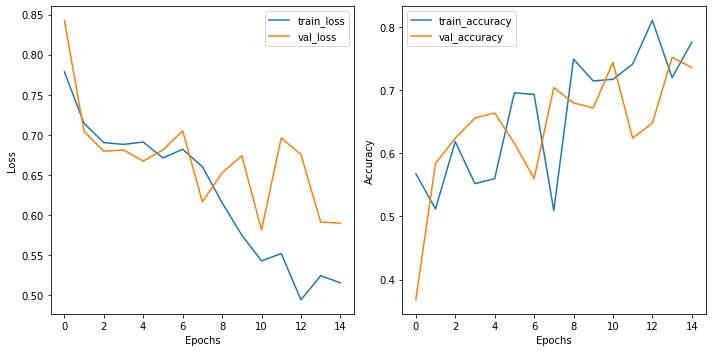

In [483]:
plot_metrics(model_45_results)

Still a little fluctuation going on there, but the general direction is correct for all. Let's see the confusion matrix and roc curve. 

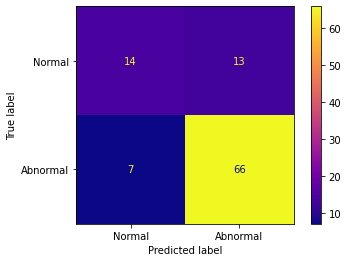

In [484]:
plot_cm(model_45)

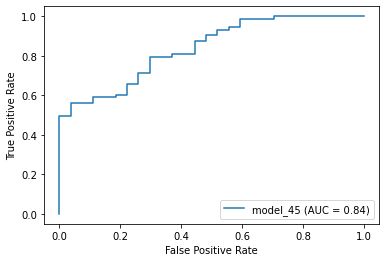

In [485]:
plot_roc(model_45, 'model_45')

We have 14 true negatives, 7 false negatives, 13 false positives, and 66 true positives, suggesting the model did successfully minimize false negatives. There's still quite a few false positives however. AUC score is 0.84, suggesting the model is performing pretty well. 

With that, I think we have enough models to pick a final one. 

# Picking a Final Model
<hr style="border:2px solid pink">

After reviewing all of the metrics for the 41 different models, here are the top 3: 

Model 29: 
1. slightly overfit
2. recall is higher than precision
3. scores are all pretty high
4. a lot of fluctuation in the loss and accuracy, but general trend in the correct directions
5. false negatives are minimized
6. high auc score

In [355]:
evaluate_model(model_29)

4/4 [==============================] - 0s 33ms/step - loss: 0.4945 - accuracy: 0.8100 - precision: 0.8214 - recall: 0.9452
Training Loss: 0.336
Training Accuracy: 0.892
Training Precision: 0.927
Training Recall: 0.921
---------------------------
Testing Loss: 0.494
Testing Accuracy: 0.81
Testing Precision: 0.821
Testing Recall: 0.945


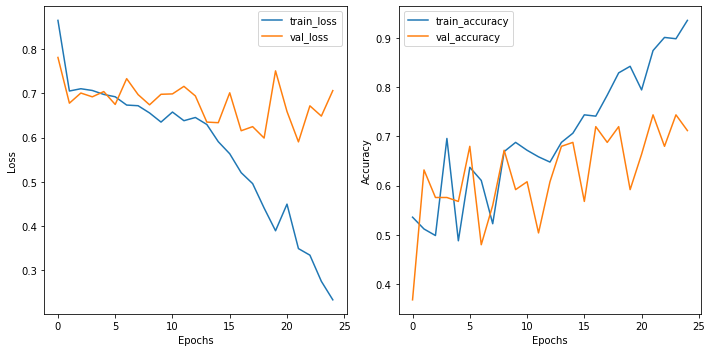

In [361]:
plot_metrics(model_29_results)

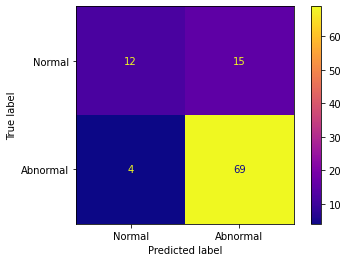

In [362]:
plot_cm(model_29)

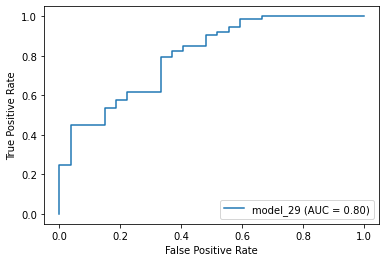

In [363]:
plot_roc(model_29, 'model_29')

Model 41: 
1. very similar scores for training and test
2. recall is higher than precision
3. more intense fluctuations, val loss trending in the wrong direction
4. false negatives are minimized
5. lowest auc score

In [356]:
evaluate_model(model_41)

4/4 [==============================] - 0s 50ms/step - loss: 0.5619 - accuracy: 0.7900 - precision: 0.8171 - recall: 0.9178
Training Loss: 0.462
Training Accuracy: 0.792
Training Precision: 0.844
Training Recall: 0.868
---------------------------
Testing Loss: 0.562
Testing Accuracy: 0.79
Testing Precision: 0.817
Testing Recall: 0.918


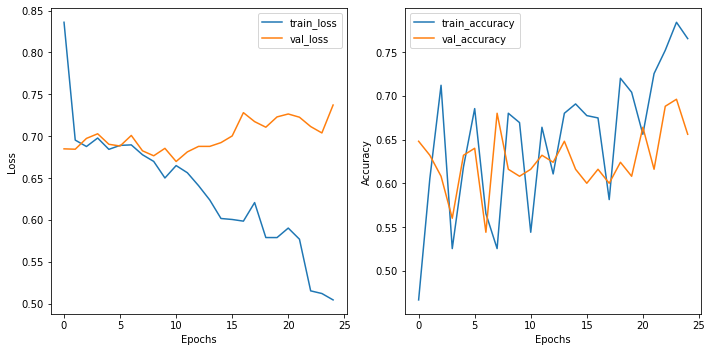

In [365]:
plot_metrics(model_41_results)

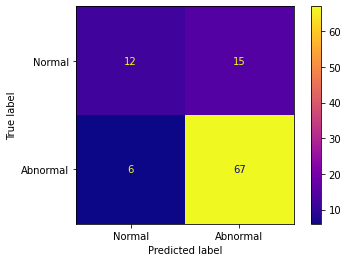

In [366]:
plot_cm(model_41)

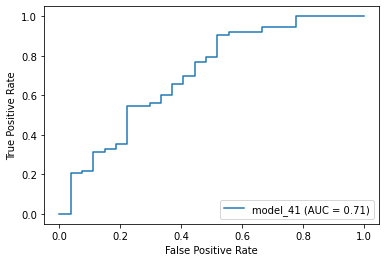

In [367]:
plot_roc(model_41, 'model_41')

Model 45:
1. slightly overfit
2. recall is higher than precision
3. loss and accuracy are not fluctuating so much (big spikes but less frequent)
4. false negatives are minimized
5. high auc score

In [486]:
evaluate_model(model_45)

4/4 [==============================] - 1s 128ms/step - loss: 0.4639 - accuracy: 0.8000 - precision: 0.8354 - recall: 0.9041
Training Loss: 0.426
Training Accuracy: 0.834
Training Precision: 0.876
Training Recall: 0.893
---------------------------
Testing Loss: 0.464
Testing Accuracy: 0.8
Testing Precision: 0.835
Testing Recall: 0.904


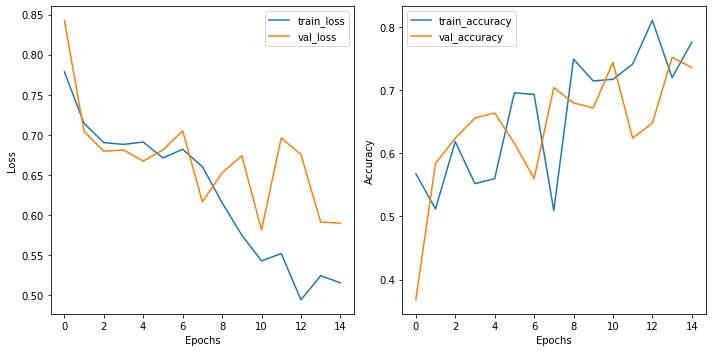

In [487]:
plot_metrics(model_45_results)

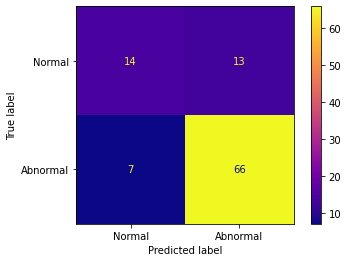

In [488]:
plot_cm(model_45)

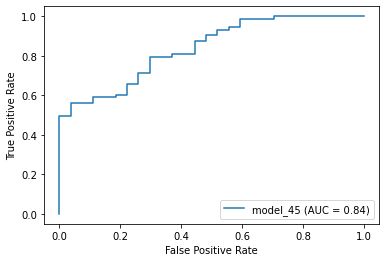

In [489]:
plot_roc(model_45, 'model_45')

After reviewing all the metrics for the 3 models, here are my thoughts: 
- Model 29 is overfit, is it too overfit? Has the biggest delta between training and testing accuracy. 
- Model 29 loss and accuracy fluctuate quite a bit, not as much as model 41. 
- Model 29 Scores are pretty high all around. 
- Model 41 seems to fluctuate in loss and accuracy the most. 
- Model 41 has the lowest auc score, but also the smallest delta in training and testing accuracy. 
- Model 45 is slightly overfit, not as much as model 29. 
- Model 45 has high scores all around.

It seems that model #45 has the best metrics all around, so let's use model #45 as the final model. 

# Setting Model #45 as the Final Model
<hr style="border:2px solid pink">

Let's set model #45 as our final model, and review the results one more time. 

In [611]:
# set model 45 = the final model
the_final_model = model_45

# set model 45 results (the results of the fit) equal to the final model results
the_final_model_results = model_45_results

In [612]:
# review the architecture
the_final_model.summary()

Model: "sequential_74"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_220 (Conv2D)          (None, 62, 62, 74)        740       
_________________________________________________________________
max_pooling2d_220 (MaxPoolin (None, 31, 31, 74)        0         
_________________________________________________________________
dropout_194 (Dropout)        (None, 31, 31, 74)        0         
_________________________________________________________________
conv2d_221 (Conv2D)          (None, 29, 29, 256)       170752    
_________________________________________________________________
max_pooling2d_221 (MaxPoolin (None, 14, 14, 256)       0         
_________________________________________________________________
conv2d_222 (Conv2D)          (None, 12, 12, 128)       295040    
_________________________________________________________________
max_pooling2d_222 (MaxPoolin (None, 6, 6, 128)       

The final model has 1,066,853 parameters. It starts with a convolutional 2D input layer with 74 filters, tanh activation, and L2 regularization. There are multiple additional convolutional layers, as well as max pooling 2D layers, a flattening layer, and several hidden dense layers. To control the overfitting, there are dropout layers spread throughout in addition to multiple layers having L2 regularization. The output layer is dense layer with 1 output unit, as is typical in binary tasks, and sigmoid activation. 

Let's review the accuracy, precision, recall, and loss. 

In [613]:
evaluate_model(the_final_model)

4/4 [==============================] - 0s 37ms/step - loss: 0.4639 - accuracy: 0.8000 - precision: 0.8354 - recall: 0.9041
Training Loss: 0.426
Training Accuracy: 0.834
Training Precision: 0.876
Training Recall: 0.893
---------------------------
Testing Loss: 0.464
Testing Accuracy: 0.8
Testing Precision: 0.835
Testing Recall: 0.904


The final model has a training loss of 0.426, accuracy of 83%, precision of 88%, and recall of 89%, in addition to a testing loss of 0.464, accuracy of 80%, precision of 84%, and recall of 90%. 

Given the goal of minimizing false positives and prioritizing a high recall, this is a great result!

Let's look at the loss and accuracy plotted. 

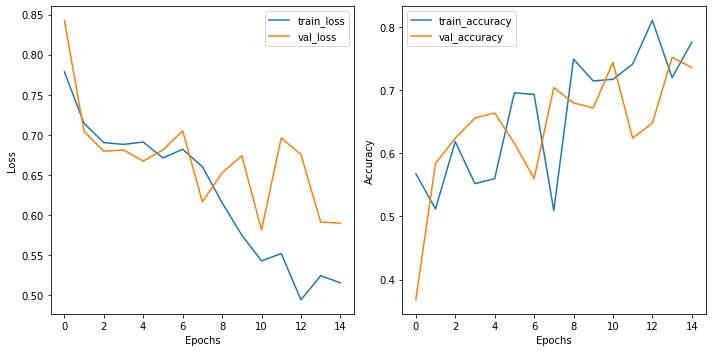

In [614]:
plot_metrics(the_final_model_results)

There were definitely some fluctuations in both loss and accuracy for both train and test sets. Some next steps would be to find a way to smooth these out to ensure a more efficient convergence. 

Let's look at the confusion matrix and roc-auc curve one more time. 

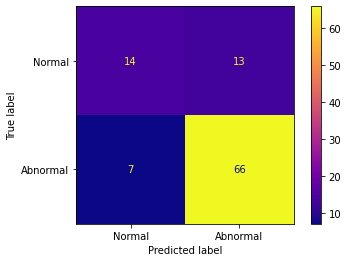

In [615]:
plot_cm(the_final_model)

We have 14 true negatives, 7 false negatives, 13 false positives, and 66 true positives - we've successfully minimized false negatives! Some next steps here would be to get a confusion matrix for the entirety of the test set, rather than just a batch, as well as continued tweaking of the model to lower false positives a little more while keeping false negatives low. 

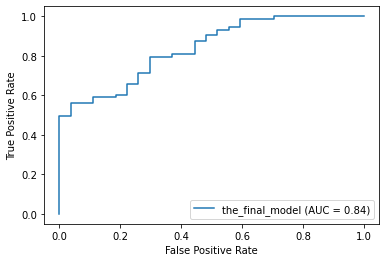

In [616]:
plot_roc(the_final_model, 'the_final_model')

Finally, we have an AUC score of 0.84, which suggests the final model is pretty good at classifying retinal scans!

# Final Evaluations
<hr style="border:2px solid pink">

Let's evaluate the scores on the train set, then the test set, then the holdout validation set to see how the model performs. 

Let's start with testing on the training set. 

In [617]:
# evaluate using train set from image data generator
the_final_model.evaluate(train_images, binary_train_labels)

16/16 [==============================] - 1s 58ms/step - loss: 0.4257 - accuracy: 0.8340 - precision: 0.8760 - recall: 0.8933


[0.4256705343723297,
 0.8339999914169312,
 0.8760330677032471,
 0.8932584524154663]

We have 0.43 loss, 83% accuracy, 88% precision, and 89% recall. Pretty good!

Let's view the test set scores. 

In [618]:
# evaluate using the test set from image data generator
the_final_model.evaluate(test_images, binary_test_labels)

4/4 [==============================] - 0s 35ms/step - loss: 0.4639 - accuracy: 0.8000 - precision: 0.8354 - recall: 0.9041


[0.463932067155838, 0.800000011920929, 0.8354430198669434, 0.9041095972061157]

We have 0.46 loss, 80% accuracy, 84% precision, and 90% recall. Pretty good!

Finally, let's view the validation set scores. 

In [619]:
# evaluate using the validation set from image data generator
the_final_model.evaluate(val_images, binary_val_labels)

1/1 [==============================] - 0s 2ms/step - loss: 0.7056 - accuracy: 0.8000 - precision: 1.0000 - recall: 0.6667


[0.7056018710136414, 0.800000011920929, 1.0, 0.6666666865348816]

We have 0.71 loss, 80% accuracy, 100% precision, and 67% recall. Not as great!

I'd like to note that the validation set has 8 images per category, which could be why the scores are skewed. Regardless, with more tweaking of the model, I am confident I could increase validation scores!

# Saving the Final Model
<hr style="border:2px solid pink">

Finally, let's save the final model so that I can load it as needed at a later time. I saw two ways to do this on this blog post: https://machinelearningmastery.com/save-load-keras-deep-learning-models/

I'm not sure which format I will need in the future, so I will save as both H5 and JSON formats to be safe. 

In [620]:
# save as H5
from tensorflow.keras.models import load_model
import pickle

the_final_model.save('the_final_model.h5')

# Save the training history
history = the_final_model_results
with open('the_final_model.pkl', 'wb') as file:
    pickle.dump(history.history, file)
    
# Load the model
loaded_model = load_model('the_final_model.h5')

# Load the training history
with open("the_final_model.pkl", 'rb') as file:
    loaded_history = pickle.load(file)

In [621]:
# save as JSON
from tensorflow.keras.models import Sequential, model_from_json

# serialize model to JSON
the_final_model_json = the_final_model.to_json()
with open("the_final_model.json", "w") as json_file:
    json_file.write(the_final_model_json)
# serialize weights to HDF5
the_final_model.save_weights("the_final_model.h5")
print("Saved model to disk")

Saved model to disk


Great! The models should now be saved to the GitHub repository. 

# Next Steps
<hr style="border:2px solid pink">

As with any machine learning project, there are a few next steps I would like to explore: 

**1. Gather more data!** I started out with around 85,000 images, and used data augmentation techniques to increase that further. However, more genuine data is always useful and encouraged in building successful and accurate models. 

**2. Continue tweaking the final model:** Although my final scores are pretty good, there is always room for improvement. Given more time, a more powerful computer, and additional memory, I believe further optimization could be achieved, and the scores could be increased. I would also like to try GridSearching to help with hyperparameter tuning.  

**3. Return to Multi-Class classification:** For the purposes of this notebook, and due to time constraints, I have built a binary model predicting if the image normal or abnormal. Returning to a multi-class aproach will allow for a more nuanced understanding the the individual diseases. 

**4. Build a streamlit app and deploy!** To make it easier and more accessible for medical professionals to get a rapid and accurate initial opinion on a retina scan, I would like to build a streamlit app that will allow a user to drop a retina scan in, and get a prediction on whether it is normal, or contains an abnormality. 

# Conclusion
<hr style="border:2px solid pink">

In conclusion, applying the power of machine learning models to the analysis and interpretation of Retinal Optical Coherence Tomography (OCT) scans is a promising path for streamlining the diagnostic and management processes of vision-threatening diseases such as diabetes-related retinopathy, age-related macular degeneration (AMD), and glaucoma. The traditional approach, depending solely on manual analysis by medical professionals, is both time-consuming and resource-intensive.

The machine learning model developed in this project offers a valuable solution by significantly reducing the time and energy invested in the interpretation of retinal OCT scans. By serving as a rapid and accurate second opinion, this model can empower ophthalmologists and other medical professionals, providing them with a reliable tool to aid in the diagnosis and management of eye conditions. 

The spread and use of such a model has the capability to revolutionize the medical field, allowing for more efficient and accessible eye care. This innovation stands as a testament to the transformative impact of artificial intelligence in the realm of medical diagnostics, promising improved patient outcomes and contributing to the overall advancement of healthcare practices.